# Load modules

In [1]:
import _pickle

import os

import pandas as pd

import numpy as np

from pprint import pprint

import xlrd

import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter

from datetime import datetime, timedelta

import gensim.corpora as corpora

import scipy.stats as stats

# Global Variables

In [2]:
# k = 5
# iteration = 1500

# root_dir = "/media/hasibahmed/New Volume/bioinformatics.stackexchange.com/"
# output_dir = os.path.join(root_dir, "Outputs/")
# labeling_dir = os.path.join(output_dir, 'TopicLabeling/')
# cur_dir = os.path.join(labeling_dir, '%d_%d' % (k, iteration))
# post_dir = os.path.join(root_dir, 'Posts/')
# input_dir = os.path.join(root_dir, 'Inputs/')

root_dir = "StackOverflow"
output_dir = root_dir
labeling_dir = root_dir
cur_dir = root_dir
post_dir = root_dir
input_dir = root_dir

# Process Labeling

In [4]:
labeling_df = pd.read_csv(os.path.join(cur_dir, 'Label.csv'))
labeling_df.shape

(5, 3)

In [5]:
labeling_df.columns = ['Topic_Id', 'Category_0', 'Category_1']
labeling_arr = labeling_df.to_numpy()

for topic in labeling_arr:
    for idx in range(1, len(topic[1:]) + 1):
        topic[idx] = topic[idx].upper()

pprint(labeling_arr)

array([[0, 'STATISTICAL ANALYSIS', 'BIODATA PROCESSING'],
       [1, 'BIO-PACKAGE ISSUES', 'PACKAGE ISSUES'],
       [2, 'GENOME ANALYSIS', 'SEQUENCE ANALYSIS'],
       [3, 'PHYLOGENE', 'SEQUENCE ANALYSIS'],
       [4, 'BIODATABASE QUERY', 'BIODATA PROCESSING']], dtype=object)


In [6]:
for topic in labeling_arr:
    for idx in range(1, len(topic[1:]) + 1):
        topic[idx] = topic[idx].upper()

pprint(labeling_arr)

array([[0, 'STATISTICAL ANALYSIS', 'BIODATA PROCESSING'],
       [1, 'BIO-PACKAGE ISSUES', 'PACKAGE ISSUES'],
       [2, 'GENOME ANALYSIS', 'SEQUENCE ANALYSIS'],
       [3, 'PHYLOGENE', 'SEQUENCE ANALYSIS'],
       [4, 'BIODATABASE QUERY', 'BIODATA PROCESSING']], dtype=object)


In [7]:
topic_category_0 = labeling_arr[:, 1]

heirarchy = {}

heriarchy_level = 1

for row in labeling_arr[:, 1:  ]:
    if row[1] not in  heirarchy:
        heirarchy[row[1]] = []
    heirarchy[row[1]].append(row[0])

pprint(heirarchy)

{'BIODATA PROCESSING': ['STATISTICAL ANALYSIS', 'BIODATABASE QUERY'],
 'PACKAGE ISSUES': ['BIO-PACKAGE ISSUES'],
 'SEQUENCE ANALYSIS': ['GENOME ANALYSIS', 'PHYLOGENE']}


In [8]:
_pickle.dump(heirarchy, open(os.path.join(cur_dir, 'heirarchy.pkl'), 'wb'))

# Topic Frequency

In [9]:
summary = []
totalA = 0
totalQ = 0
for idx in range(len(labeling_arr[:, 0])):
    topiId = labeling_arr[idx, 0]
    filename = os.path.join(cur_dir, '%s.xlsx' % topiId)
    if not os.path.exists(filename):
        print('%s is not found.' % filename)
        
    wb = xlrd.open_workbook(filename)
    
    sheet_0 = wb.sheet_by_index(0)
    sheet_1 = wb.sheet_by_index(1)
#     sheet_2 = wb.sheet_by_index(2)
    
    summary.append({
        'ID' : topiId,
        'Topic' : labeling_arr[idx, 1],
        sheet_0.name : sheet_0.nrows - 1,
        sheet_1.name : sheet_1.nrows - 1,
        'Posts' : sheet_0.nrows + sheet_1.nrows - 2,
    })
    totalA += sheet_0.nrows - 1
    totalQ += sheet_1.nrows - 1

In [10]:
totalPosts = totalA + totalQ

totalPosts

4561

In [11]:
for dic in summary:
    dic['Percentage'] = dic['Posts'] / totalPosts * 100
    
for dic in summary:
    dic['PercentageQ'] = dic['Questions'] / totalQ * 100

In [12]:
summary.sort(key = lambda x : x['PercentageQ'], reverse = False)

In [13]:
summary_df = pd.DataFrame(summary)
summary_df.to_csv(
    os.path.join(cur_dir, 'Percentage.csv'),
    index = False)
summary_df.head()

ID                 Topic  Answers  Questions  Posts  Percentage  \
0   3             PHYLOGENE      225        449    674   14.777461   
1   4     BIODATABASE QUERY      237        574    811   17.781188   
2   2       GENOME ANALYSIS      272        604    876   19.206314   
3   1    BIO-PACKAGE ISSUES      425        663   1088   23.854418   
4   0  STATISTICAL ANALYSIS      314        798   1112   24.380618   

   PercentageQ  
0    14.540155  
1    18.588083  
2    19.559585  
3    21.470207  
4    25.841969

In [14]:
def make_label(pct, idx):
    keys = pie_label[idx]
    values = pie_data[idx]
#     s = keys[find_match(values, pct)].split()
    
#     return ''
    return '%s\n%.2f' % ('\n'.join(keys[find_match(values, pct)].split()), pct) + '%'

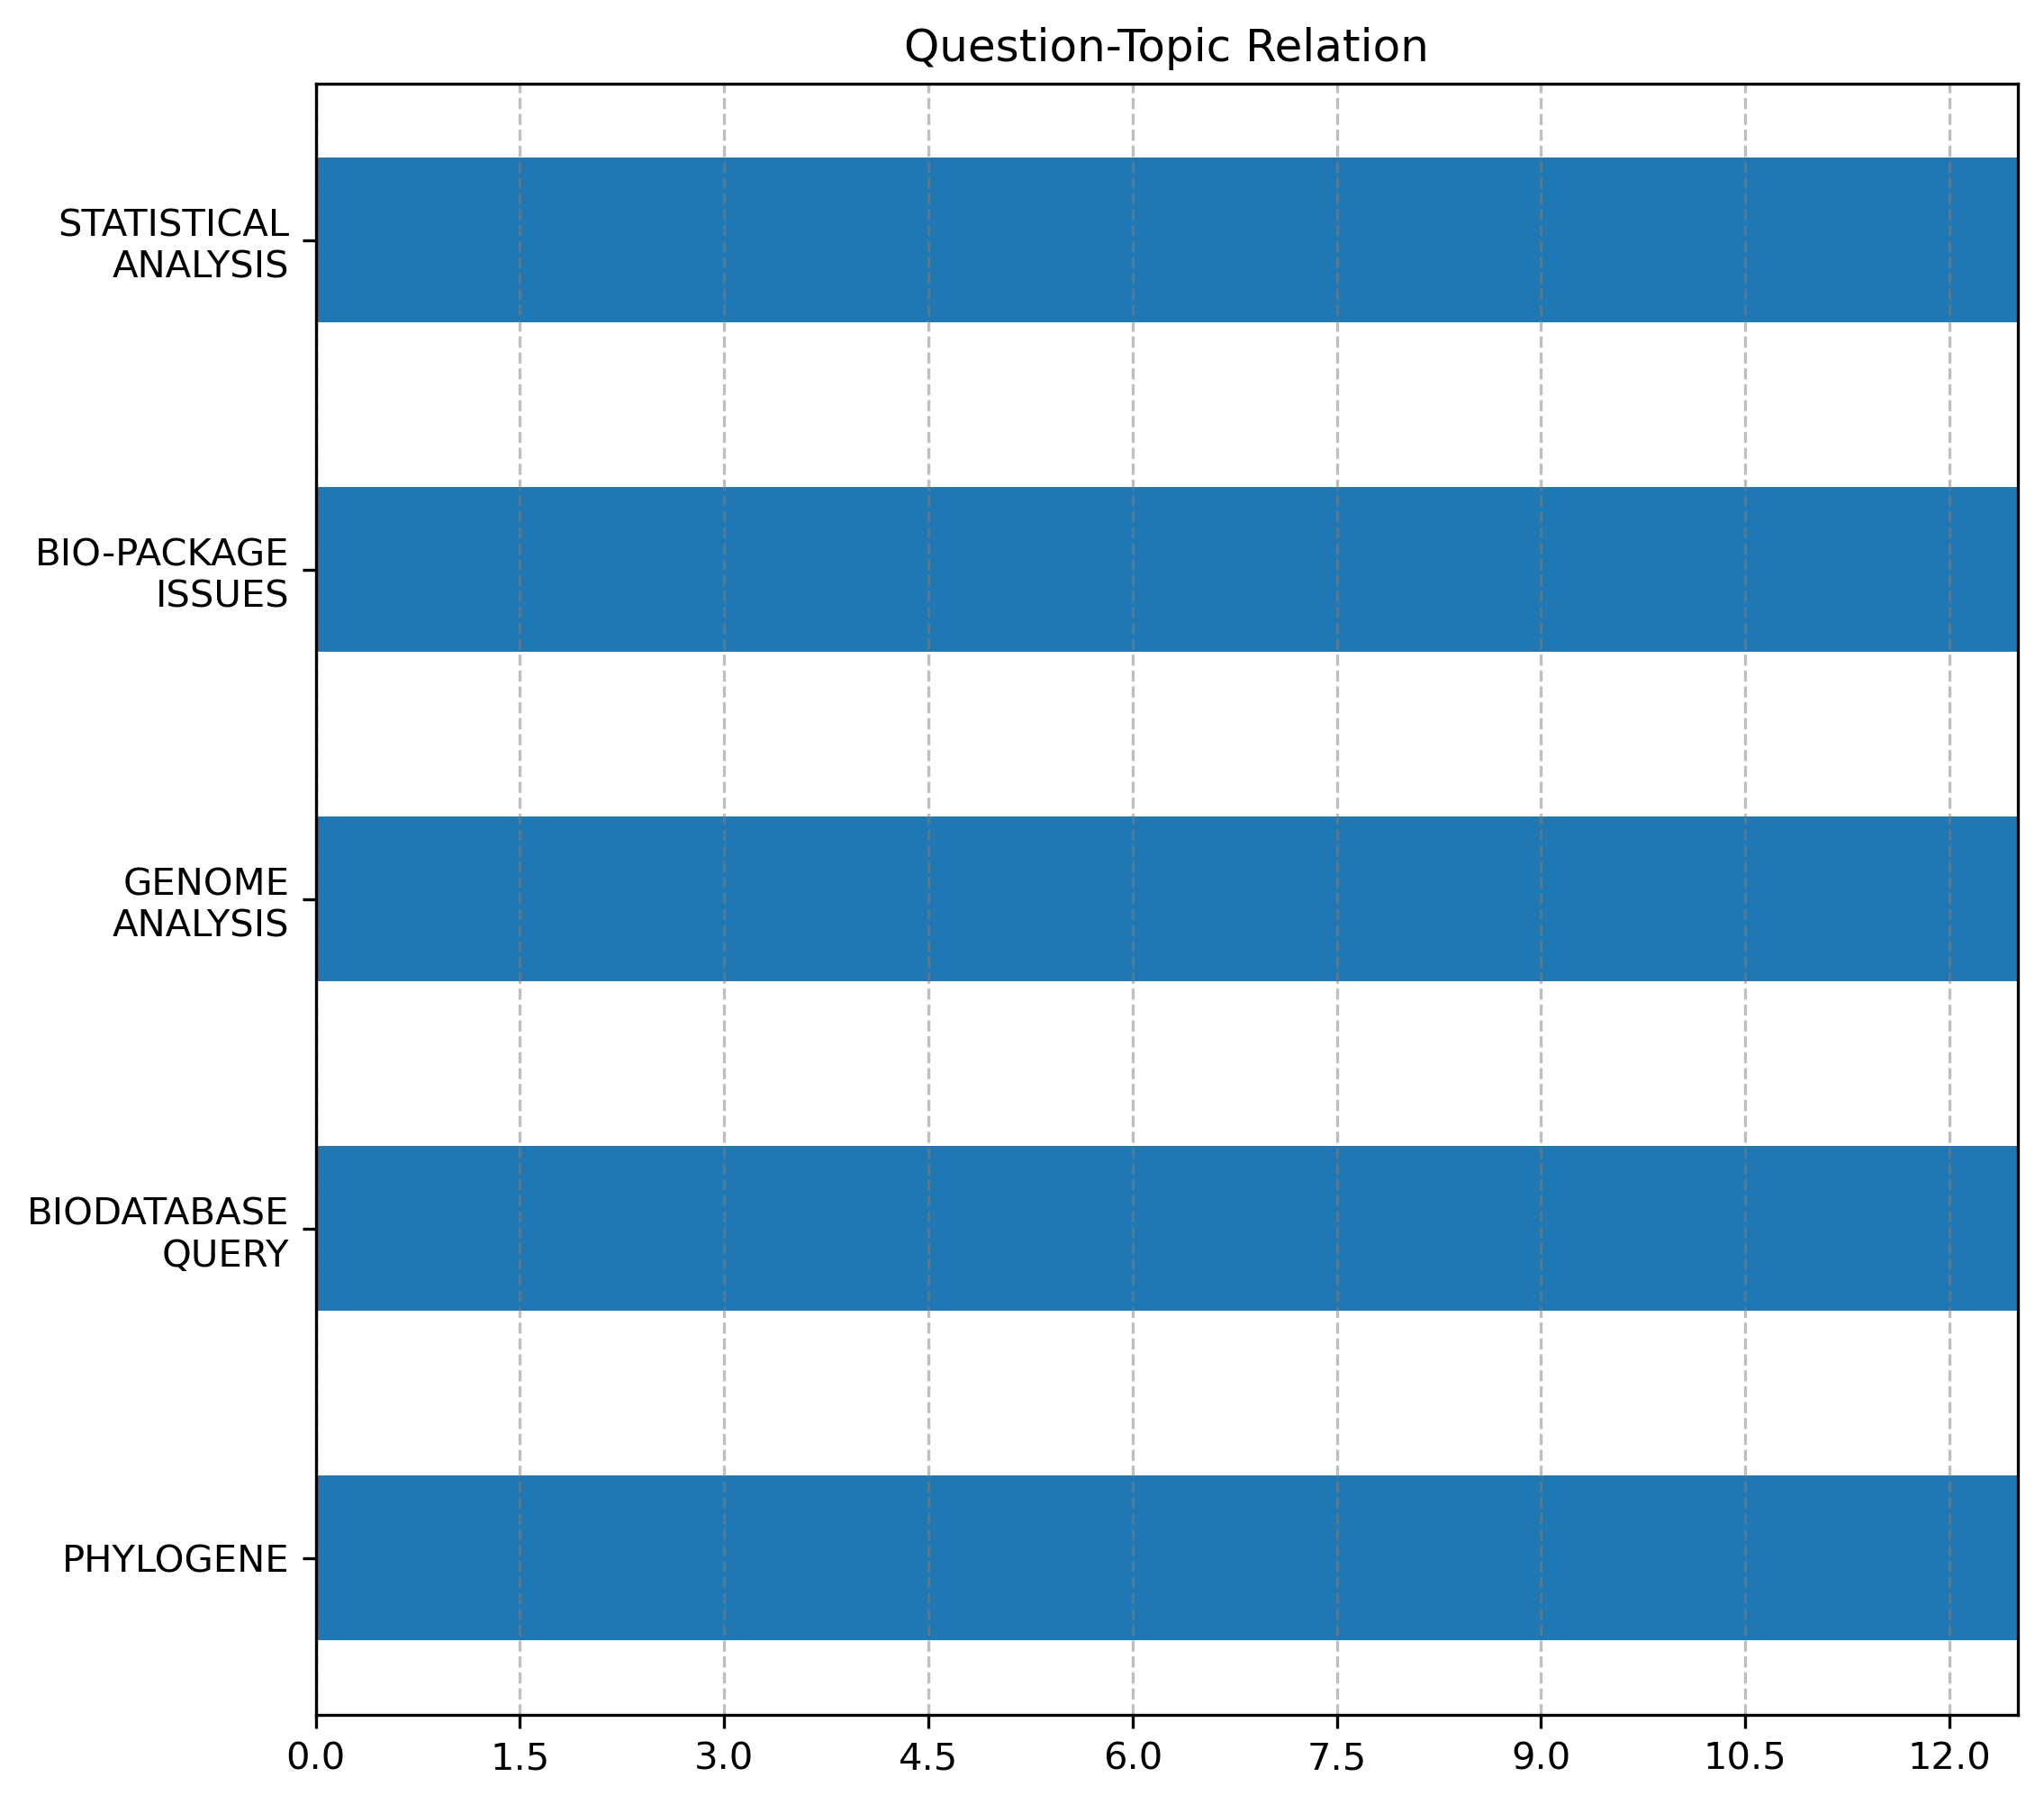

In [15]:
fig, ax1 = plt.subplots(figsize=(9, 8), dpi = 300)
fig.subplots_adjust(left=0.3, right=1) # position of left and right margin, left < right must

tick_labels = summary_df.iloc[:, 1].to_list()
tick_labels = ['\n'.join(item.split()) for item in tick_labels]
rects = ax1.barh(summary_df.index, summary_df.iloc[:, -1].to_numpy(),
    align='center',height=0.5,tick_label=tick_labels)

ax1.set_title('Question-Topic Relation')

ax1.set_xlim([0, 12.5])
ax1.xaxis.set_major_locator(plt.MaxNLocator(11))  # set maximum no of major ticks on x axis 
ax1.xaxis.grid(True, linestyle='--', which='major',
               color='grey', alpha=.5)

mean_perc = np.mean(summary_df.iloc[:, -1].to_numpy())
ax1.axvline(mean_perc, color='red', alpha=0.5)
ax1.annotate('Avarage percentage of\n questions per topic: %.2f%s' % (mean_perc, '%'),
            xy=(mean_perc, 1), xytext=(2, 0),
            textcoords="offset points",
            ha='left', va='center',
            color='r', weight='bold', clip_on=True)

for rect in rects:
    rankStr = "%.2f" % rect.get_width() + '%'
    xloc = 5
    clr = 'black'
    align = 'left'
    yloc = rect.get_y() + rect.get_height() / 2
    ax1.annotate(
        rankStr,
        xy=(rect.get_width(), yloc),
        xytext=(xloc, 0),
        textcoords="offset points",
        ha=align, va='center',
        color=clr, weight='bold', clip_on=True)
    
    rankStr = "%d" % (rect.get_width() * totalQ / 100) + ' questions'
    xloc = -90
    clr = 'white'
    align = 'left'
    yloc = rect.get_y() + rect.get_height() / 2
    ax1.annotate(
        rankStr,
        xy=(rect.get_width(), yloc), xytext=(xloc, 0),
        textcoords="offset points",
        ha=align,
        va='center',
        color=clr,
        weight='bold',
        clip_on=True,
        )
    
# plt.show()
plt.savefig(
    os.path.join(
        cur_dir,
        'Question-topicRelation.svg'),
    bbox_extra_artists = ['Label'],
    format = 'svg')

In [16]:
topic_id_dict = {}
for idx, row in summary_df[['ID', 'Topic']].iterrows():
    topic_id_dict[row[1]] = row[0]

# Popularity

In [17]:
id_topic = _pickle.load(
    open(
        os.path.join(
            cur_dir, 'id_topic.pkl'),
         'rb'))

In [19]:
design_info = pd.read_csv(os.path.join(post_dir, 'DesignPostInformation.csv'))

In [20]:
metrics = []
for topic in id_topic:
    answers = design_info[
        design_info['PostId'].isin(
            topic['Answers'])][['PostId', 'CreationDate']]
    questions = design_info[
        design_info['PostId'].isin(topic['Questions'])
    ][['PostId', 'ViewCount', 'Score', 'FavoriteCount', 'CreationDate', 'AcceptedAnswerId']]
    metrics.append({
        'Answers' : pd.DataFrame(answers),
        'Questions' : pd.DataFrame(questions)
    })

In [21]:
def favourite_converter(fav):
    if fav is np.nan:
        return 0.0
    if isinstance(fav, float):
        return fav
    return float(fav[2:-1])

In [22]:
def accepted_id_converter(a_id):
    if a_id is np.nan:
        return np.nan
    return int(a_id[2:-1])

In [23]:
for topic in metrics:
    answers = topic['Answers'].to_numpy()
    columns = topic['Answers'].columns
    for i in range(answers.shape[0]):
        answers[i, 1] = answers[i, 1][2:-1]
    topic['Answers'] = pd.DataFrame(answers, columns=columns)
    
    questions = topic['Questions'].to_numpy()
    columns = topic['Questions'].columns
    for i in range(questions.shape[0]):
        questions[i, 1] = favourite_converter(questions[i, 1])
        questions[i, 2] = np.float(questions[i, 2][2:-1])
        questions[i, 3] = favourite_converter(questions[i, 3])
        questions[i, 4] = questions[i, 4][2:-1]
        questions[i, 5] = accepted_id_converter(questions[i, 5])
    topic['Questions'] =  pd.DataFrame(questions, columns=columns)
        

In [24]:
popularity = []
for topic in metrics:
    try:
        popularity.append(np.mean(
            topic['Questions'].to_numpy()[:, 1:4], axis=0))
    except ZeroDivisionError:
        popularity.append(np.zeros(3))

In [25]:
popularity_df = pd.DataFrame(
    popularity, columns = ['Avg. View', 'Avg. Score', 'Avg. Favorite'])

In [26]:
popularity_df.to_csv(os.path.join(cur_dir, 'popularity.csv'), index=False)

#  Difficulity

In [27]:
format = '%Y-%m-%dT%H:%M:%S'

In [28]:
q_with_ans = set(design_info['ParentId'].dropna().to_list())
'%d/%d' % (len(q_with_ans), design_info.shape[0]) 

'2615/7312'

In [29]:
difficulity = []
for topic in metrics:
    without_ans = []
    hrs_to_ans = []
    without_acc_ans = []
    for idx, row in topic['Questions'].iterrows():
        if row['PostId'] not in q_with_ans:
            without_ans.append(row['PostId'])
        elif row['AcceptedAnswerId'] is np.nan:
            without_acc_ans.append(row['PostId'])
        else:
            created_on = row['CreationDate']
            solved_on = design_info[
                design_info['PostId'] == row['AcceptedAnswerId']
            ]['CreationDate'].to_numpy()[0][2:-1]
#             print( created_on.split('.')[0], solved_on.split('.')[0])
            tdelta = (datetime.strptime(
                solved_on.split('.')[0], format
            )-datetime.strptime(
                created_on.split('.')[0], format)
                     )
            hrs_to_ans.append(tdelta.total_seconds() / 3600)
        
    try:
        difficulity.append(
            [len(without_ans) / topic['Questions'].shape[0] * 100,
            len(without_acc_ans) / topic['Questions'].shape[0] * 100,
            np.median(hrs_to_ans)]
        )
    except ZeroDivisionError:
        difficulity.append(np.zeros(0))

In [30]:
difficulity_df = pd.DataFrame(
    difficulity, columns = ['% w/o ans', '% w/o acc. ans', 'median hrs to acc. ans'])

In [31]:
difficulity_df.to_csv(os.path.join(cur_dir, 'difficulity.csv'), index=False)

# Evolution

In [32]:
year_range = np.arange(2008, 2021, 1)
month_range = []
for year in year_range:
    if year == 2008:
        months = np.arange(7, 13, 1)
    elif year == 2020:
        months = np.arange(1, 6, 1)
    else:
        months = np.arange(1, 13, 1)
    for month in months:
        month_range.append('-'.join([str(year), '%02d' % month]))

In [33]:
# impact_topic = []
# impact_topic_percentage = []
# for topic in metrics:
#     cds = topic['Questions']['CreationDate'].to_numpy()
#     for idx in range(len(cds)):
#         cds[idx] = '-'.join(cds[idx].split('T')[0].split('-')[0:2])
#     unique, counts = np.unique(cds, return_counts = True)
#     unique = np.reshape(unique, (len(unique), 1))
#     counts = np.reshape(counts, (len(counts), 1)) 
# #     unique = np.int64(unique)
#     impact_topic.append([unique, counts])
#     impact_topic_percentage.append([
#         unique, counts / topic['Questions'].shape[0] * 100])

# corpora = design_info[design_info['PostTypeId'] == 1]['CreationDate'].to_numpy()

# corpora = corpora.reshape(len(corpora), 1)

# impact_corpora = []
# impact_corpora_percentage = []
# for idx in range(len(corpora)):
#     corpora[idx] = corpora[idx][0][2:-1]
#     corpora[idx] = '-'.join(corpora[idx][0].split('T')[0].split('-')[0:2])    
    
# unique, counts = np.unique(corpora, return_counts = True)
# unique = np.reshape(unique, (len(unique), 1))
# counts = np.reshape(counts, (len(counts), 1)) 
# # unique = np.int64(unique)
# impact_corpora.append([unique, counts])
# impact_corpora_percentage.append([unique, counts / corpora.shape[0] * 100])

# all_question = pd.read_csv(
#     os.path.join(
#         root_dir, 'QuestionTags.csv'),
#     usecols=['CreationDate']).to_numpy()

# impact_all_question = []
# impact_all_question_percentage = []
# for idx in range(len(all_question)):
# #     all_question[idx] = all_question[idx][0][2:-1]
#     all_question[idx] = '-'.join(
#         all_question[idx][0].split('T')[0].split('-')[0:2])    
    
# unique, counts = np.unique(all_question, return_counts = True)
# unique = np.reshape(unique, (len(unique), 1))
# counts = np.reshape(counts, (len(counts), 1)) 
# # unique = np.int64(unique)
# impact_all_question.append([unique, counts])
# impact_all_question_percentage.append(
#     [unique, counts / all_question.shape[0] * 100])

# def convert_to_dict_list(impact):
#     dict_list = []
#     for idx in range(len(impact)):
#         dict_ = {}
#         for j in range(len(impact[idx][0])):
#             dict_[impact[idx][0][j][0]] = impact[idx][1][j][0]
            
#         for month in month_range:
#             if month not in dict_:
#                 dict_[month] = 0
#         dict_ = sorted(dict_.items(), key = lambda x : x[0])
#         dict_list.append(dict_)
    
#     return dict_list

# impact_topic_dict = convert_to_dict_list(impact_topic)
# impact_corpora_dict = convert_to_dict_list(impact_corpora)
# impact_all_question_dict = convert_to_dict_list(impact_all_question)

# impact_topic_percentage_dict = convert_to_dict_list(impact_topic_percentage)
# impact_corpora_percentage_dict = convert_to_dict_list(impact_corpora_percentage)
# impact_all_question_percentage_dict = convert_to_dict_list(impact_all_question_percentage)

# len(impact_all_question_percentage_dict[0]), len(impact_corpora_percentage_dict[0]), len(impact_topic_percentage_dict[0])


# with open(os.path.join(cur_dir, "impact_topic.pkl"), "wb") as outfile:
#     _pickle.dump(impact_topic_dict, outfile)
    
# with open(os.path.join(cur_dir, "impact_topic_percentage.pkl"), "wb") as outfile:
#     _pickle.dump(impact_topic_percentage_dict, outfile)
    
# with open(os.path.join(cur_dir, "impact_corpora.pkl"), "wb") as outfile:
#     _pickle.dump(impact_corpora_dict, outfile)
    
# with open(os.path.join(cur_dir, "impact_corpora_percentage.pkl"), "wb") as outfile:
#     _pickle.dump(impact_corpora_percentage_dict, outfile)
    
# with open(os.path.join(cur_dir, "impact_all_question.pkl"), "wb") as outfile:
#     _pickle.dump(impact_all_question_dict, outfile)
    
# with open(os.path.join(cur_dir, "impact_all_question_percentage.pkl"), "wb") as outfile:
#     _pickle.dump(impact_all_question_percentage_dict, outfile)

In [34]:
with open(os.path.join(cur_dir, "impact_topic.pkl"), "rb") as inputfile:
    impact_topic_dict = _pickle.load(inputfile)
    
with open(os.path.join(cur_dir, "impact_topic_percentage.pkl"), "rb") as inputfile:
    impact_topic_percentage_dict = _pickle.load(inputfile)
    
with open(os.path.join(cur_dir, "impact_corpora.pkl"), "rb") as inputfile:
    impact_corpora_dict = _pickle.load(inputfile)
    
with open(os.path.join(cur_dir, "impact_corpora_percentage.pkl"), "rb") as inputfile:
    impact_corpora_percentage_dict = _pickle.load(inputfile)
    
with open(os.path.join(cur_dir, "impact_all_question.pkl"), "rb") as inputfile:
    impact_all_question_dict = _pickle.load(inputfile)
    
with open(os.path.join(cur_dir, "impact_all_question_percentage.pkl"), "rb") as inputfile:
    impact_all_question_percentage_dict = _pickle.load(inputfile)

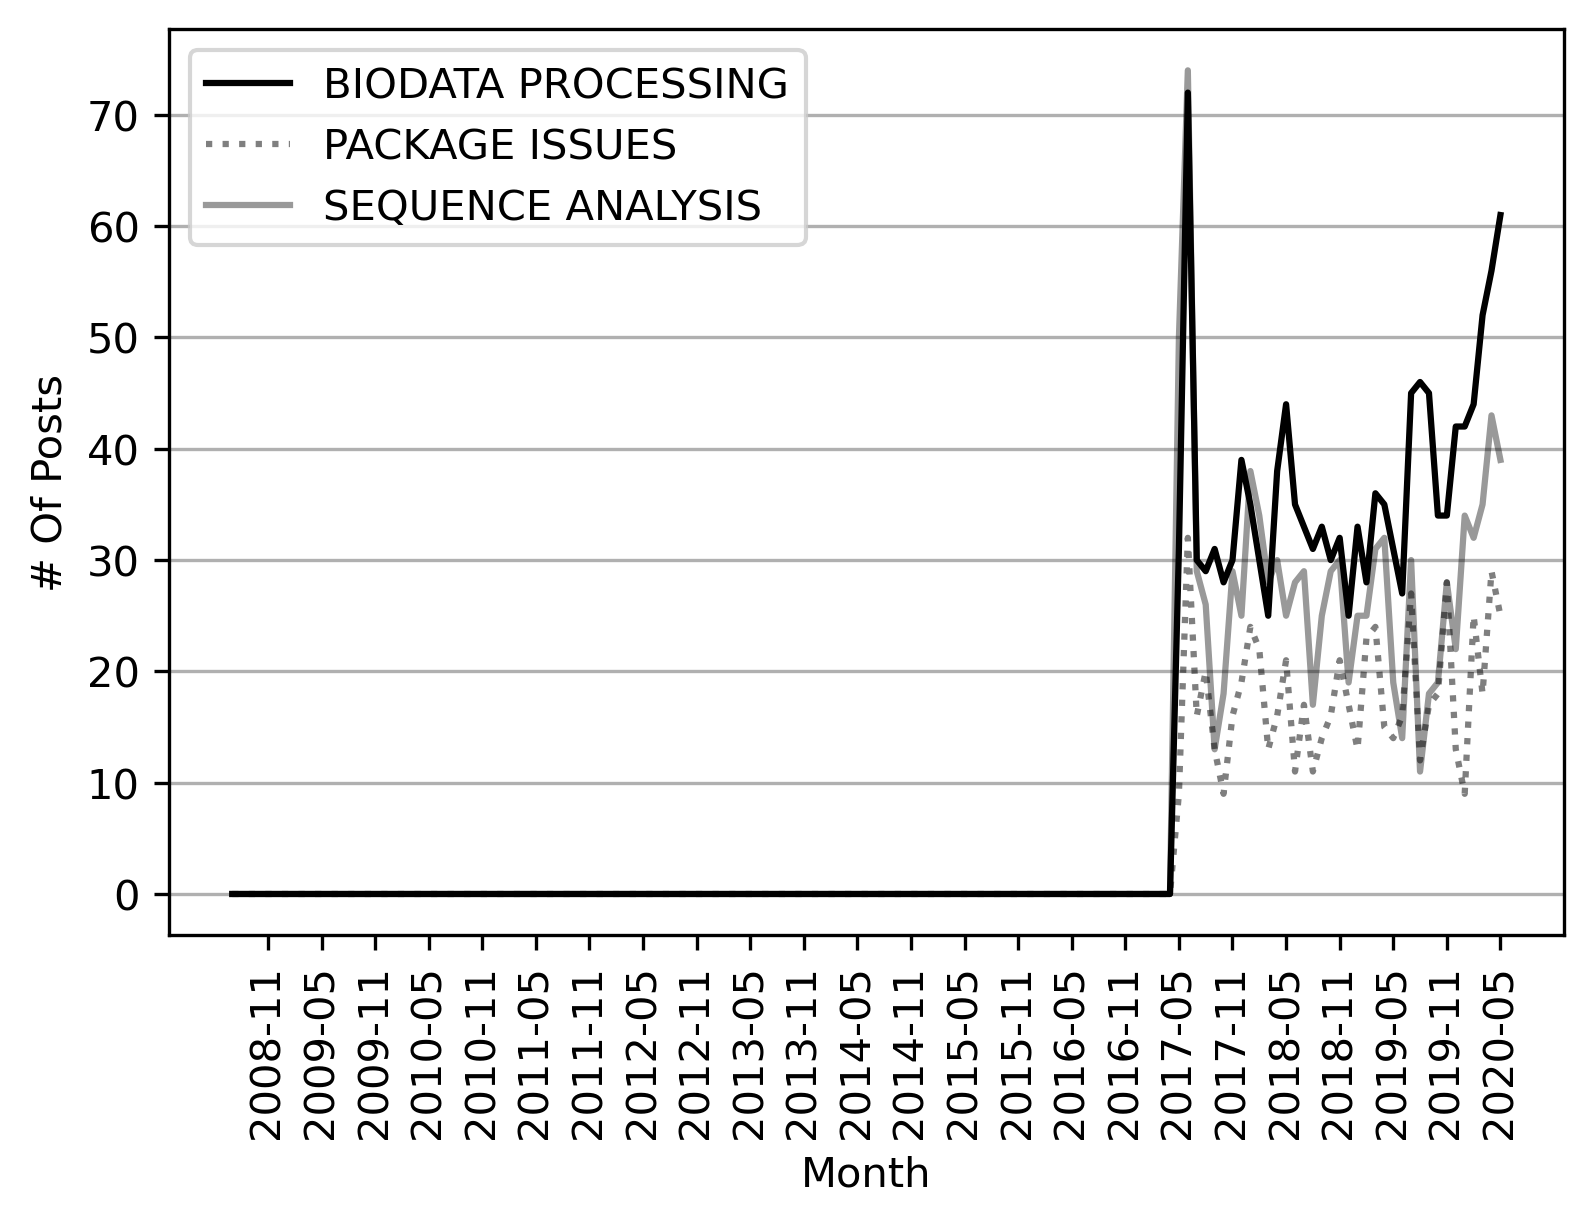

In [35]:
coords = []
for key, vals in heirarchy.items():
    x = [item[0] for item in impact_topic_dict[topic_id_dict[vals[0]]]]
    y = np.zeros(len(x))
    for val in vals:
        y += [item[1] for item in impact_topic_dict[topic_id_dict[val]]]
    coords.append({
        'Category' : key,
        'x' : x,
        'y' : y})

alpha =      [1,   0.5, 0.4, 0.5, 1, 1]
linestyles = ['-', ':', '-', '-.', ':', '--']
fig, ax = plt.subplots(dpi = 300)
x = coords[0]['x']
for idx in range(len(coords)):
    y = coords[idx]['y']
    ax.plot(
        x,
        y,
        color = 'k',
        alpha = alpha[idx],
        linestyle = linestyles[idx],
        label = coords[idx]['Category']
    )
ax.set_xlabel('Month')
ax.set_ylabel('# Of Posts')
ax.set_label('Absolute Growth of Bioinformatics Topics in SO')

# ax.set_ylim([-0.0125, .7])

ax.grid(True)
ax.xaxis.grid(False)

pos = np.arange(4, len(x), 6)
ax.axes.get_xaxis().set_ticks(pos)
ax.tick_params(axis = 'x', rotation = 90)

ax.legend(loc = 5, fontsize = 10)
ax.legend()
plt.savefig(os.path.join(cur_dir, 'Growth_NO_Cat_1.svg'), format = 'svg')

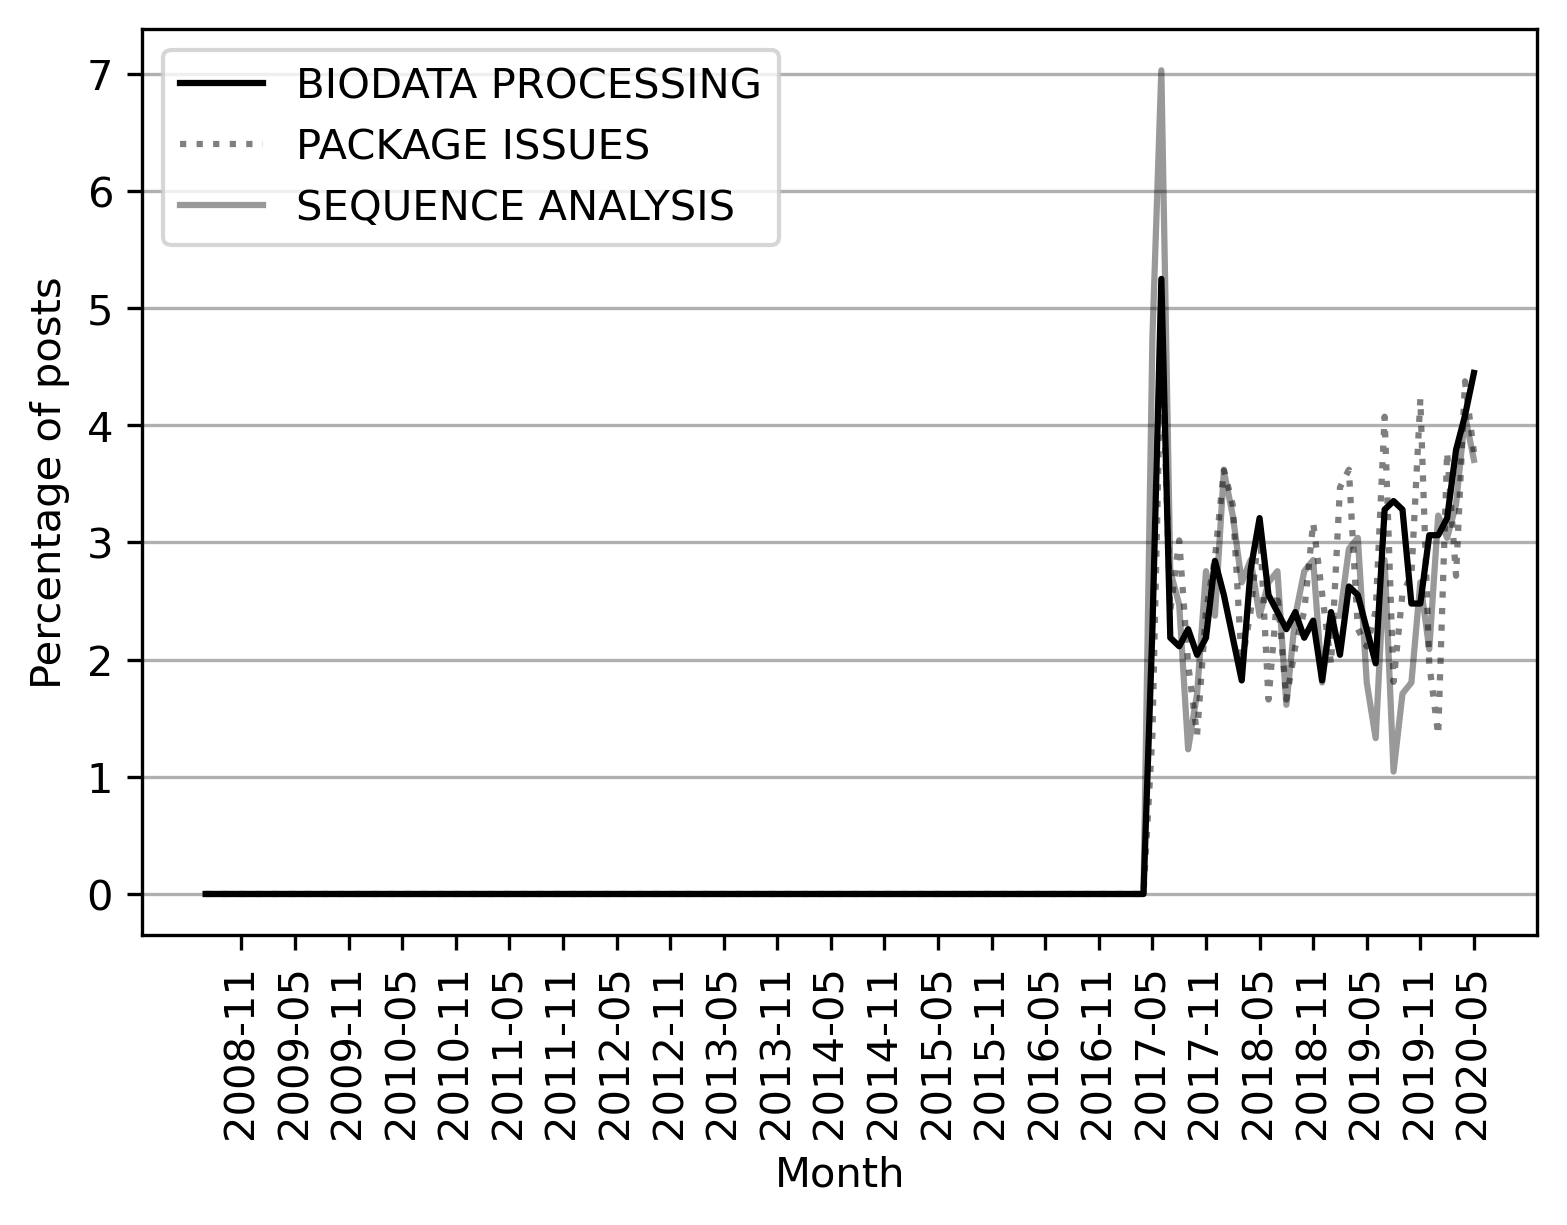

In [36]:
alpha =      [1,   0.5, 0.4, 0.5, 1, 1]
linestyles = ['-', ':', '-', '-.', ':', '--']
fig, ax = plt.subplots(dpi = 300)
x = coords[0]['x']
for idx in range(len(coords)):
    y = coords[idx]['y']
    ax.plot(
        x,
        np.divide(y , sum(y)) * 100,
        color = 'k',
        alpha = alpha[idx],
        linestyle = linestyles[idx],
        label = coords[idx]['Category']
    )
ax.set_xlabel('Month')
ax.set_ylabel('Percentage of posts')
ax.set_label('Percentile growth of Bioinformatics Toics in SO')

# ax.set_ylim([-0.0125, .7])

ax.grid(True)
ax.xaxis.grid(False)

pos = np.arange(4, len(x), 6)
ax.axes.get_xaxis().set_ticks(pos)
ax.tick_params(axis = 'x', rotation = 90)

ax.legend(loc = 5, fontsize = 10)
ax.legend()
plt.savefig(os.path.join(cur_dir, 'Growth_Percentile_Cat_1.svg'), format = 'svg')

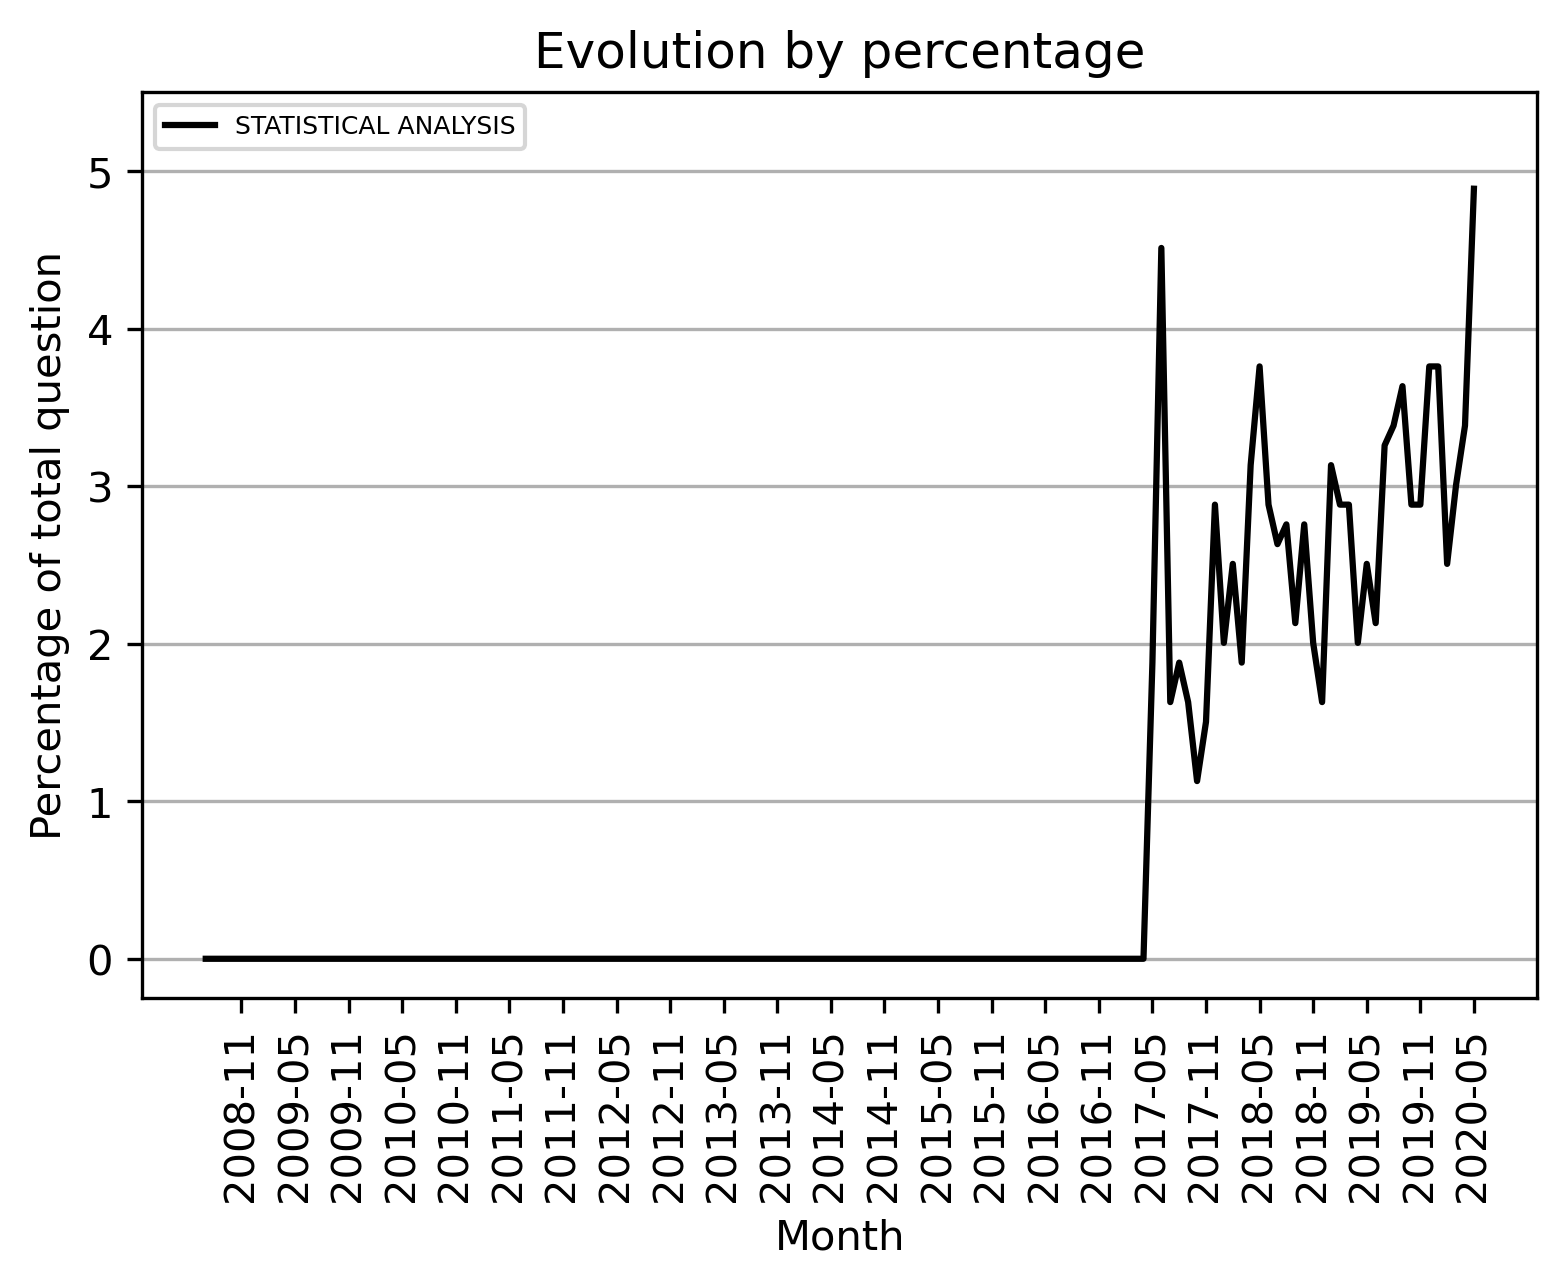

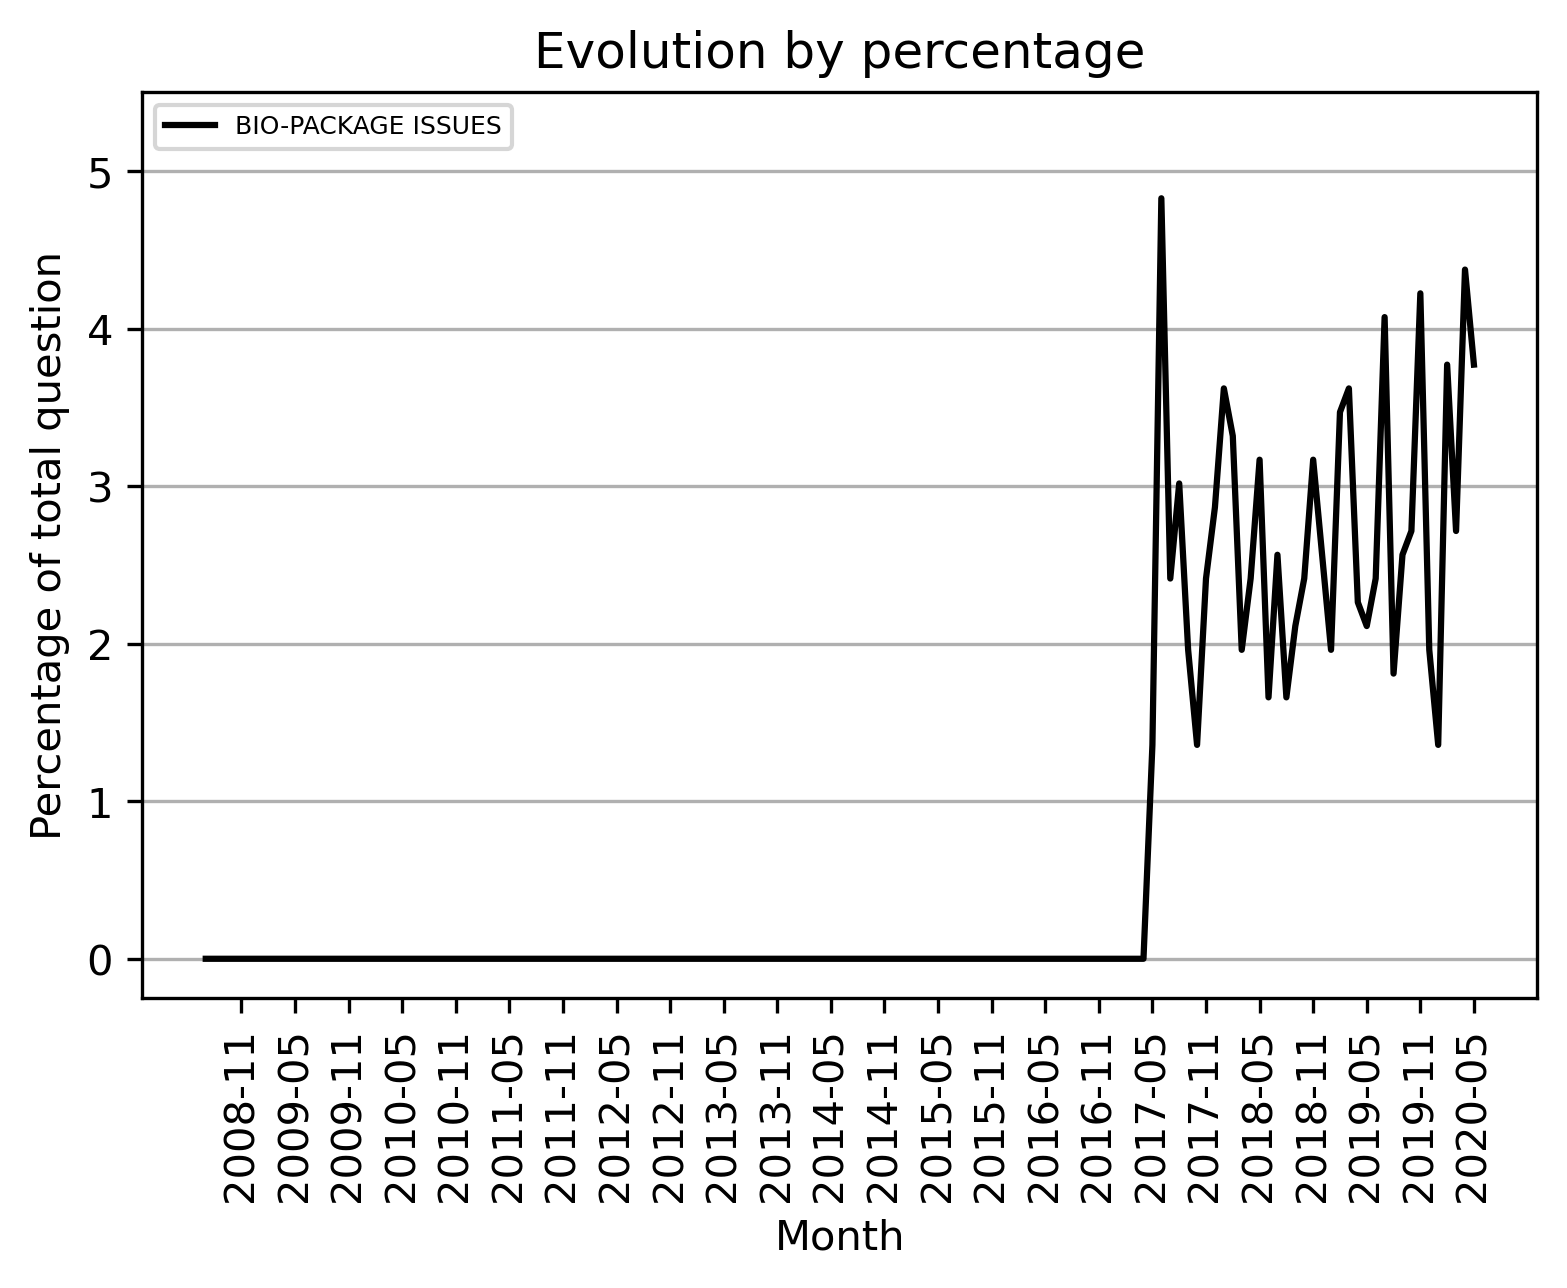

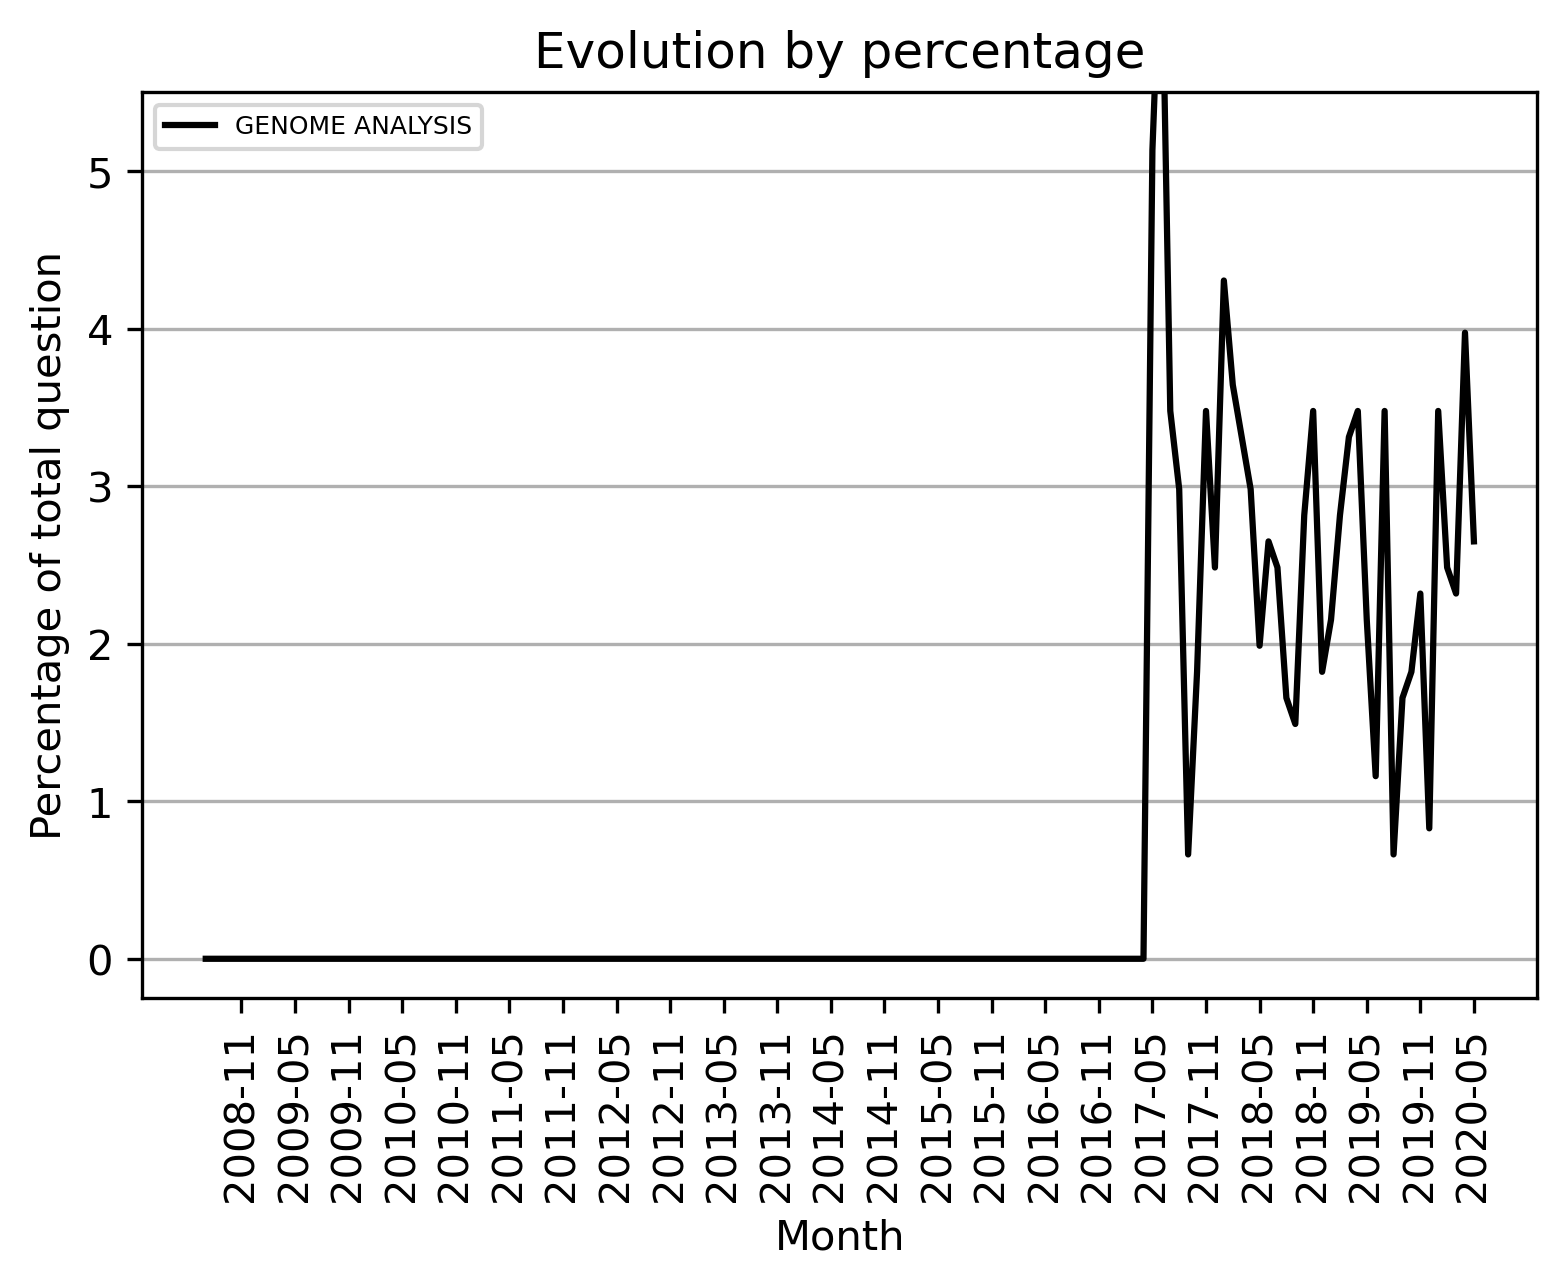

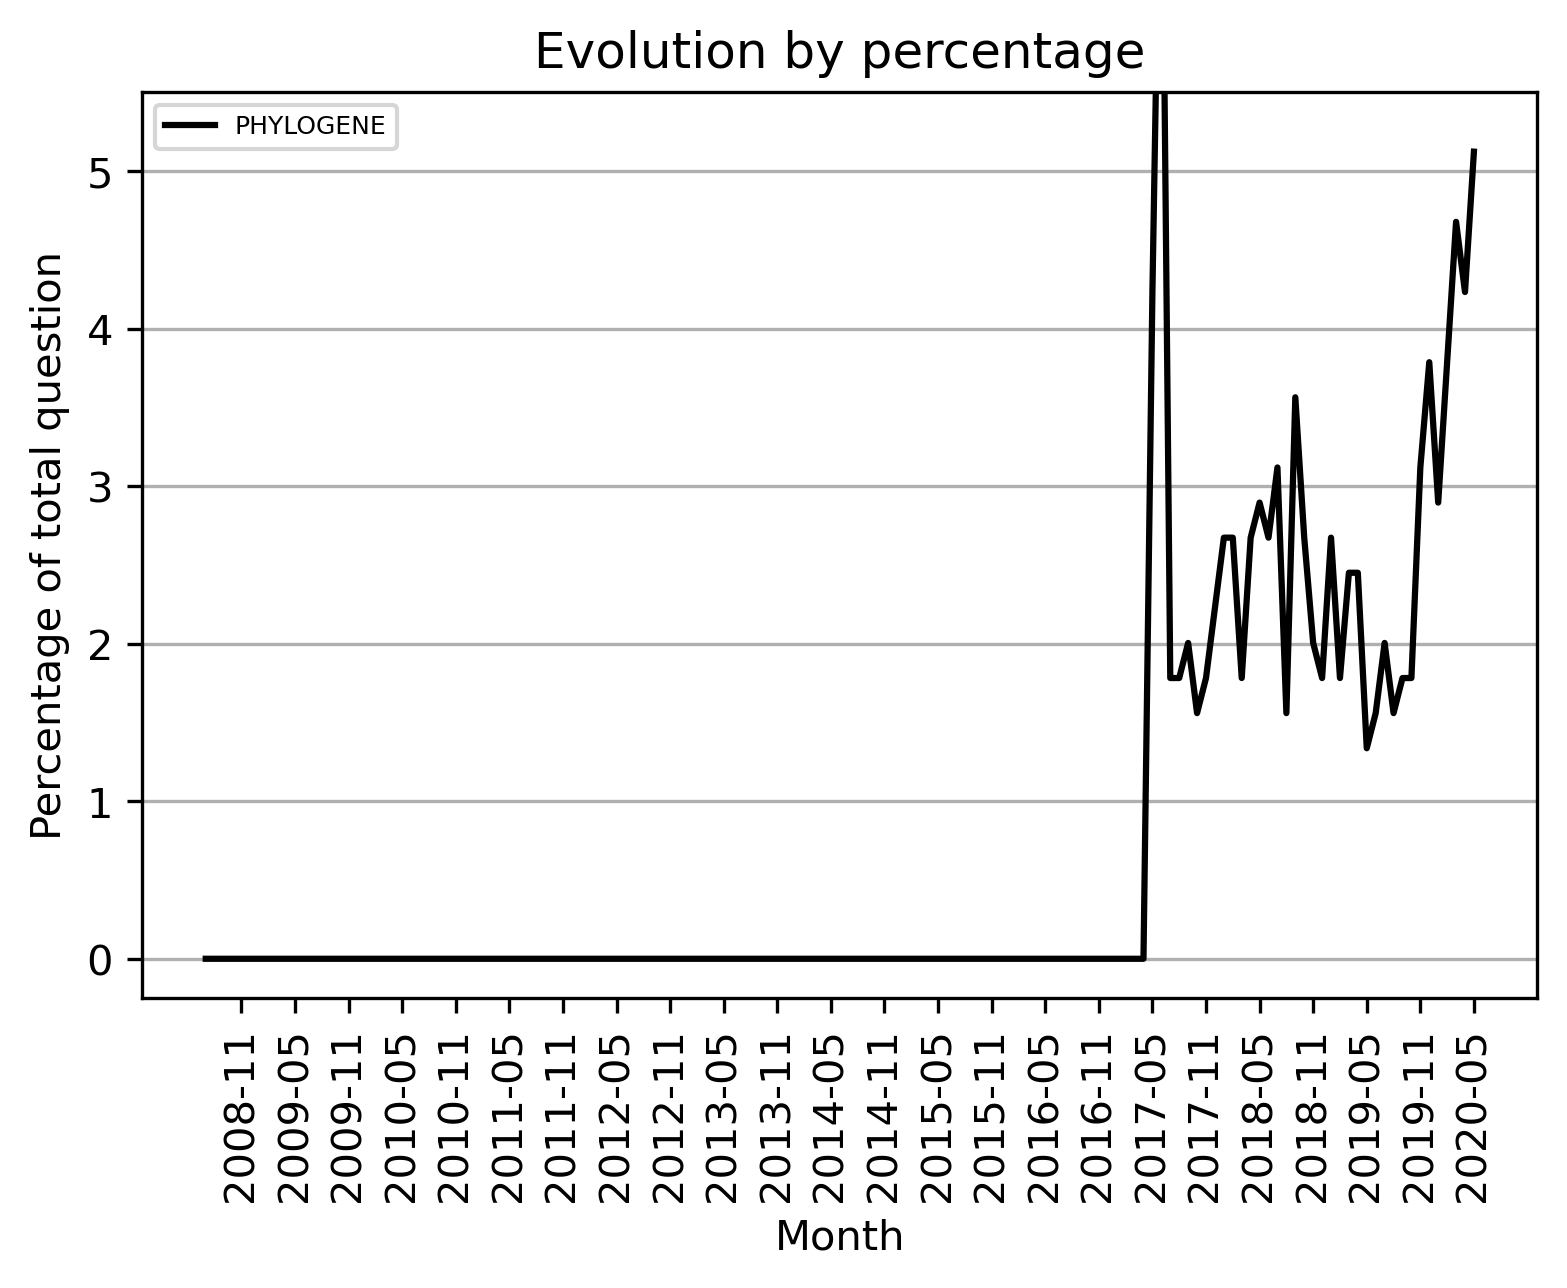

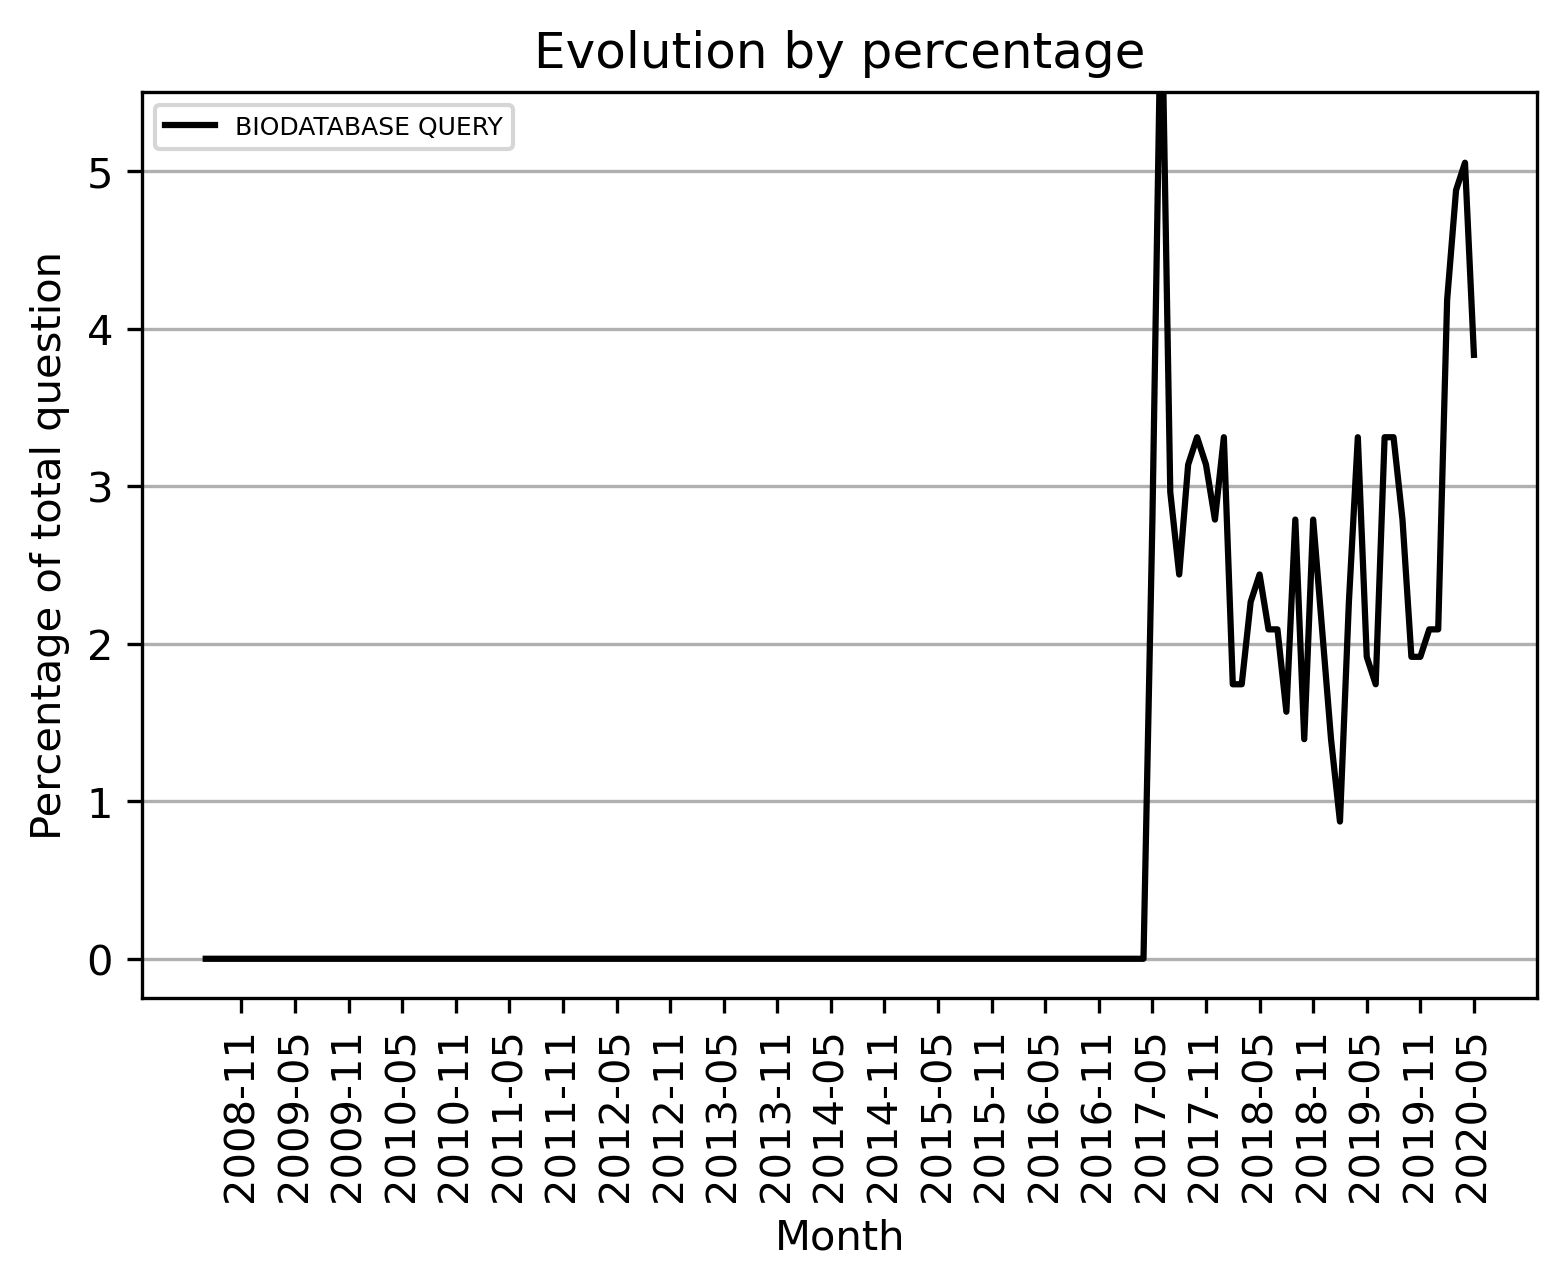

In [37]:
# color = ['#1D0F1D', '#AF17AF', '#A40DE9', '#572DC2', '#9AABD3',
#          '#5CBEE5', '#5CE5E2', '#4BDBAE', '#31E371', '#E15C2A',
#          '#B4100F', '#954160', '#CFDB4B', '#DB2B7C']
for i in range(len(topic_category_0)):
    fig, ax = plt.subplots(dpi = 300)

    ax.set_xlabel('Month')
    ax.set_ylabel('Percentage of total question')
    ax.set_title('Evolution by percentage')
    ax.set_ylim([-0.25, 5.5])
    
    
#     x = impact_all_question_percentage[0][0].tolist()
#     x = [item[0] for item in x]
#     ax.plot(
#         x,
#         impact_all_question_percentage[0][1],
#         color = 'b',
#         label = 'All Stackoverflow Question',
#         linestyle = '-.',
#         lw = 2
#     )
    
#     pos = np.arange(4, len(x), 6)
    
#     x = impact_corpora_percentage[0][0].tolist()
#     x = [item[0] for item in x]
#     ax.plot(
#         x,
#         impact_corpora_percentage[0][1],
#         color = 'r',
#         label = 'All Bioninformatics Question',
#         linestyle = '--',
#         lw = 2
#     )
    
    
    x = [item[0] for item in impact_topic_percentage_dict[i]]
    y = [item[1] for item in impact_topic_percentage_dict[i]]
    pos = np.arange(4, len(x), 6)
    
    ax.plot(
        x,
        y,
        color = 'black',
        label = topic_category_0[i],
        alpha = 1
    )
    
    ax.axes.get_xaxis().set_ticks(pos)
    ax.tick_params(axis = 'x', rotation = 90)
    ax.legend(loc = 2, fontsize = 6)
    
    ax.grid(True)
    ax.xaxis.grid(False)
    
    plt.savefig(os.path.join(cur_dir, 'M%d.svg' % i), format = 'svg')

In [38]:
def moving_avergae(list_, gap, starting_idx):
    ma_list = []

    sum_ = 0
    for idx in range(starting_idx + 1):
        sum_ += list_[idx]
    ma_list.append(sum_ / (starting_idx + 1))

    idx = starting_idx + 1

    while (idx + gap) < len(list_):
        sum_ = 0
        for j in range(gap):
            sum_ += list_[idx + j]
        ma_list.append(sum_ / gap)
        idx += gap

    if idx != gap + len(list_):
#         print(idx)
        sum_ = 0
        for i in range(idx, len(list_)):
            sum_ += list_[i]
        ma_list.append(sum_ / (len(list_) - idx))

    return ma_list

In [39]:
list_ = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
moving_avergae(list_, 2, 1)

[9.5, 7.5, 5.5, 3.5, 1.5]

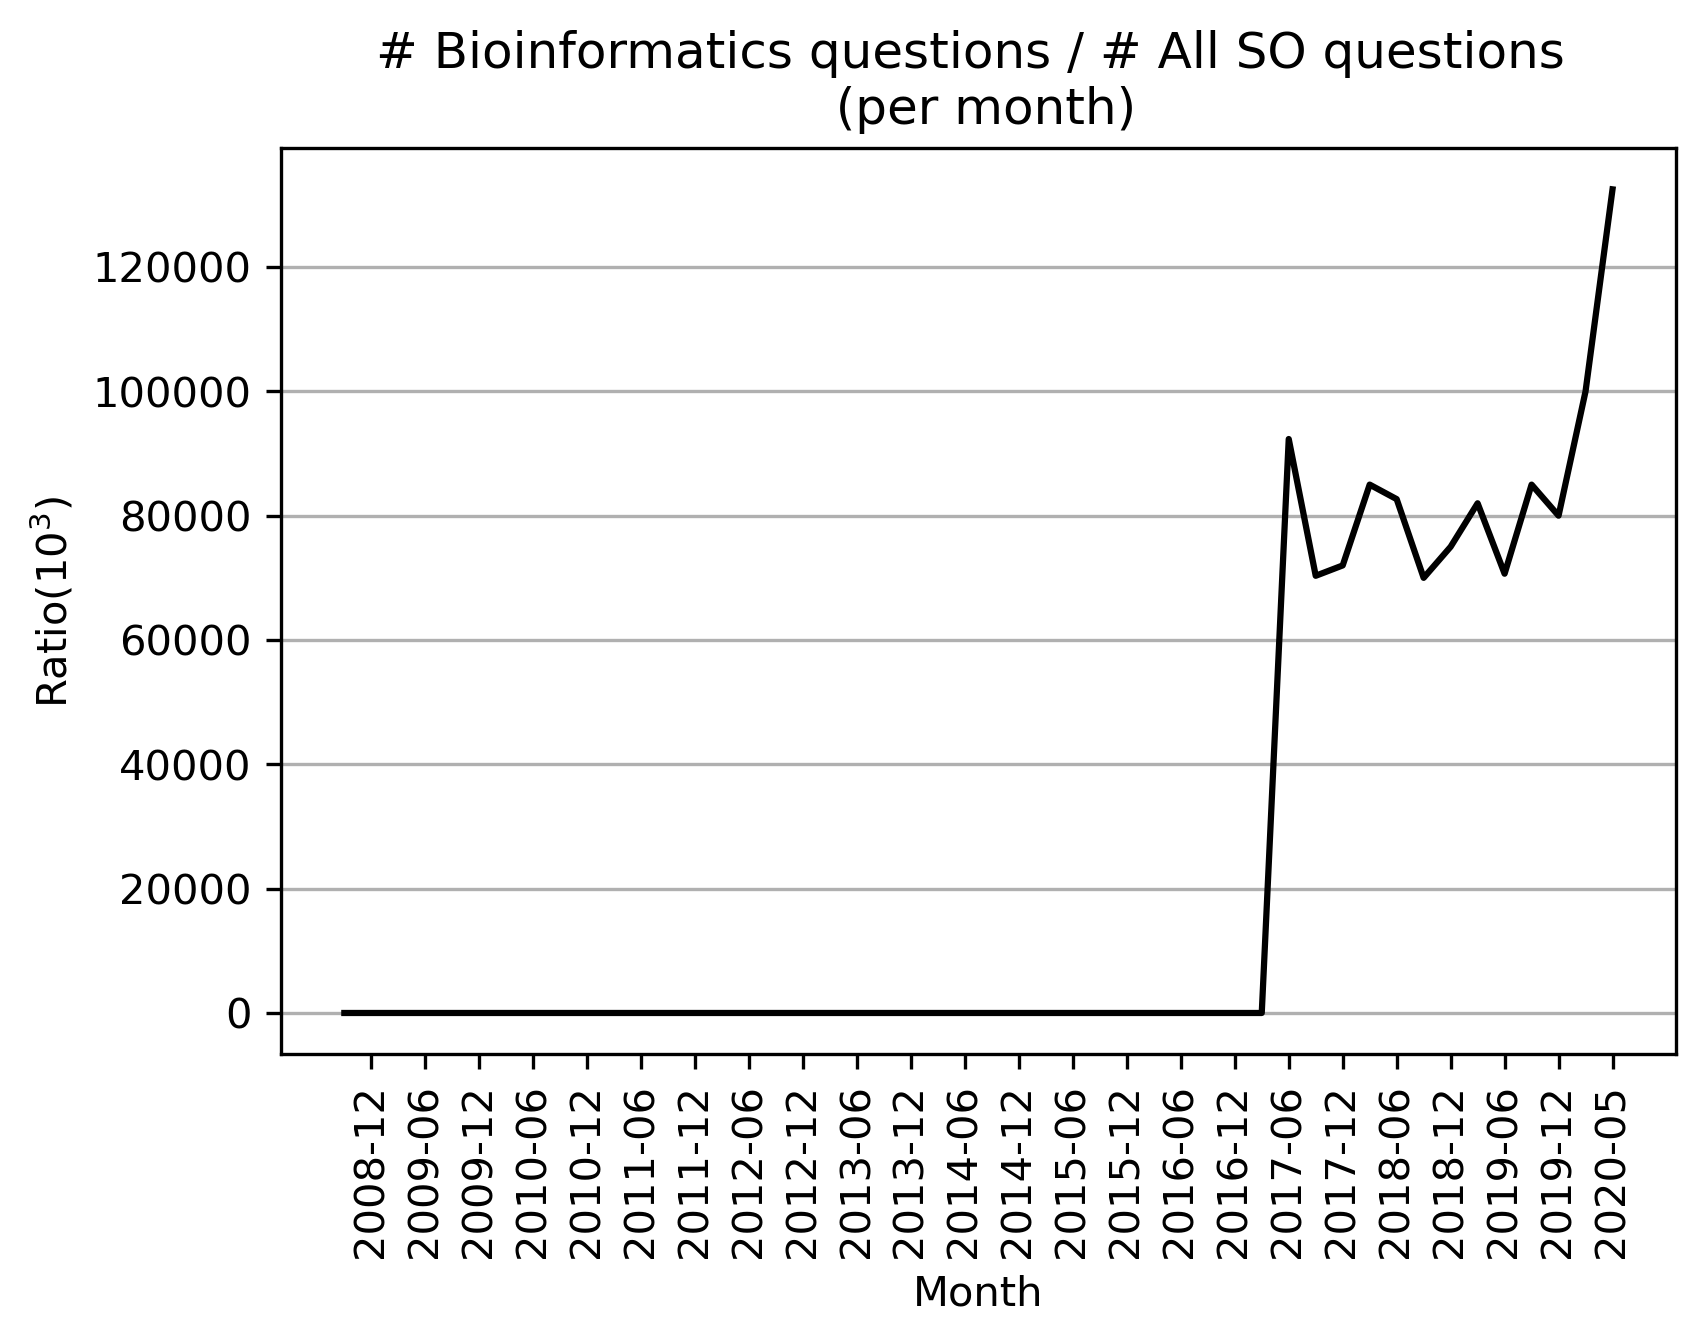

In [40]:
fig, ax = plt.subplots(dpi = 300)

ax.set_xlabel('Month')
ax.set_ylabel(r'Ratio($10^3$)')
ax.set_title('# Bioinformatics questions / # All SO questions \n (per month)')
# ax.set_ylim([-0.000025, 0.0006])

    
x = [item[0] for item in impact_corpora_dict[0]]
y1 = [item[1] for item in impact_corpora_dict[0]]
y2 = [item[1] for item in impact_all_question_dict[0]]

y1 = moving_avergae(y1, 3, 2)
y2 = moving_avergae(y2, 3, 2)

y = y1

month_selected = np.arange(2, len(x), 3)
if month_selected[-1] != len(x) - 1:
    month_selected = np.append(month_selected, len(x) - 1)
x = np.array(x)[month_selected]

pos = np.arange(1, len(x),2 )

ax.plot(
    x,
    np.array(y) * 1000,
    color = 'black',
#     label = 'Bioinformatics',
    alpha = 1
)

# ax.plot(
#     x,
#     y2,
#     color = 'black',
#     label = 'AllStackOverflow',
#     linestyle = ':',
#     alpha = 1
# )

ax.axes.get_xaxis().set_ticks(pos)
ax.tick_params(axis = 'x', rotation = 90)
# ax.legend(loc = 2, fontsize = 6)
    
ax.grid(True)
ax.xaxis.grid(False)

plt.savefig(os.path.join(cur_dir, 'Growth_Relative_Bioinformatics.svg'), format = 'svg')

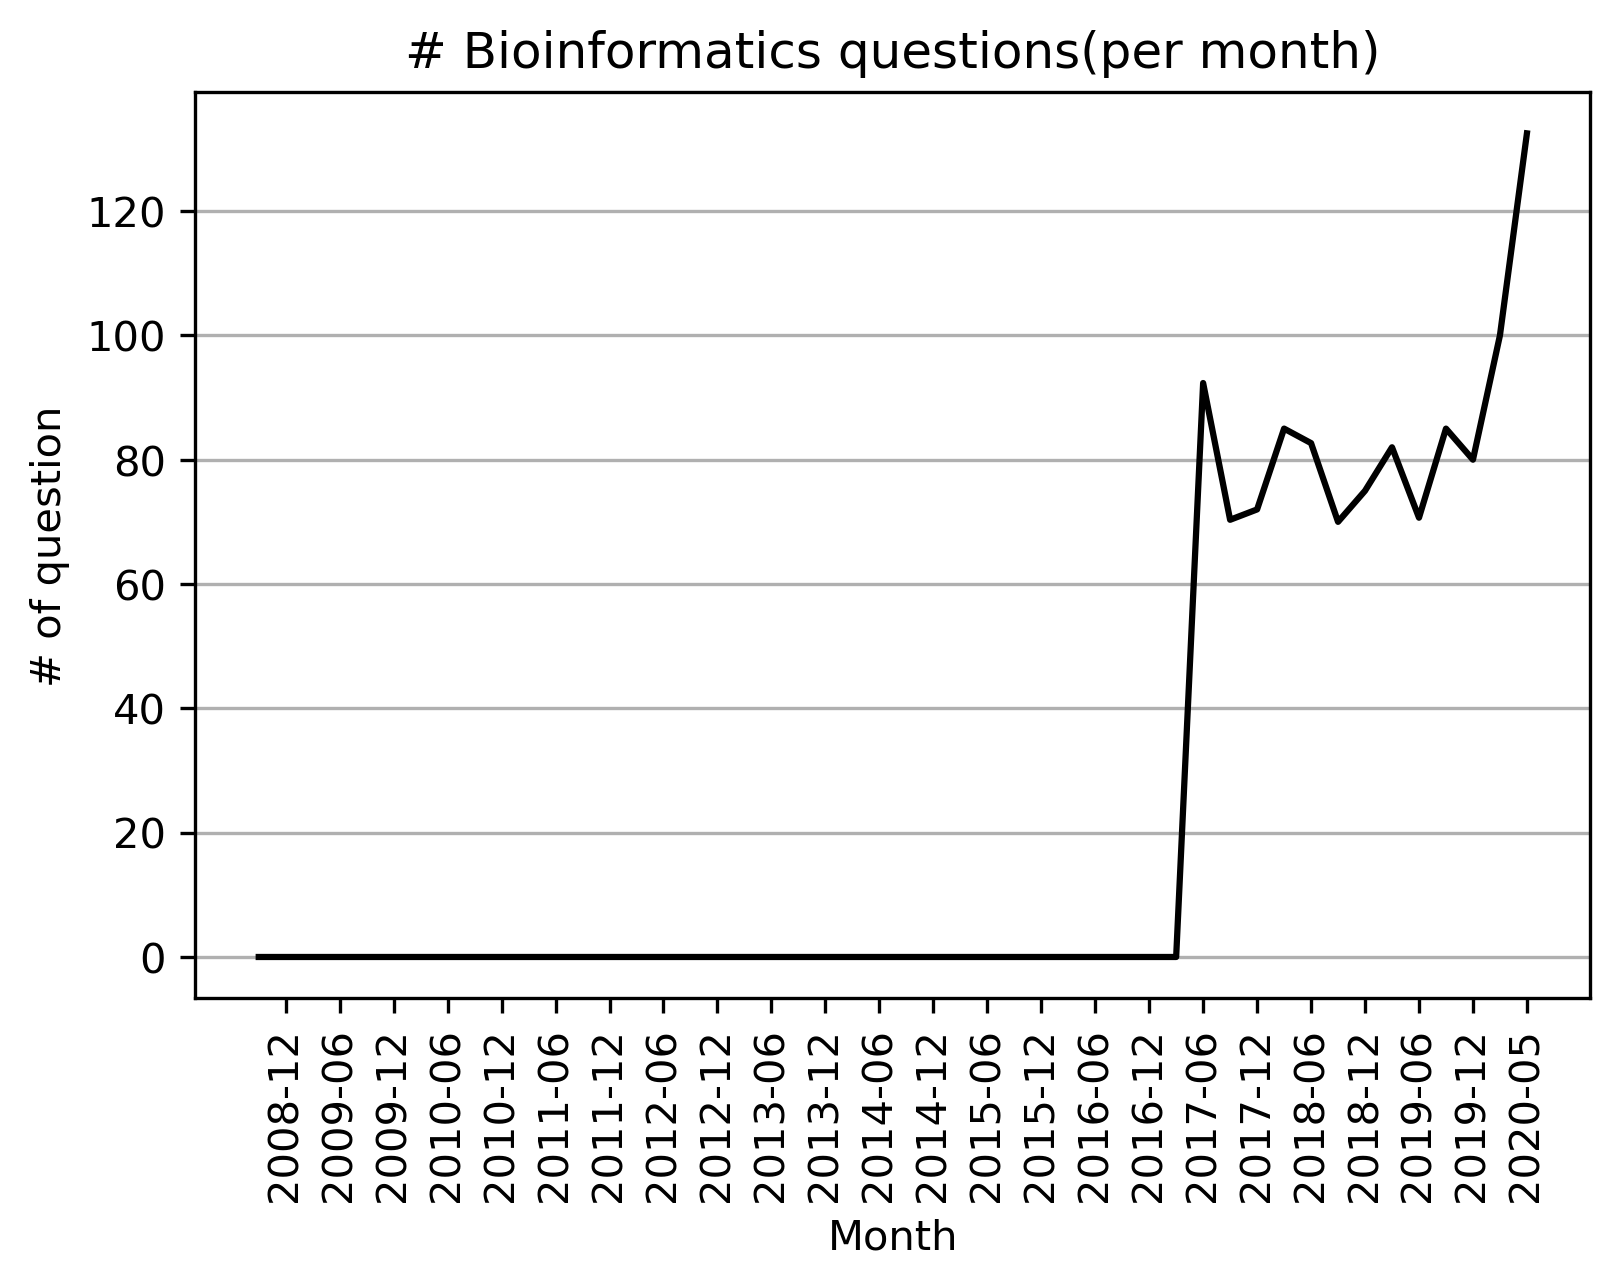

In [41]:
fig, ax = plt.subplots(dpi = 300)

ax.set_xlabel('Month')
ax.set_ylabel(r'# of question')
ax.set_title('# Bioinformatics questions(per month)')
# ax.set_ylim([-0.000025, 0.0006])

    
x = [item[0] for item in impact_corpora_dict[0]]
y1 = [item[1] for item in impact_corpora_dict[0]]
y2 = [item[1] for item in impact_all_question_dict[0]]

y1 = moving_avergae(y1, 3, 2)
y2 = moving_avergae(y2, 3, 2)

y = y1

month_selected = np.arange(2, len(x), 3)
if month_selected[-1] != len(x) - 1:
    month_selected = np.append(month_selected, len(x) - 1)
x = np.array(x)[month_selected]

pos = np.arange(1, len(x),2 )

ax.plot(
    x,
    y,
    color = 'black',
#     label = 'Bioinformatics',
    alpha = 1
)

# ax.plot(
#     x,
#     y2,
#     color = 'black',
#     label = 'AllStackOverflow',
#     linestyle = ':',
#     alpha = 1
# )

ax.axes.get_xaxis().set_ticks(pos)
ax.tick_params(axis = 'x', rotation = 90)
# ax.legend(loc = 2, fontsize = 6)
    
ax.grid(True)
ax.xaxis.grid(False)

plt.savefig(os.path.join(cur_dir, 'Growth_absolute_Bioinformatics.svg'), format = 'svg')

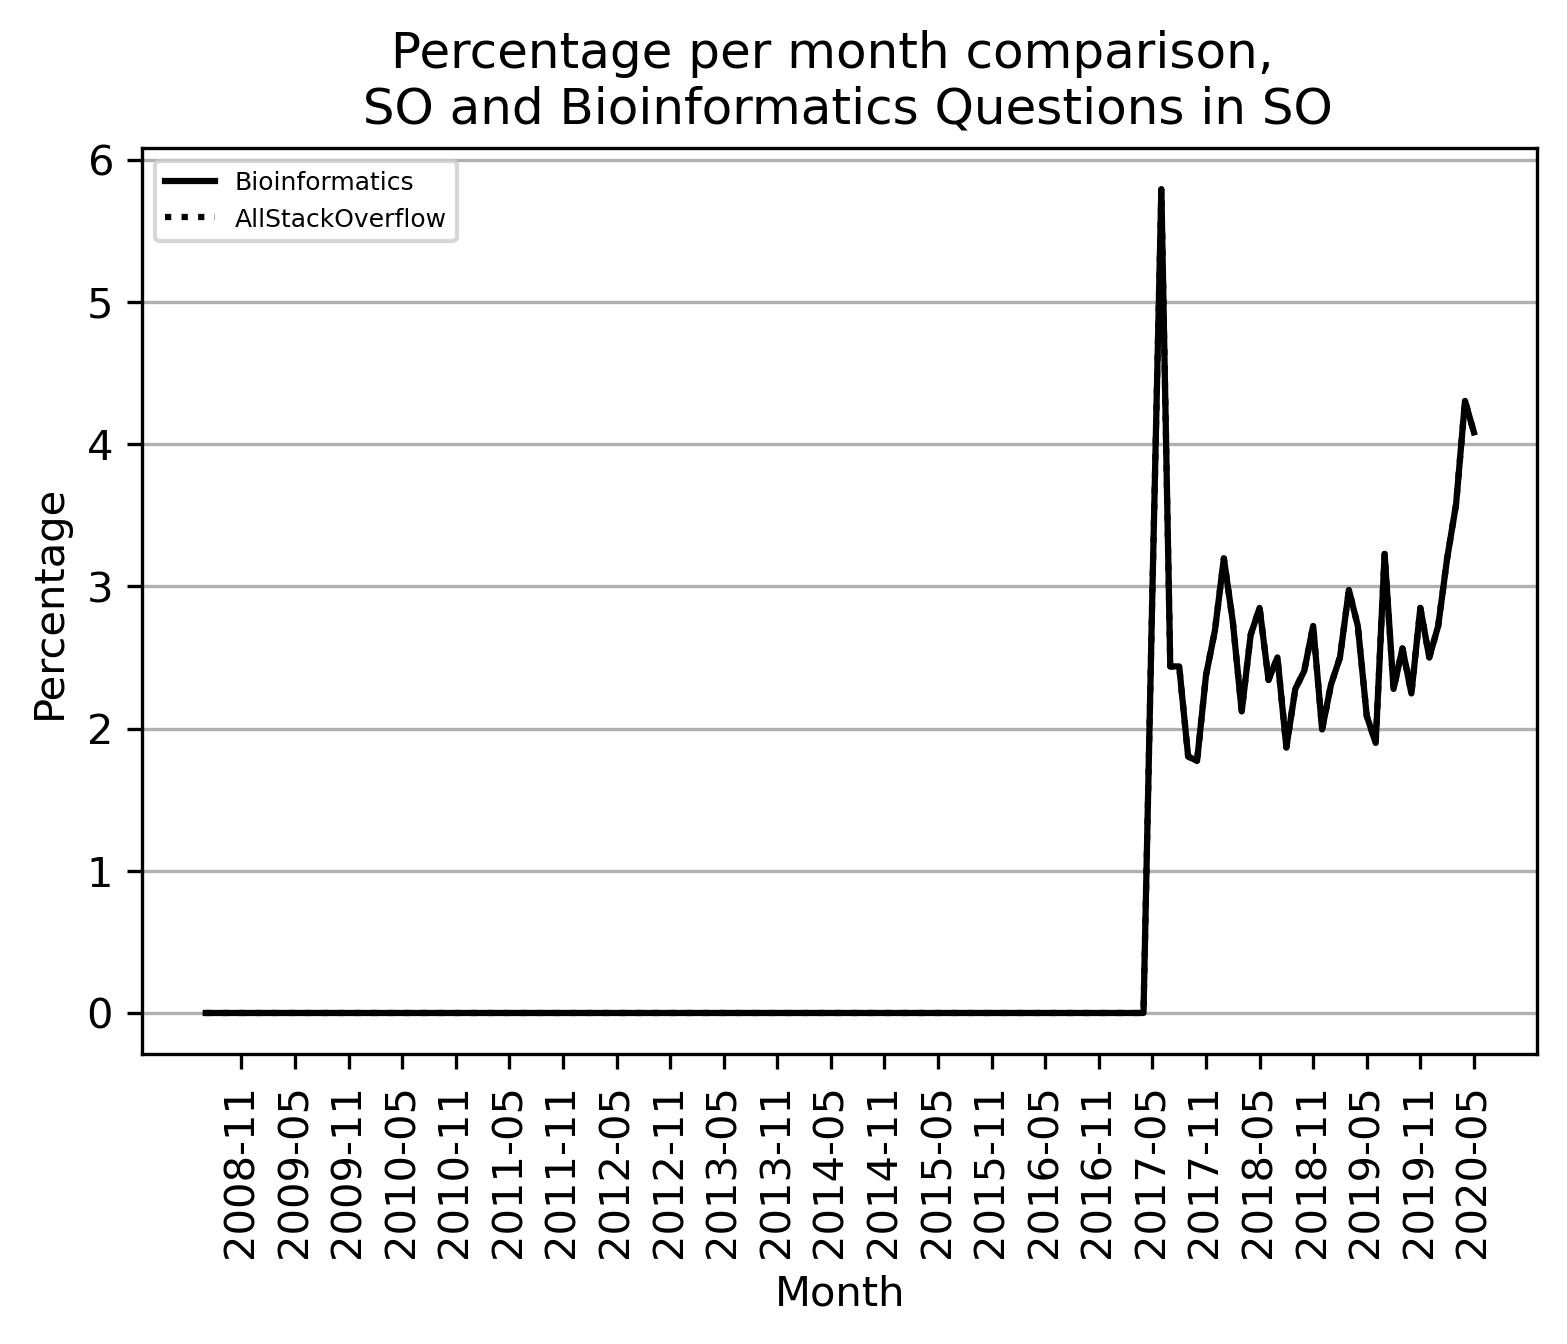

In [42]:
fig, ax = plt.subplots(dpi = 300)

ax.set_xlabel('Month')
ax.set_ylabel('Percentage')
ax.set_title('Percentage per month comparison, \n SO and Bioinformatics Questions in SO')
# ax.set_ylim([-0.25, 5.5])

    
x = [item[0] for item in impact_corpora_percentage_dict[0]]
y1 = [item[1] for item in impact_corpora_percentage_dict[0]]
y2 = [item[1] for item in impact_all_question_percentage_dict[0]]
pos = np.arange(4, len(x), 6)


ax.plot(
    x,
    y1,
    color = 'black',
    label = 'Bioinformatics',
    alpha = 1
)

ax.plot(
    x,
    y2,
    color = 'black',
    label = 'AllStackOverflow',
    linestyle = ':',
    alpha = 1
)

ax.axes.get_xaxis().set_ticks(pos)
ax.tick_params(axis = 'x', rotation = 90)
ax.legend(loc = 2, fontsize = 6)
    
ax.grid(True)
ax.xaxis.grid(False)

plt.savefig(os.path.join(cur_dir, 'Growth_Percentile_Bioinformatics.svg'), format = 'svg')

In [43]:
x_corpora = impact_corpora_percentage[0][0] 
x_all = impact_all_question_percentage[0][1]

In [44]:
x_corpora

array([['2017-05'],
       ['2017-06'],
       ['2017-07'],
       ['2017-08'],
       ['2017-09'],
       ['2017-10'],
       ['2017-11'],
       ['2017-12'],
       ['2018-01'],
       ['2018-02'],
       ['2018-03'],
       ['2018-04'],
       ['2018-05'],
       ['2018-06'],
       ['2018-07'],
       ['2018-08'],
       ['2018-09'],
       ['2018-10'],
       ['2018-11'],
       ['2018-12'],
       ['2019-01'],
       ['2019-02'],
       ['2019-03'],
       ['2019-04'],
       ['2019-05'],
       ['2019-06'],
       ['2019-07'],
       ['2019-08'],
       ['2019-09'],
       ['2019-10'],
       ['2019-11'],
       ['2019-12'],
       ['2020-01'],
       ['2020-02'],
       ['2020-03'],
       ['2020-04'],
       ['2020-05']], dtype=object)

In [45]:
# for idx in range(len(x_all)):
#     if x_all[idx] not in x_corpora:
#         if idx < len()
#         np.insert(impact_corpora[0][0], idx, x_all[idx])
#         np.insert(impact_corpora[0][1], idx, 0)    

In [46]:
# for i in range(len(impact_corpora[0][0])):
#     for j in range(len(impact_topic)):
#         if impact_corpora[0][0][i] not in impact_topic[j][0]:
#             if i < len(impact_topic[j][0]):
#                 impact_topic[j][0] = np.insert(
#                     impact_topic[j][0], i, impact_corpora[0][0][i])
#                 impact_topic[j][1] = np.insert(
#                     impact_topic[j][1], i, 0)
#             else:
#                 impact_topic[j][0] = np.append(
#                     impact_topic[j][0], impact_corpora[0][0][i])
#                 impact_topic[j][1] = np.append(
#                     impact_topic[j][1], 0)

In [47]:
# for i in range(len(impact_all_question[0][0])):
#     for j in range(len(impact_topic)):
#         if impact_all_question[0][0][i] not in impact_topic[j][0]:
#             if i < len(impact_topic[j][0]):
#                 impact_topic[j][0] = np.insert(
#                     impact_topic[j][0], i, impact_all_question[0][0][i])
#                 impact_topic[j][1] = np.insert(
#                     impact_topic[j][1], i, 0)
#             else:
#                 impact_topic[j][0] = np.append(
#                     impact_topic[j][0], impact_all_question[0][0][i])
#                 impact_topic[j][1] = np.append(
#                     impact_topic[j][1], 0)

# Impact

In [48]:
doctopics = open(os.path.join(cur_dir, 'doctopics.txt'))
doctopics = doctopics.readlines()
theta = []
for doctopic in doctopics:
    temp = doctopic.split()[2:]
    theta.append([float(t) for t in temp])

In [49]:
mapping = _pickle.load(
    open(
        os.path.join(input_dir, 'MapUniqueIdsToPostIds.pkl'), 'rb'))

In [50]:
final_theta = {}
for idx in range(len(theta)):
    final_theta[mapping[idx]['Id']] = theta[idx]

In [53]:
design_info = pd.read_csv(
    os.path.join(
        post_dir, 'DesignPostInformation.csv'))
questions = design_info[design_info['PostTypeId'] == 1]
print(questions.shape)

open_questions = questions[questions['ClosedDate'].isna()]
print(open_questions.shape)

oqid = open_questions['PostId'].to_numpy()

acc_ans_id = list(open_questions['AcceptedAnswerId'].dropna())
acc_ans_id = [pid[2:-1] for pid in acc_ans_id]

acc_ans = design_info[design_info['PostId'].isin(acc_ans_id)]
print(acc_ans.shape)

documents = pd.concat([open_questions, acc_ans])
documents.shape

(3160, 14)
(3088, 14)
(1473, 14)


(4561, 14)

In [54]:
doc_month = []

doc_cds = documents[['PostId', 'CreationDate']].to_numpy()

# doc_cd = corpora.reshape(len(doc_cd), 1)

doc_cd_bin = {}
# impact_corpora_percentage = []
for idx in range(doc_cds.shape[0]):
    cd = doc_cds[idx][1][2:-1]
    cd = '-'.join(cd.split('T')[0].split('-')[0:2])    
    if cd in doc_cd_bin:
        doc_cd_bin[cd].append(doc_cds[idx][0])
    else:
        doc_cd_bin[cd] = []
        doc_cd_bin[cd].append(doc_cds[idx][0])
len(doc_cd_bin)

37

In [55]:
# for month in month_range:
#     if month not in doc_cd_bin:
#         doc_cd_bin[month] = []

In [56]:
impact = {}
for month, pids in doc_cd_bin.items():
    for pid in pids:
#         if not isinstance(pid, int):
#             print(pid)
        for idx in range(len(final_theta[pid])):
            if idx not in impact:
                impact[idx] = {}
            if month not in impact[idx]:
                 impact[idx][month] = []     
            impact[idx][month].append(final_theta[pid][idx])

In [57]:
pprint(impact)

{0: {'2017-05': [0.14473684210526316,
                 0.14285714285714285,
                 0.15789473684210525,
                 0.12345679012345678,
                 0.1935483870967742,
                 0.16417910447761194,
                 0.13636363636363635,
                 0.13924050632911392,
                 0.13186813186813187,
                 0.3103448275862069,
                 0.17073170731707318,
                 0.13253012048192772,
                 0.25287356321839083,
                 0.32,
                 0.20689655172413793,
                 0.23809523809523808,
                 0.27586206896551724,
                 0.19101123595505617,
                 0.15695067264573992,
                 0.15,
                 0.30434782608695654,
                 0.18055555555555555,
                 0.14492753623188406,
                 0.35714285714285715,
                 0.16346153846153846,
                 0.14925373134328357,
                 0.18421052631578946,
      

                 0.10852713178294573,
                 0.12631578947368421,
                 0.2328767123287671,
                 0.25842696629213485,
                 0.288,
                 0.3217391304347826,
                 0.1643835616438356,
                 0.28125,
                 0.1566265060240964,
                 0.20430107526881722,
                 0.18867924528301888,
                 0.16666666666666666,
                 0.18571428571428572,
                 0.19298245614035087,
                 0.15714285714285714,
                 0.0935672514619883,
                 0.14864864864864866,
                 0.1864406779661017,
                 0.11214953271028037,
                 0.06666666666666667,
                 0.14814814814814814,
                 0.24375,
                 0.2777777777777778,
                 0.18867924528301888,
                 0.28654970760233917,
                 0.2028985507246377,
                 0.1935483870967742,
                 0.18

                 0.24675324675324675,
                 0.1527777777777778,
                 0.19402985074626866,
                 0.1513157894736842,
                 0.11214953271028037,
                 0.3508771929824561,
                 0.3910891089108911,
                 0.20754716981132076,
                 0.20689655172413793,
                 0.4787234042553192,
                 0.1875,
                 0.22033898305084745,
                 0.10909090909090909],
     '2018-06': [0.16393442622950818,
                 0.1643835616438356,
                 0.25,
                 0.12941176470588237,
                 0.14953271028037382,
                 0.20833333333333334,
                 0.17,
                 0.14606741573033707,
                 0.15789473684210525,
                 0.12871287128712872,
                 0.14634146341463414,
                 0.15942028985507245,
                 0.18032786885245902,
                 0.14563106796116504,
                 0.229

                 0.12941176470588237,
                 0.11702127659574468,
                 0.4583333333333333,
                 0.15853658536585366,
                 0.4752475247524752,
                 0.4,
                 0.1523809523809524,
                 0.20634920634920634,
                 0.15942028985507245,
                 0.20967741935483872,
                 0.3490566037735849,
                 0.2,
                 0.22784810126582278,
                 0.13402061855670103,
                 0.3875,
                 0.25742574257425743,
                 0.275,
                 0.24778761061946902,
                 0.19117647058823528,
                 0.17204301075268819,
                 0.15503875968992248,
                 0.17391304347826086,
                 0.14736842105263157,
                 0.17222222222222222,
                 0.14285714285714285,
                 0.18840579710144928,
                 0.16666666666666666,
                 0.2911392405063291,


                 0.13580246913580246,
                 0.1791044776119403,
                 0.04983388704318937,
                 0.5161290322580645,
                 0.3563218390804598,
                 0.3394495412844037,
                 0.18421052631578946,
                 0.2556390977443609,
                 0.21311475409836064,
                 0.13580246913580246,
                 0.10989010989010989,
                 0.2875,
                 0.2711864406779661,
                 0.1414141414141414,
                 0.36363636363636365,
                 0.32558139534883723,
                 0.15294117647058825,
                 0.20454545454545456,
                 0.2719298245614035,
                 0.4397163120567376,
                 0.34523809523809523,
                 0.3711340206185567,
                 0.06159420289855073,
                 0.13253012048192772,
                 0.4605263157894737,
                 0.41904761904761906,
                 0.21818181818181817

 1: {'2017-05': [0.25,
                 0.13186813186813187,
                 0.15789473684210525,
                 0.19753086419753085,
                 0.20967741935483872,
                 0.16417910447761194,
                 0.3181818181818182,
                 0.13924050632911392,
                 0.23076923076923078,
                 0.10344827586206896,
                 0.17073170731707318,
                 0.21686746987951808,
                 0.1724137931034483,
                 0.14666666666666667,
                 0.09482758620689655,
                 0.15476190476190477,
                 0.1724137931034483,
                 0.11235955056179775,
                 0.05829596412556054,
                 0.225,
                 0.10144927536231885,
                 0.1388888888888889,
                 0.2463768115942029,
                 0.17346938775510204,
                 0.125,
                 0.23880597014925373,
                 0.15789473684210525,
                 0.184

                 0.1794871794871795,
                 0.5854922279792746,
                 0.1875,
                 0.17721518987341772,
                 0.2972972972972973,
                 0.20967741935483872,
                 0.14492753623188406,
                 0.21052631578947367],
     '2018-03': [0.2601626016260163,
                 0.2268041237113402,
                 0.16346153846153846,
                 0.20512820512820512,
                 0.14606741573033707,
                 0.17777777777777778,
                 0.11458333333333333,
                 0.2692307692307692,
                 0.15555555555555556,
                 0.1368421052631579,
                 0.18811881188118812,
                 0.5314009661835749,
                 0.11578947368421053,
                 0.2736842105263158,
                 0.16666666666666666,
                 0.16393442622950818,
                 0.2,
                 0.1951219512195122,
                 0.19480519480519481,
            

                 0.13131313131313133,
                 0.1092436974789916,
                 0.1623931623931624,
                 0.13580246913580246,
                 0.09917355371900827,
                 0.5210084033613446,
                 0.15037593984962405,
                 0.23076923076923078,
                 0.2513089005235602,
                 0.05191256830601093,
                 0.1694915254237288,
                 0.21428571428571427,
                 0.3026315789473684,
                 0.15384615384615385,
                 0.14772727272727273,
                 0.15492957746478872,
                 0.25,
                 0.14606741573033707,
                 0.102803738317757,
                 0.1411764705882353,
                 0.13903743315508021,
                 0.10256410256410256,
                 0.20689655172413793,
                 0.14285714285714285,
                 0.09195402298850575,
                 0.24050632911392406,
                 0.12087912087912088

     '2019-07': [0.27848101265822783,
                 0.2903225806451613,
                 0.15625,
                 0.10112359550561797,
                 0.13924050632911392,
                 0.13157894736842105,
                 0.3263157894736842,
                 0.2222222222222222,
                 0.25252525252525254,
                 0.24,
                 0.1875,
                 0.08465608465608465,
                 0.0728476821192053,
                 0.267515923566879,
                 0.1827956989247312,
                 0.4,
                 0.140625,
                 0.2833333333333333,
                 0.28125,
                 0.1,
                 0.16853932584269662,
                 0.14705882352941177,
                 0.22602739726027396,
                 0.26548672566371684,
                 0.25675675675675674,
                 0.22727272727272727,
                 0.25,
                 0.32,
                 0.37662337662337664,
                 0.206521739130

                 0.11403508771929824,
                 0.07051282051282051,
                 0.1276595744680851,
                 0.3902439024390244,
                 0.21052631578947367,
                 0.2465753424657534,
                 0.11578947368421053,
                 0.125,
                 0.3787878787878788,
                 0.24675324675324675,
                 0.234375,
                 0.21153846153846154,
                 0.22033898305084745,
                 0.2033898305084746,
                 0.2318840579710145,
                 0.21904761904761905,
                 0.3829787234042553,
                 0.39823008849557523,
                 0.2714285714285714,
                 0.16666666666666666,
                 0.26744186046511625,
                 0.18518518518518517,
                 0.19230769230769232,
                 0.25555555555555554,
                 0.2676056338028169,
                 0.11428571428571428,
                 0.1875,
                 0.24

                 0.14705882352941177,
                 0.13157894736842105,
                 0.14166666666666666,
                 0.24390243902439024,
                 0.13740458015267176,
                 0.2236842105263158,
                 0.1623931623931624,
                 0.2692307692307692,
                 0.1262135922330097,
                 0.18518518518518517,
                 0.46113989637305697,
                 0.2,
                 0.34513274336283184,
                 0.08403361344537816,
                 0.17142857142857143,
                 0.16831683168316833,
                 0.2261904761904762,
                 0.41025641025641024,
                 0.08970099667774087,
                 0.2553191489361702,
                 0.16216216216216217,
                 0.16363636363636364,
                 0.1896551724137931,
                 0.1507537688442211,
                 0.16129032258064516,
                 0.18867924528301888,
                 0.2111111111111111,

                 0.1744186046511628,
                 0.14864864864864866,
                 0.1935483870967742,
                 0.28378378378378377,
                 0.22857142857142856,
                 0.24,
                 0.23076923076923078,
                 0.17721518987341772,
                 0.1271186440677966,
                 0.22115384615384615,
                 0.11711711711711711,
                 0.2037037037037037,
                 0.375,
                 0.2345679012345679,
                 0.2920353982300885,
                 0.23529411764705882,
                 0.11242603550295859,
                 0.22857142857142856,
                 0.24836601307189543,
                 0.18181818181818182,
                 0.17543859649122806],
     '2017-12': [0.09803921568627451,
                 0.23880597014925373,
                 0.125,
                 0.13924050632911392,
                 0.36,
                 0.15384615384615385,
                 0.3333333333333333,


                 0.18055555555555555,
                 0.41284403669724773,
                 0.28448275862068967,
                 0.14814814814814814,
                 0.18947368421052632,
                 0.16666666666666666,
                 0.171875,
                 0.17647058823529413,
                 0.3283582089552239,
                 0.29292929292929293,
                 0.14457831325301204,
                 0.2465753424657534,
                 0.10526315789473684,
                 0.11971830985915492,
                 0.075,
                 0.125,
                 0.18333333333333332,
                 0.08496732026143791,
                 0.20689655172413793,
                 0.07920792079207921,
                 0.1518987341772152,
                 0.1111111111111111,
                 0.09482758620689655,
                 0.13414634146341464,
                 0.17777777777777778,
                 0.28169014084507044,
                 0.19736842105263158,
                 

                 0.11827956989247312,
                 0.18032786885245902,
                 0.11403508771929824,
                 0.15492957746478872,
                 0.2987012987012987,
                 0.11188811188811189,
                 0.3373493975903614,
                 0.27710843373493976,
                 0.17391304347826086,
                 0.1,
                 0.16842105263157894,
                 0.2054794520547945,
                 0.16216216216216217,
                 0.20652173913043478,
                 0.4154929577464789,
                 0.18487394957983194,
                 0.3557692307692308,
                 0.14285714285714285,
                 0.19230769230769232,
                 0.23529411764705882,
                 0.12149532710280374,
                 0.17142857142857143,
                 0.14736842105263157,
                 0.21052631578947367,
                 0.12048192771084337,
                 0.14925373134328357,
                 0.26829268292682

                 0.125,
                 0.17391304347826086,
                 0.14102564102564102,
                 0.11702127659574468,
                 0.11956521739130435,
                 0.0845771144278607,
                 0.2361111111111111,
                 0.21333333333333335,
                 0.45652173913043476,
                 0.3135593220338983,
                 0.14583333333333334,
                 0.14414414414414414,
                 0.30851063829787234,
                 0.11578947368421053,
                 0.37254901960784315,
                 0.12745098039215685,
                 0.28,
                 0.17333333333333334,
                 0.11956521739130435,
                 0.13636363636363635,
                 0.19230769230769232,
                 0.12371134020618557,
                 0.06584362139917696,
                 0.22297297297297297,
                 0.15151515151515152,
                 0.24390243902439024,
                 0.1518987341772152,
       

 3: {'2017-05': [0.2631578947368421,
                 0.24175824175824176,
                 0.17894736842105263,
                 0.37037037037037035,
                 0.22580645161290322,
                 0.208955223880597,
                 0.20454545454545456,
                 0.20253164556962025,
                 0.10989010989010989,
                 0.31896551724137934,
                 0.17073170731707318,
                 0.1927710843373494,
                 0.19540229885057472,
                 0.22666666666666666,
                 0.46551724137931033,
                 0.2857142857142857,
                 0.1896551724137931,
                 0.19101123595505617,
                 0.3811659192825112,
                 0.2,
                 0.3333333333333333,
                 0.25,
                 0.17391304347826086,
                 0.14285714285714285,
                 0.16346153846153846,
                 0.19402985074626866,
                 0.2236842105263158,
              

                 0.3,
                 0.208955223880597,
                 0.21212121212121213,
                 0.13402061855670103,
                 0.13333333333333333,
                 0.1791044776119403,
                 0.37815126050420167,
                 0.22340425531914893,
                 0.23863636363636365,
                 0.1553398058252427,
                 0.19801980198019803,
                 0.1746031746031746,
                 0.20238095238095238,
                 0.2962962962962963,
                 0.125,
                 0.2,
                 0.22972972972972974,
                 0.23870967741935484,
                 0.34375,
                 0.16901408450704225,
                 0.10317460317460317,
                 0.16279069767441862,
                 0.47572815533980584,
                 0.17391304347826086,
                 0.2235294117647059,
                 0.16923076923076924,
                 0.17391304347826086,
                 0.2235294117647059,
  

     '2018-07': [0.20175438596491227,
                 0.38372093023255816,
                 0.19834710743801653,
                 0.4972067039106145,
                 0.16666666666666666,
                 0.12658227848101267,
                 0.18032786885245902,
                 0.14,
                 0.06048387096774194,
                 0.16176470588235295,
                 0.30337078651685395,
                 0.14423076923076922,
                 0.16230366492146597,
                 0.125,
                 0.17684210526315788,
                 0.27956989247311825,
                 0.18181818181818182,
                 0.15942028985507245,
                 0.27586206896551724,
                 0.2358490566037736,
                 0.18518518518518517,
                 0.12871287128712872,
                 0.10891089108910891,
                 0.1780821917808219,
                 0.23170731707317074,
                 0.12666666666666668,
                 0.14285714285714285,
      

                 0.16176470588235295,
                 0.13592233009708737,
                 0.1896551724137931,
                 0.12643678160919541,
                 0.17647058823529413,
                 0.14893617021276595,
                 0.20833333333333334,
                 0.15853658536585366,
                 0.16831683168316833,
                 0.13333333333333333,
                 0.19047619047619047,
                 0.2222222222222222,
                 0.21739130434782608,
                 0.16129032258064516,
                 0.24528301886792453,
                 0.1411764705882353,
                 0.21518987341772153,
                 0.4742268041237113,
                 0.15,
                 0.24752475247524752,
                 0.2,
                 0.09734513274336283,
                 0.14705882352941177,
                 0.1827956989247312,
                 0.12403100775193798,
                 0.15942028985507245,
                 0.22105263157894736,
          

                 0.24285714285714285,
                 0.2,
                 0.21428571428571427,
                 0.2631578947368421,
                 0.16393442622950818,
                 0.25688073394495414,
                 0.125,
                 0.1390728476821192,
                 0.4148936170212766,
                 0.15625,
                 0.1836734693877551,
                 0.18055555555555555,
                 0.19642857142857142,
                 0.19480519480519481,
                 0.2153846153846154,
                 0.13333333333333333,
                 0.22988505747126436,
                 0.1527777777777778,
                 0.14925373134328357,
                 0.14655172413793102,
                 0.16666666666666666,
                 0.2631578947368421,
                 0.2605633802816901,
                 0.17567567567567569,
                 0.189873417721519,
                 0.16129032258064516,
                 0.23076923076923078,
                 0.3442622

 4: {'2017-05': [0.19736842105263158,
                 0.26373626373626374,
                 0.3368421052631579,
                 0.1728395061728395,
                 0.1774193548387097,
                 0.22388059701492538,
                 0.12878787878787878,
                 0.379746835443038,
                 0.25274725274725274,
                 0.11206896551724138,
                 0.18292682926829268,
                 0.20481927710843373,
                 0.14942528735632185,
                 0.17333333333333334,
                 0.13793103448275862,
                 0.16666666666666666,
                 0.1724137931034483,
                 0.2808988764044944,
                 0.12556053811659193,
                 0.2125,
                 0.09420289855072464,
                 0.18055555555555555,
                 0.21739130434782608,
                 0.17346938775510204,
                 0.15384615384615385,
                 0.19402985074626866,
                 0.2236842105263

                 0.17886178861788618,
                 0.5,
                 0.2054794520547945,
                 0.1721311475409836,
                 0.13513513513513514,
                 0.16346153846153846,
                 0.2,
                 0.16279069767441862,
                 0.35714285714285715,
                 0.1503267973856209,
                 0.1320754716981132,
                 0.2986111111111111,
                 0.2857142857142857,
                 0.1875,
                 0.25925925925925924,
                 0.11646586345381527,
                 0.2976190476190476,
                 0.23943661971830985,
                 0.22727272727272727,
                 0.2748091603053435,
                 0.16393442622950818,
                 0.26666666666666666,
                 0.09326424870466321,
                 0.32558139534883723,
                 0.4431818181818182,
                 0.14736842105263157,
                 0.22388059701492538,
                 0.145454545

                 0.1797752808988764,
                 0.16216216216216217,
                 0.16901408450704225,
                 0.18085106382978725,
                 0.11304347826086956,
                 0.25396825396825395,
                 0.12359550561797752,
                 0.18571428571428572,
                 0.15966386554621848,
                 0.27941176470588236,
                 0.13333333333333333,
                 0.17204301075268819,
                 0.14606741573033707,
                 0.2677165354330709,
                 0.12962962962962962,
                 0.21348314606741572,
                 0.12941176470588237,
                 0.2153846153846154,
                 0.24324324324324326,
                 0.20689655172413793,
                 0.2214765100671141,
                 0.24193548387096775,
                 0.19883040935672514,
                 0.23,
                 0.21621621621621623,
                 0.11475409836065574,
                 0.272727272727

                 0.15789473684210525,
                 0.14285714285714285,
                 0.1744186046511628,
                 0.22950819672131148,
                 0.15702479338842976,
                 0.15492957746478872,
                 0.12612612612612611,
                 0.13513513513513514,
                 0.16901408450704225,
                 0.18072289156626506,
                 0.16666666666666666,
                 0.1780821917808219,
                 0.12380952380952381,
                 0.18571428571428572,
                 0.14285714285714285,
                 0.18571428571428572,
                 0.296,
                 0.36231884057971014,
                 0.17164179104477612,
                 0.1391304347826087,
                 0.21739130434782608,
                 0.20588235294117646,
                 0.20689655172413793,
                 0.5493827160493827,
                 0.2411764705882353,
                 0.20967741935483872,
                 0.166666666666

                 0.1746031746031746,
                 0.2698412698412698,
                 0.2962962962962963,
                 0.1791044776119403,
                 0.07973421926910298,
                 0.12903225806451613,
                 0.13793103448275862,
                 0.1834862385321101,
                 0.34210526315789475,
                 0.17293233082706766,
                 0.21311475409836064,
                 0.1728395061728395,
                 0.23076923076923078,
                 0.175,
                 0.1694915254237288,
                 0.1111111111111111,
                 0.13131313131313133,
                 0.16279069767441862,
                 0.32941176470588235,
                 0.22727272727272727,
                 0.11403508771929824,
                 0.12056737588652482,
                 0.15476190476190477,
                 0.15463917525773196,
                 0.06159420289855073,
                 0.1686746987951807,
                 0.1184210526315789

                 0.25882352941176473,
                 0.25675675675675674,
                 0.13253012048192772,
                 0.18032786885245902,
                 0.15833333333333333,
                 0.2,
                 0.18627450980392157,
                 0.10526315789473684,
                 0.2463768115942029,
                 0.13095238095238096,
                 0.14705882352941177,
                 0.18840579710144928,
                 0.14728682170542637,
                 0.1864406779661017,
                 0.17475728155339806,
                 0.13861386138613863,
                 0.1919191919191919,
                 0.16535433070866143,
                 0.1774193548387097,
                 0.17532467532467533,
                 0.3150684931506849,
                 0.15492957746478872,
                 0.14285714285714285,
                 0.14563106796116504,
                 0.10218978102189781,
                 0.17105263157894737,
                 0.15789473684210

In [58]:
# Relative impact
final_impact = {}
for topic_id, dict_ in impact.items():
    for month, vals in dict_.items():
        if topic_id not in final_impact:
            final_impact[topic_id] = {}
        final_impact[topic_id][month] = sum(vals) / len(doc_cd_bin[month])
# Absolute impact
absolute_impact = {}
for topic_id, dict_ in impact.items():
    for month, vals in dict_.items():
        if topic_id not in absolute_impact:
            absolute_impact[topic_id] = {}
        absolute_impact[topic_id][month] = sum(vals)

In [59]:
# Generalize
for topic_id, vals in final_impact.items():
    for month in month_range:
        if month not in vals:
            final_impact[topic_id][month] = 0
    final_impact[topic_id] = sorted(
        final_impact[topic_id].items(),
        key=lambda x: x[0])

for topic_id, vals in absolute_impact.items():
    for month in month_range:
        if month not in vals:
            absolute_impact[topic_id][month] = 0
    absolute_impact[topic_id] = sorted(
        absolute_impact[topic_id].items(),
        key=lambda x: x[0])

In [60]:
# topic_id_dict = {}
# for idx, row in summary_df[['ID', 'Topic']].iterrows():
#     topic_id_dict[row[1]] = row[0]

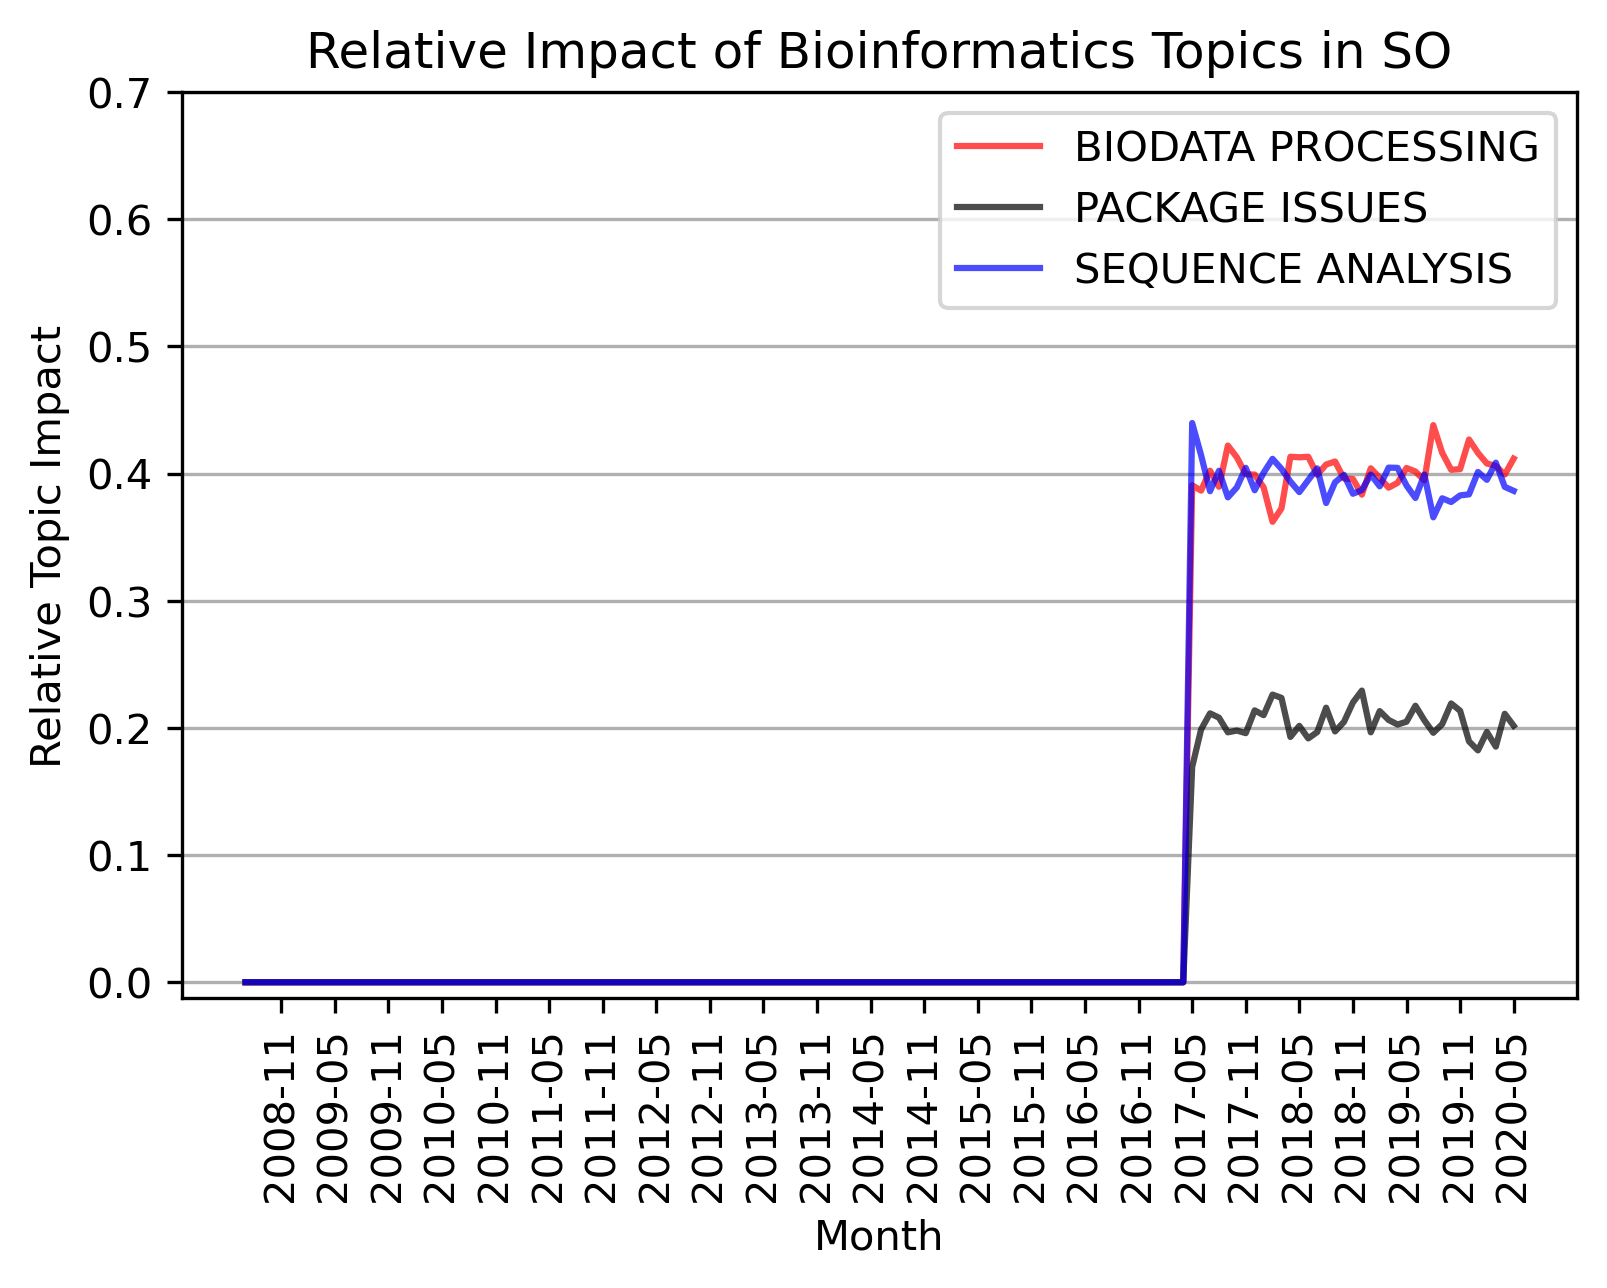

In [61]:
coords = []
for key, vals in heirarchy.items():
    x = [item[0] for item in final_impact[topic_id_dict[vals[0]]]]
    y = np.zeros(len(x))
    for val in vals:
        y += [item[1] for item in final_impact[topic_id_dict[val]]]
    coords.append({
        'Category' : key,
        'x' : x,
        'y' : y})
coords.sort(
    key = lambda x : np.median(x['y']),
    reverse=True)
    
alpha =      np.ones(6) * 0.7
linestyles = ['-', '-', '-', '-', '-', '-']
color = ['red', 'black', 'blue', 'orange', 'green', 'purple']
fig, ax = plt.subplots(dpi = 300)
x = coords[0]['x']
for idx in range(len(coords)):
    y = coords[idx]['y']
    ax.plot(
        x,
        y,
        color = color[idx],
        alpha = alpha[idx],
        linestyle = linestyles[idx],
        label = coords[idx]['Category']
    )
ax.set_xlabel('Month')
ax.set_ylabel('Relative Topic Impact')
ax.set_title('Relative Impact of Bioinformatics Topics in SO')

ax.set_ylim([-0.0125, .7])

ax.grid(True)
ax.xaxis.grid(False)

pos = np.arange(4, len(x), 6)
ax.axes.get_xaxis().set_ticks(pos)
ax.tick_params(axis = 'x', rotation = 90)

ax.legend(loc = 5, fontsize = 10)
ax.legend()
plt.savefig(os.path.join(cur_dir, 'Relative_Impact_Cat_1.svg'), format = 'svg')

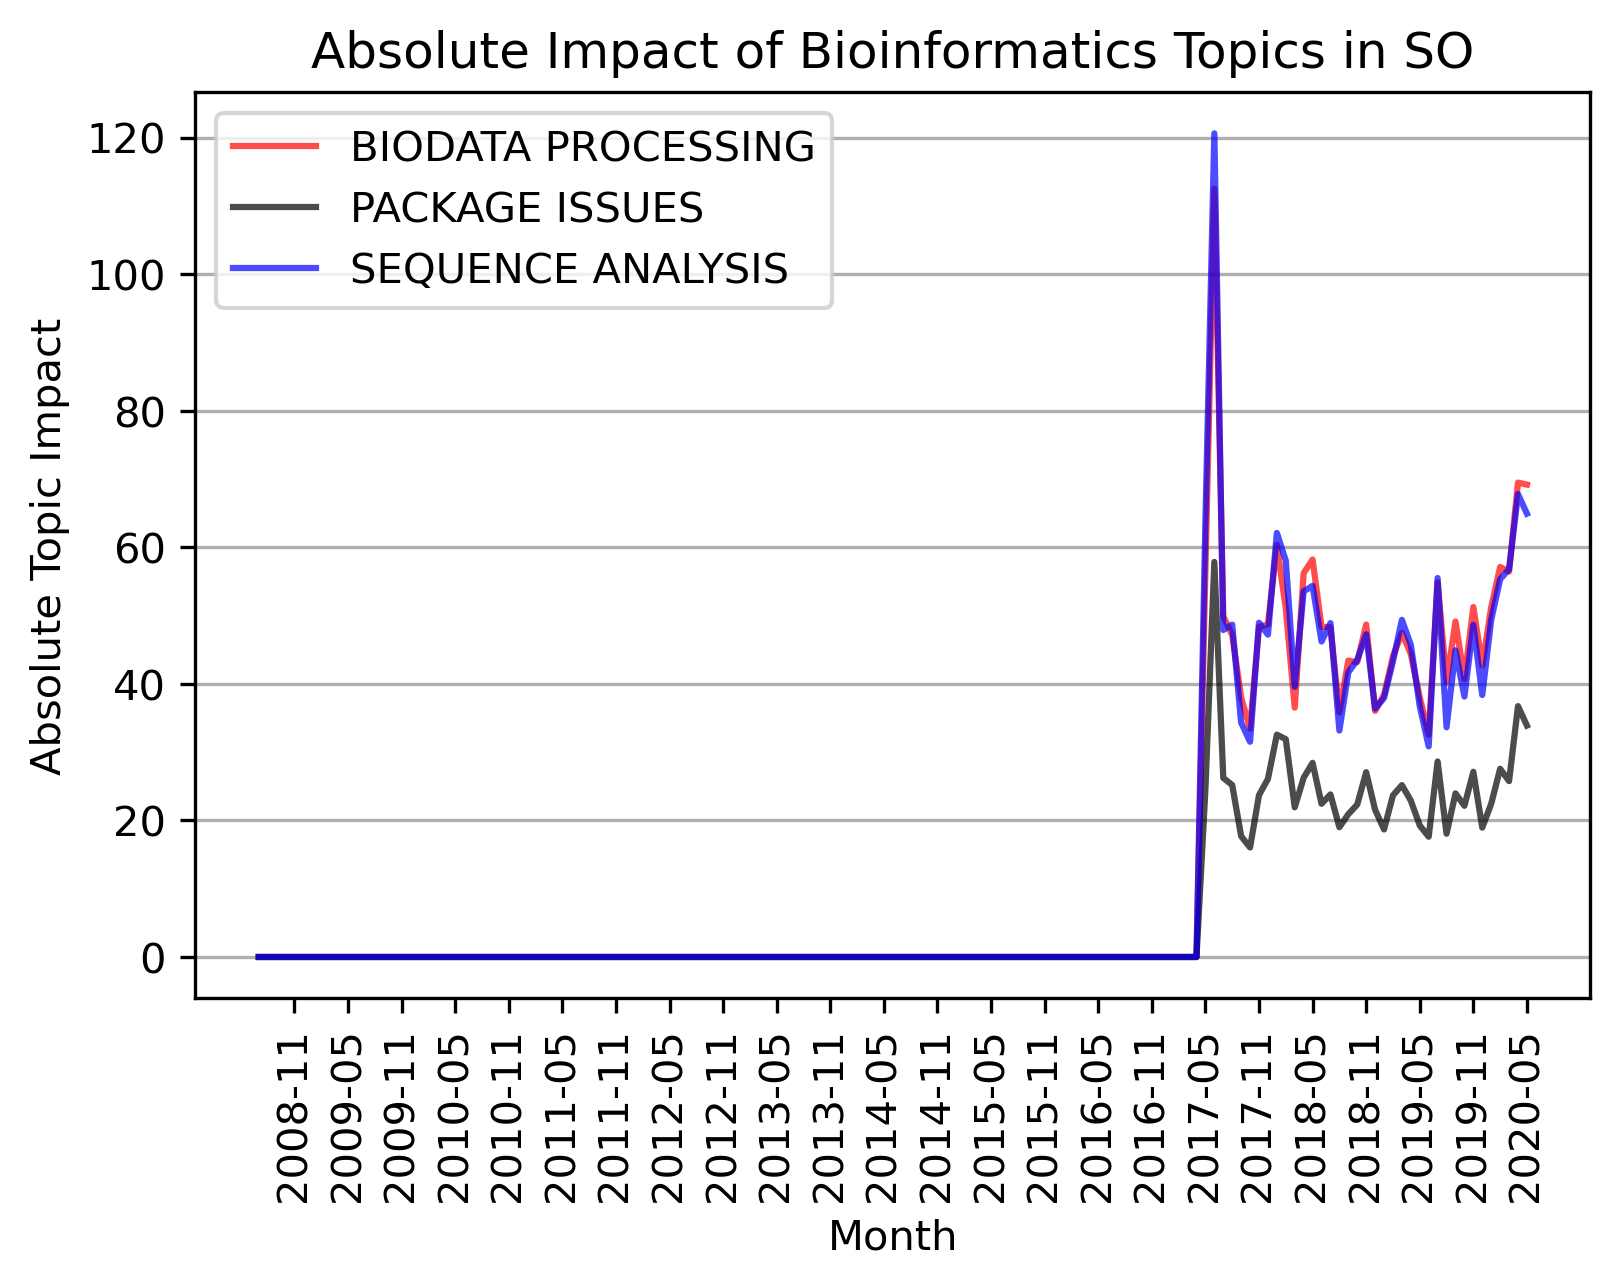

In [62]:
coords = []
for key, vals in heirarchy.items():
    x = [item[0] for item in absolute_impact[topic_id_dict[vals[0]]]]
    y = np.zeros(len(x))
    for val in vals:
        y += [item[1] for item in absolute_impact[topic_id_dict[val]]]
    coords.append({
        'Category' : key,
        'x' : x,
        'y' : y})

coords.sort(
    key = lambda x : np.median(x['y']),
    reverse=True)
    
alpha =      [0.7,  0.7, 0.7, 0.7, 0.7, 0.7]
linestyles = ['-', '-', '-', '-', '-', '-']
color = ['red', 'black', 'blue', 'orange', 'green', 'purple']

fig, ax = plt.subplots(dpi = 300)
x = coords[0]['x']
for idx in range(len(coords)):
    y = coords[idx]['y']
    ax.plot(
        x,
        y,
        color = color[idx],
        alpha = alpha[idx],
        linestyle = linestyles[idx],
        label = coords[idx]['Category']
    )
ax.set_xlabel('Month')
ax.set_ylabel('Absolute Topic Impact')
ax.set_title('Absolute Impact of Bioinformatics Topics in SO')

# ax.set_ylim([-0.0125, .7])

ax.grid(True)
ax.xaxis.grid(False)

pos = np.arange(4, len(x), 6)
ax.axes.get_xaxis().set_ticks(pos)
ax.tick_params(axis = 'x', rotation = 90)

ax.legend(loc = 5, fontsize = 10)
ax.legend()
plt.savefig(os.path.join(cur_dir, 'Absolute_Impact_Cat_1.svg'), format = 'svg')

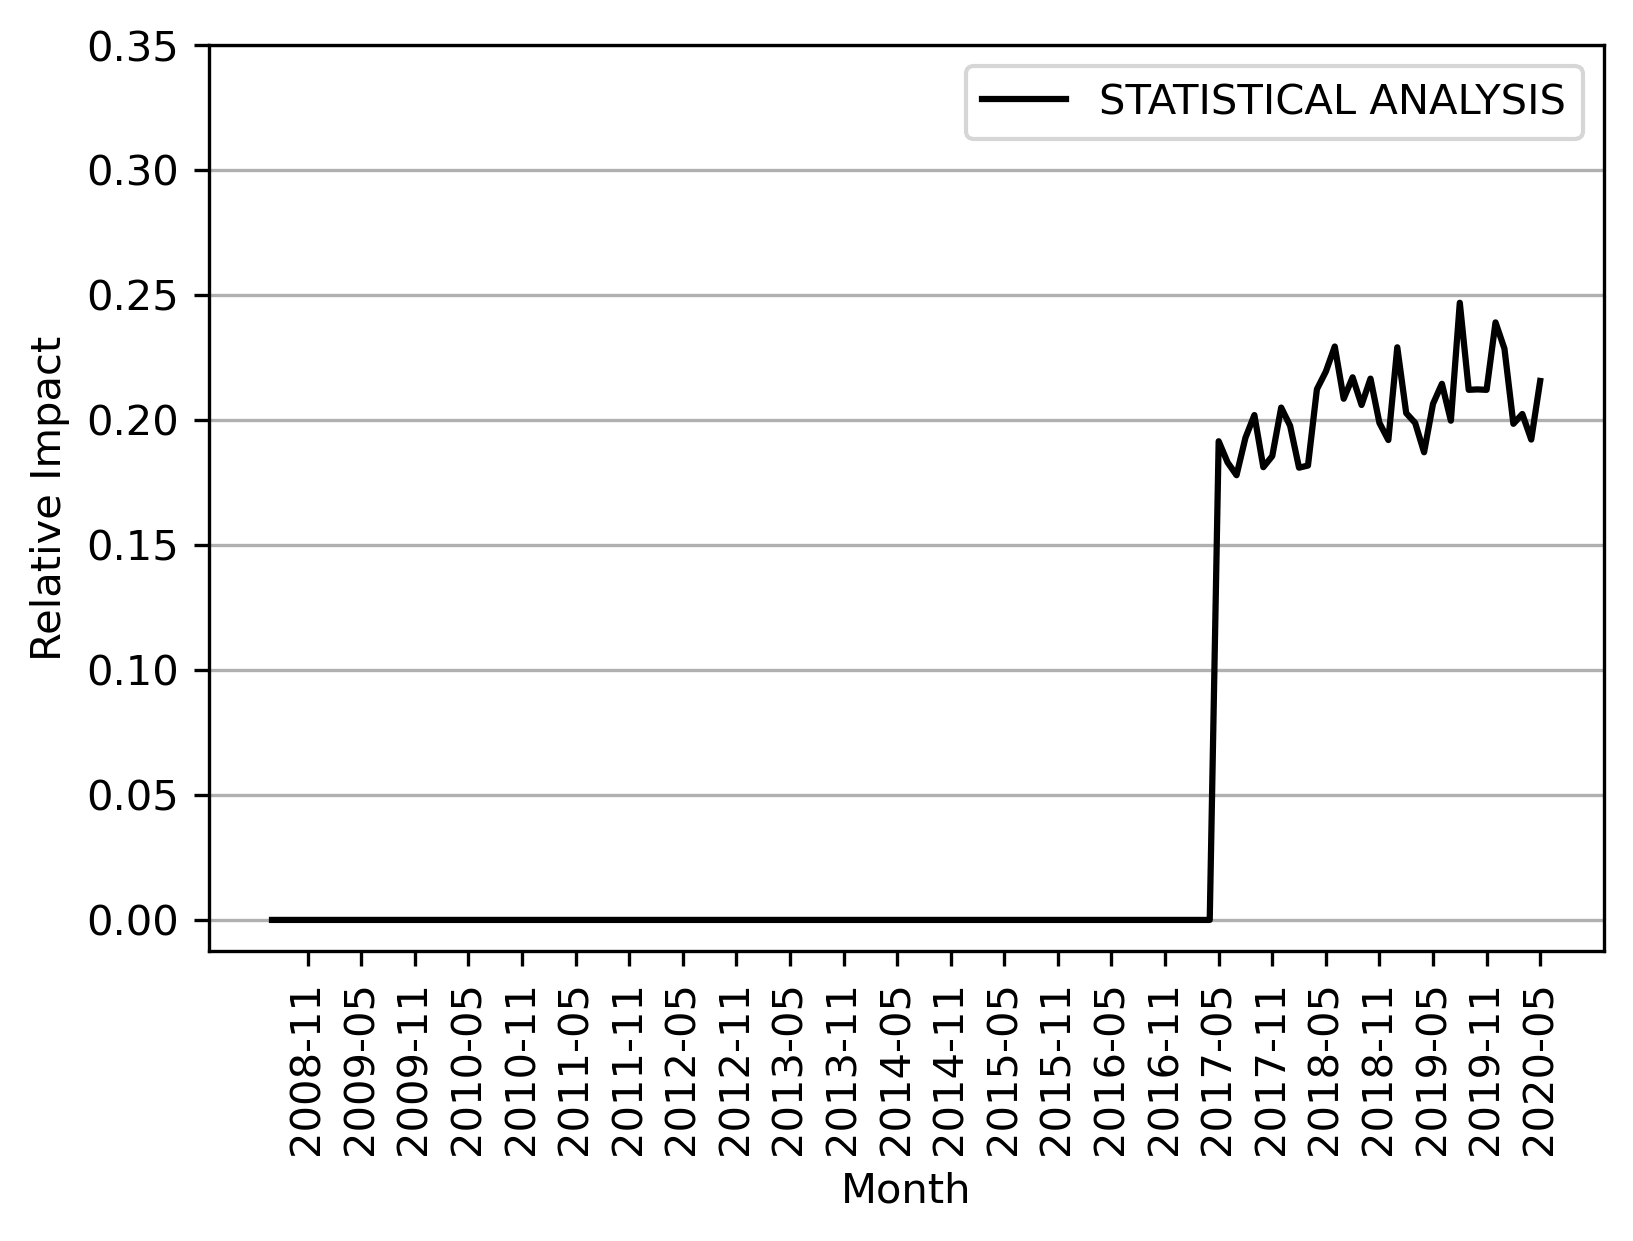

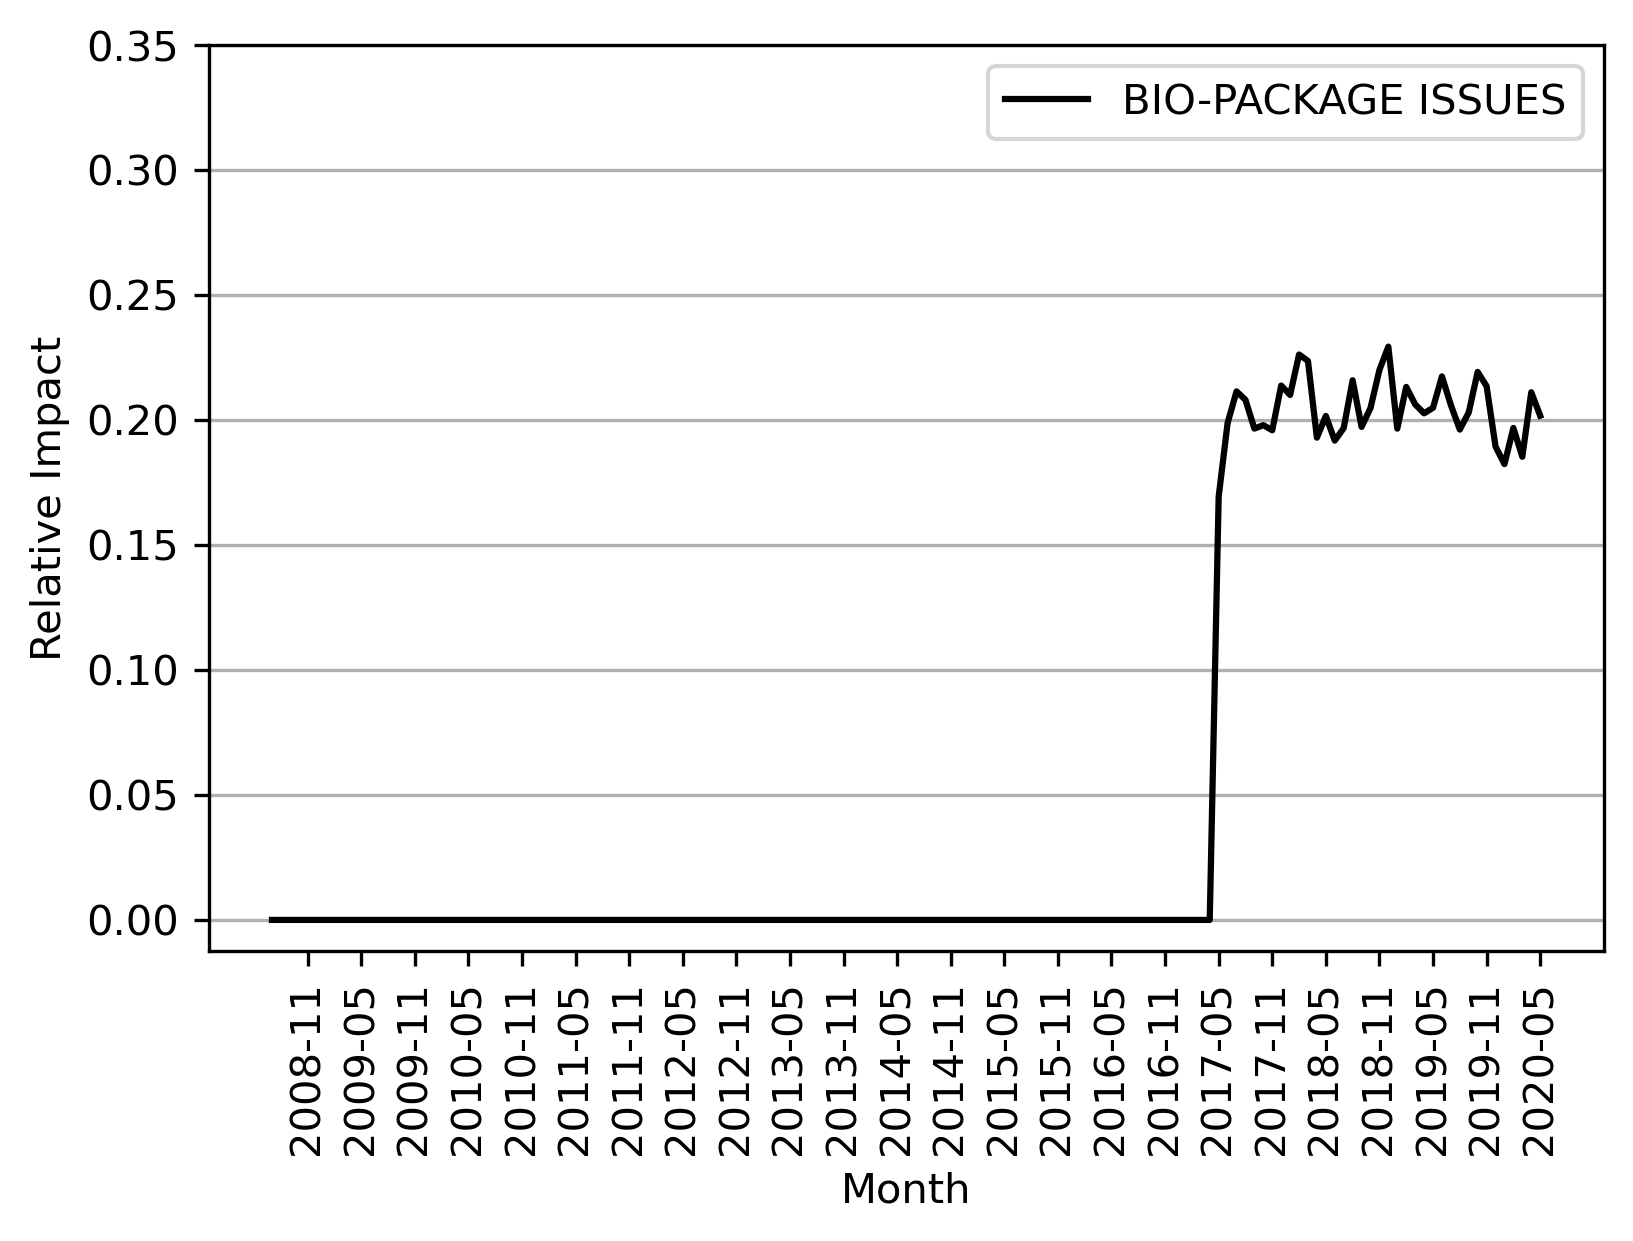

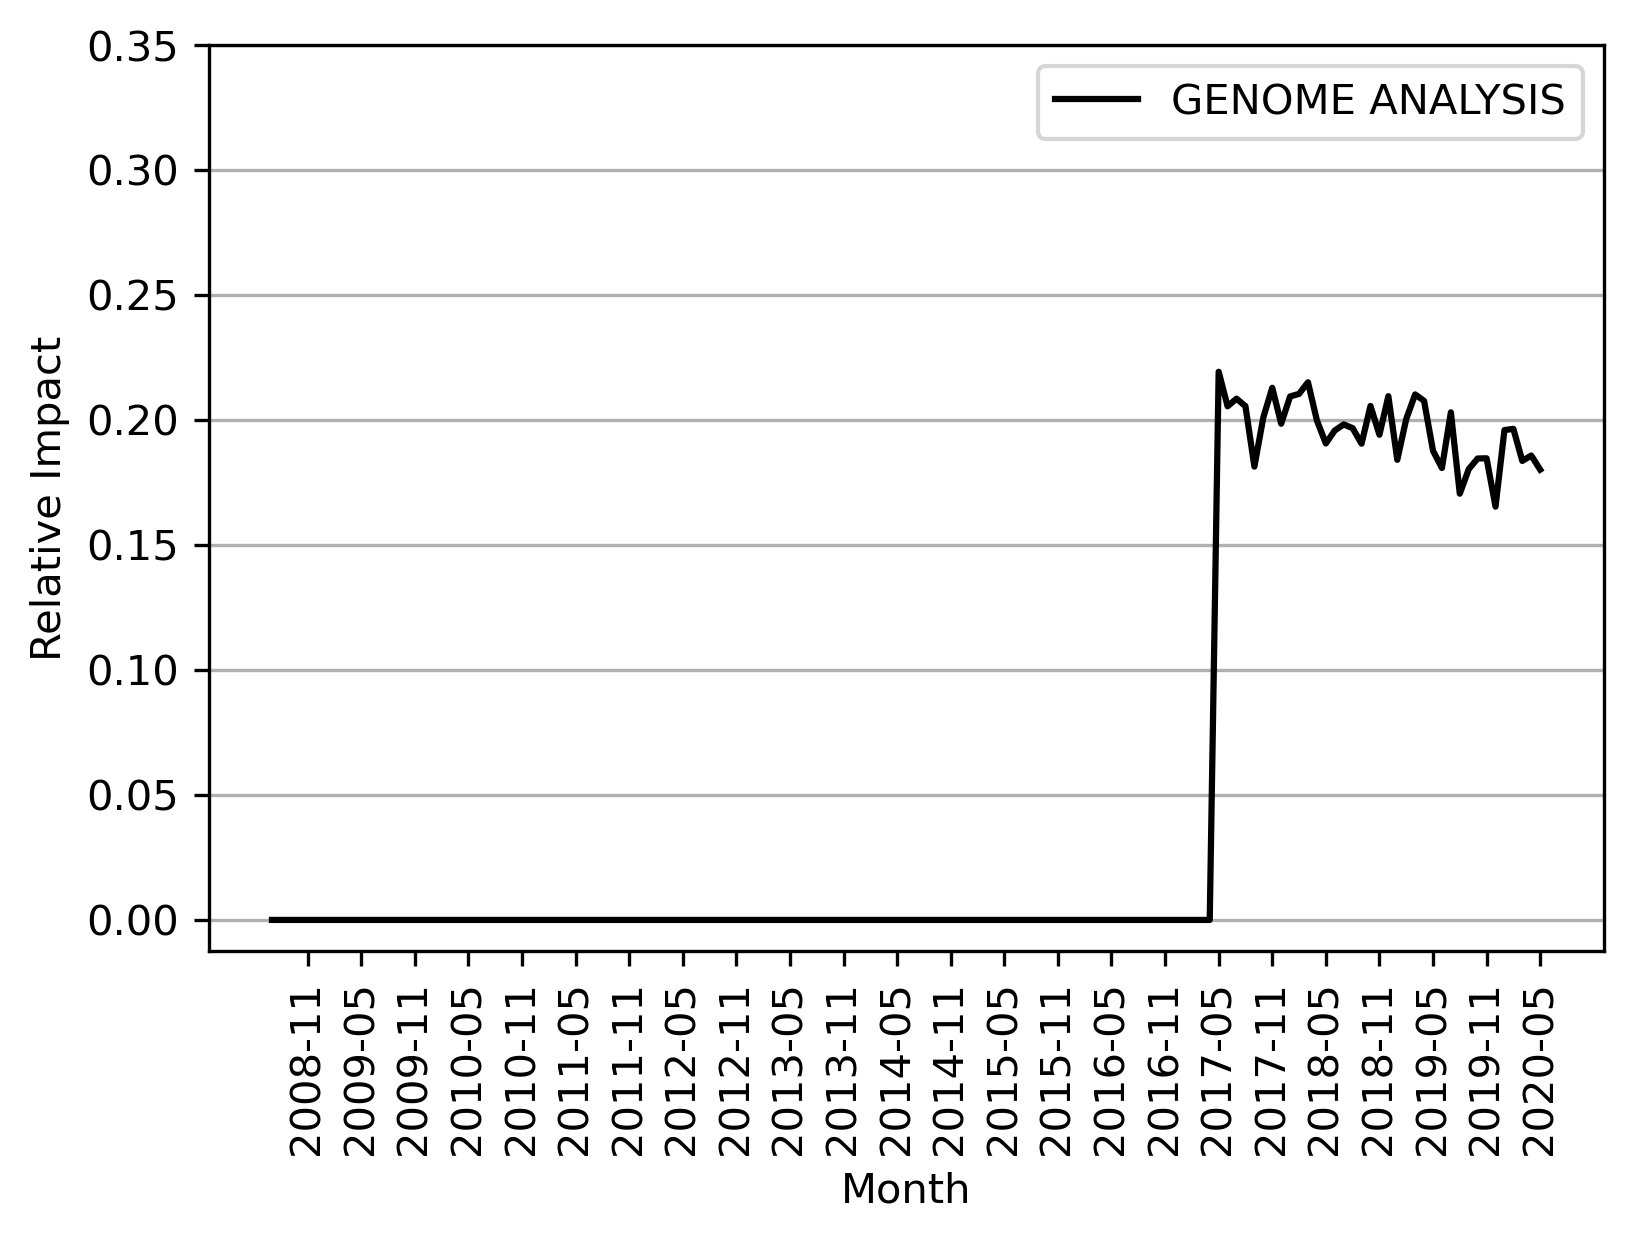

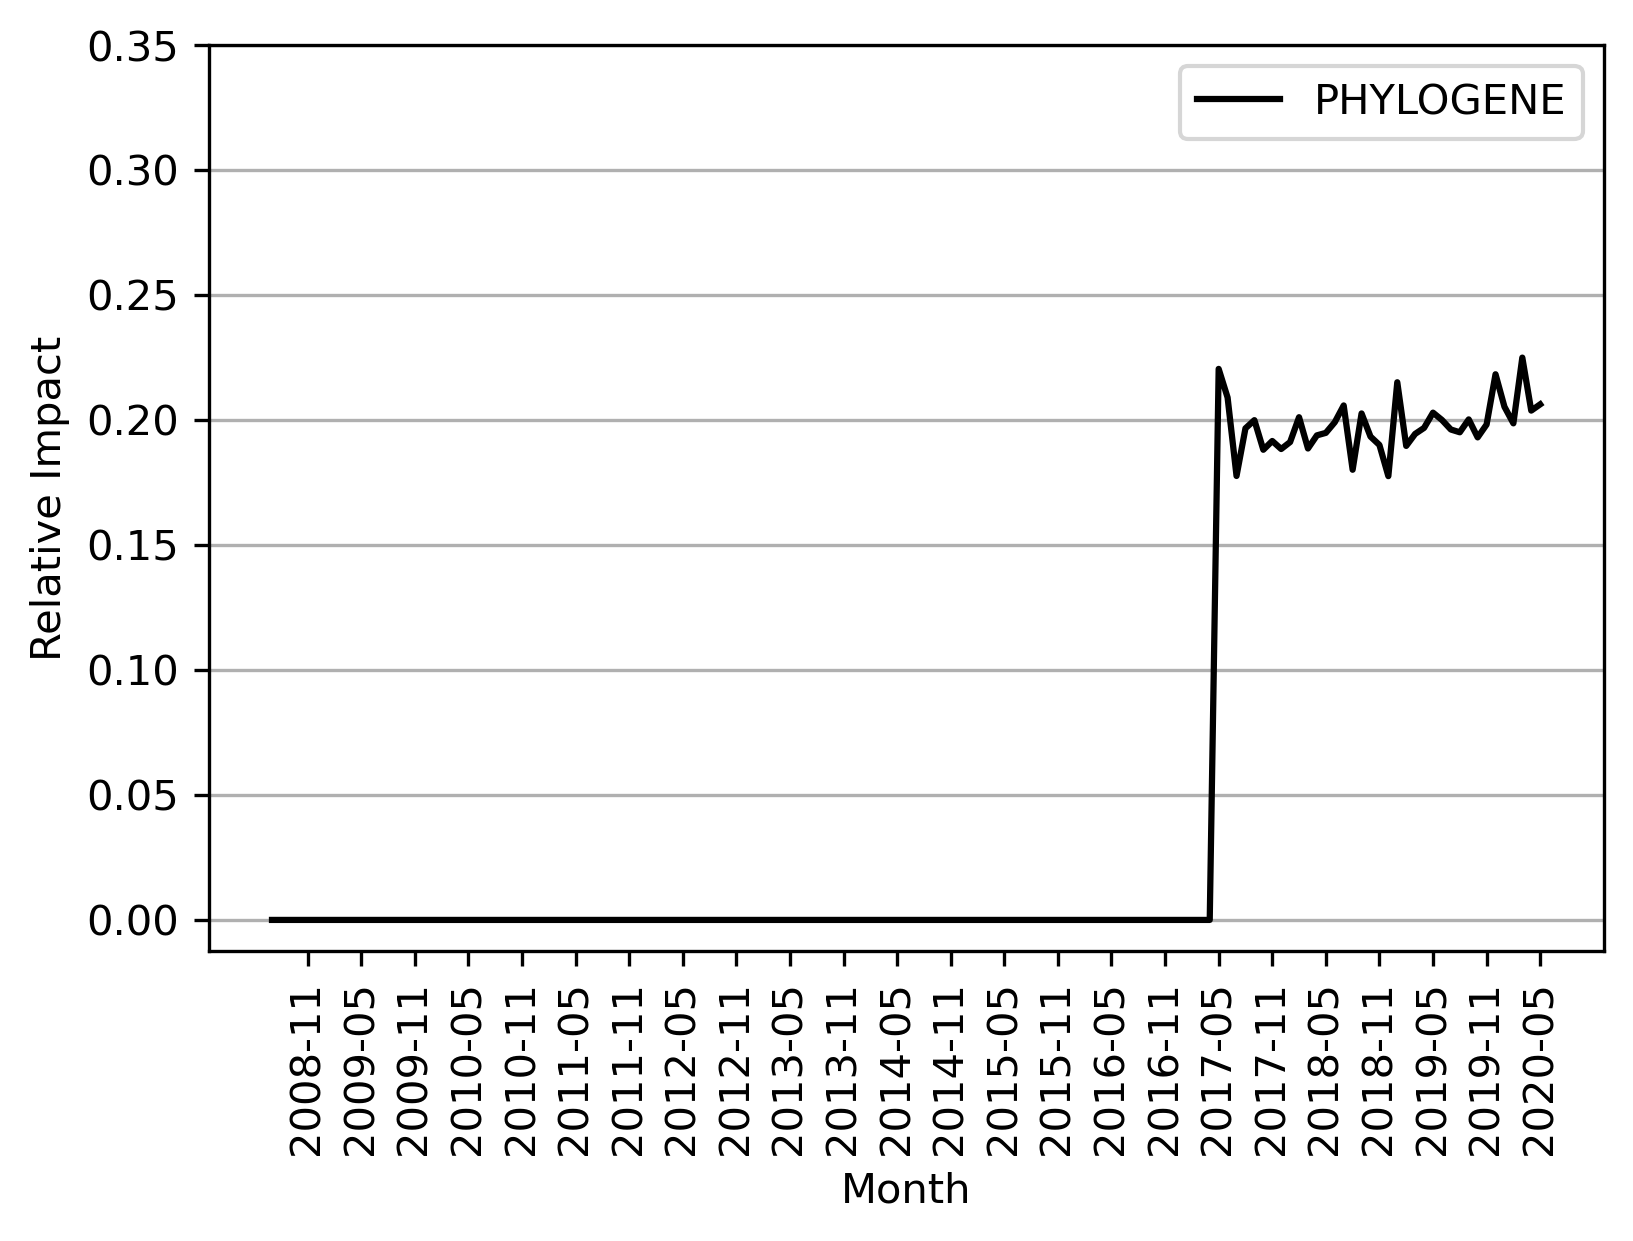

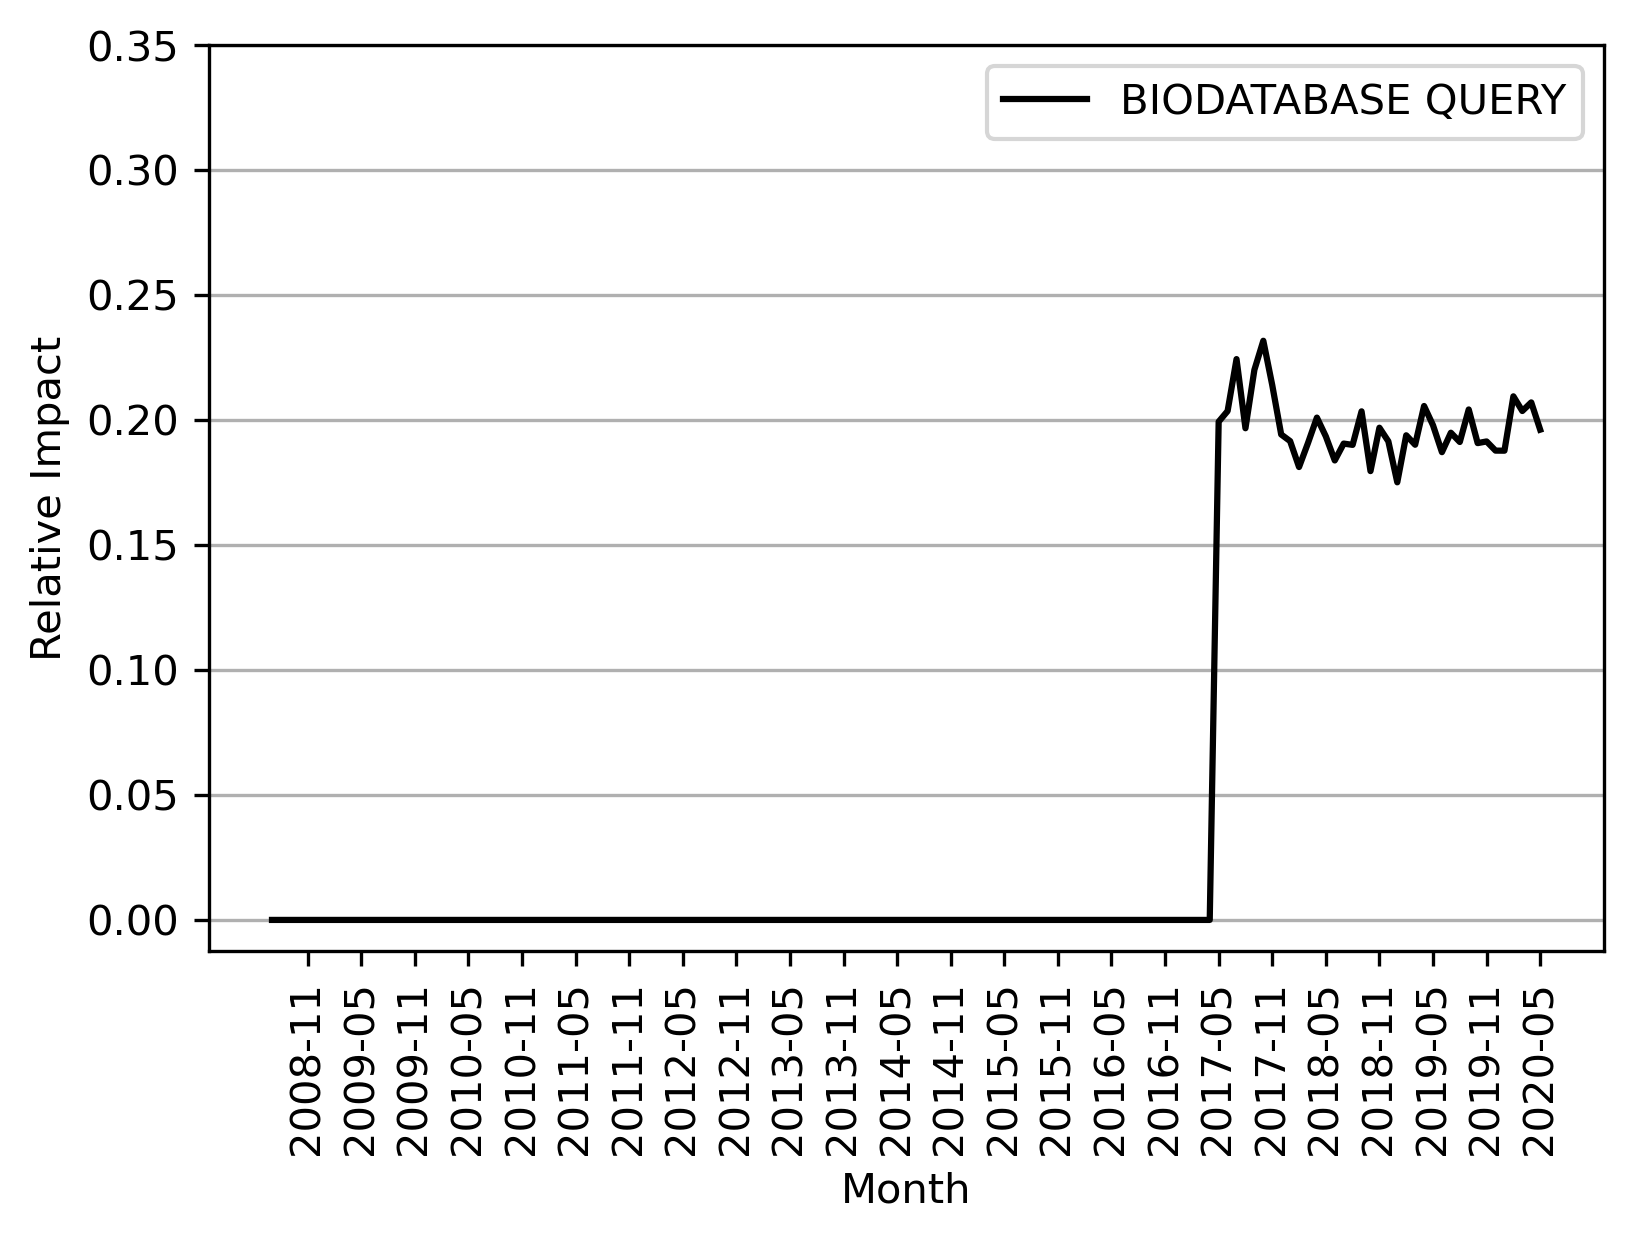

In [63]:
for idx in range(len(topic_category_0)):
    fig, ax = plt.subplots(dpi = 300)
    # ax.set_ylim(.031098, .031099)
    x = [item[0] for item in final_impact[idx]]
    y = [item[1] for item in final_impact[idx]]
    
    ax.plot(x, y, label = topic_category_0[idx], color = 'black')
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Relative Impact')
    ax.set_label('Impact of %s' % topic_category_0[idx])
    
    ax.set_ylim([-0.0125, .35])
    
    ax.grid(True)
    ax.xaxis.grid(False)
    
    pos = np.arange(4, len(x), 6)
    ax.axes.get_xaxis().set_ticks(pos)
    ax.tick_params(axis = 'x', rotation = 90)
    
    ax.legend(loc = 9, fontsize = 2)
    ax.legend()
    plt.savefig(os.path.join(cur_dir, 'Impact%d.svg' % idx), format = 'svg')

In [64]:
# all_cd_df = pd.read_csv(
#     os.path.join(
#         root_dir, 'QuestionTags.csv'),
#     usecols=['QuestionId', 'CreationDate'])

In [65]:
# all_month = []

# all_cds = all_cd_df.to_numpy()

# # doc_cd = corpora.reshape(len(doc_cd), 1)

# all_cd_bin = {}
# # impact_corpora_percentage = []
# for idx in range(all_cds.shape[0]):
# #     cd = all_cds[idx][1][2:-1]
#     cd = all_cds[idx][1]
#     cd = '-'.join(cd.split('T')[0].split('-')[0:2])    
#     if cd in all_cd_bin:
#         all_cd_bin[cd].append(all_cds[idx][0])
#     else:
#         all_cd_bin[cd] = []
#         all_cd_bin[cd].append(all_cds[idx][0])
# len(all_cd_bin)

In [66]:
# impact_absolute = {}
# for month, pids in all_cd_bin.items():
#     for pid in pids:
# #         if not isinstance(pid, int):
# #             print(pid)
#         for idx in range(len(final_theta[pid])):
#             if idx not in impact_absolute:
#                 impact_absolute[idx] = {}
#             if month not in impact_absolute[idx]:
#                  impact_absolute[idx][month] = []     
#             impact_absolute[idx][month].append(final_theta[pid][idx])

# Assignment

In [67]:
assignments = []
for topic_id, dict_ in impact.items():
    sum_ = 0
    for month in dict_:
        sum_ += sum(dict_[month])
    assignments.append({
        'Id' : topic_id,
        'Assignment' : sum_
    })

In [68]:
# assignments = sorted(assignments, key= lambda x: x['Assignment'], reverse=True)

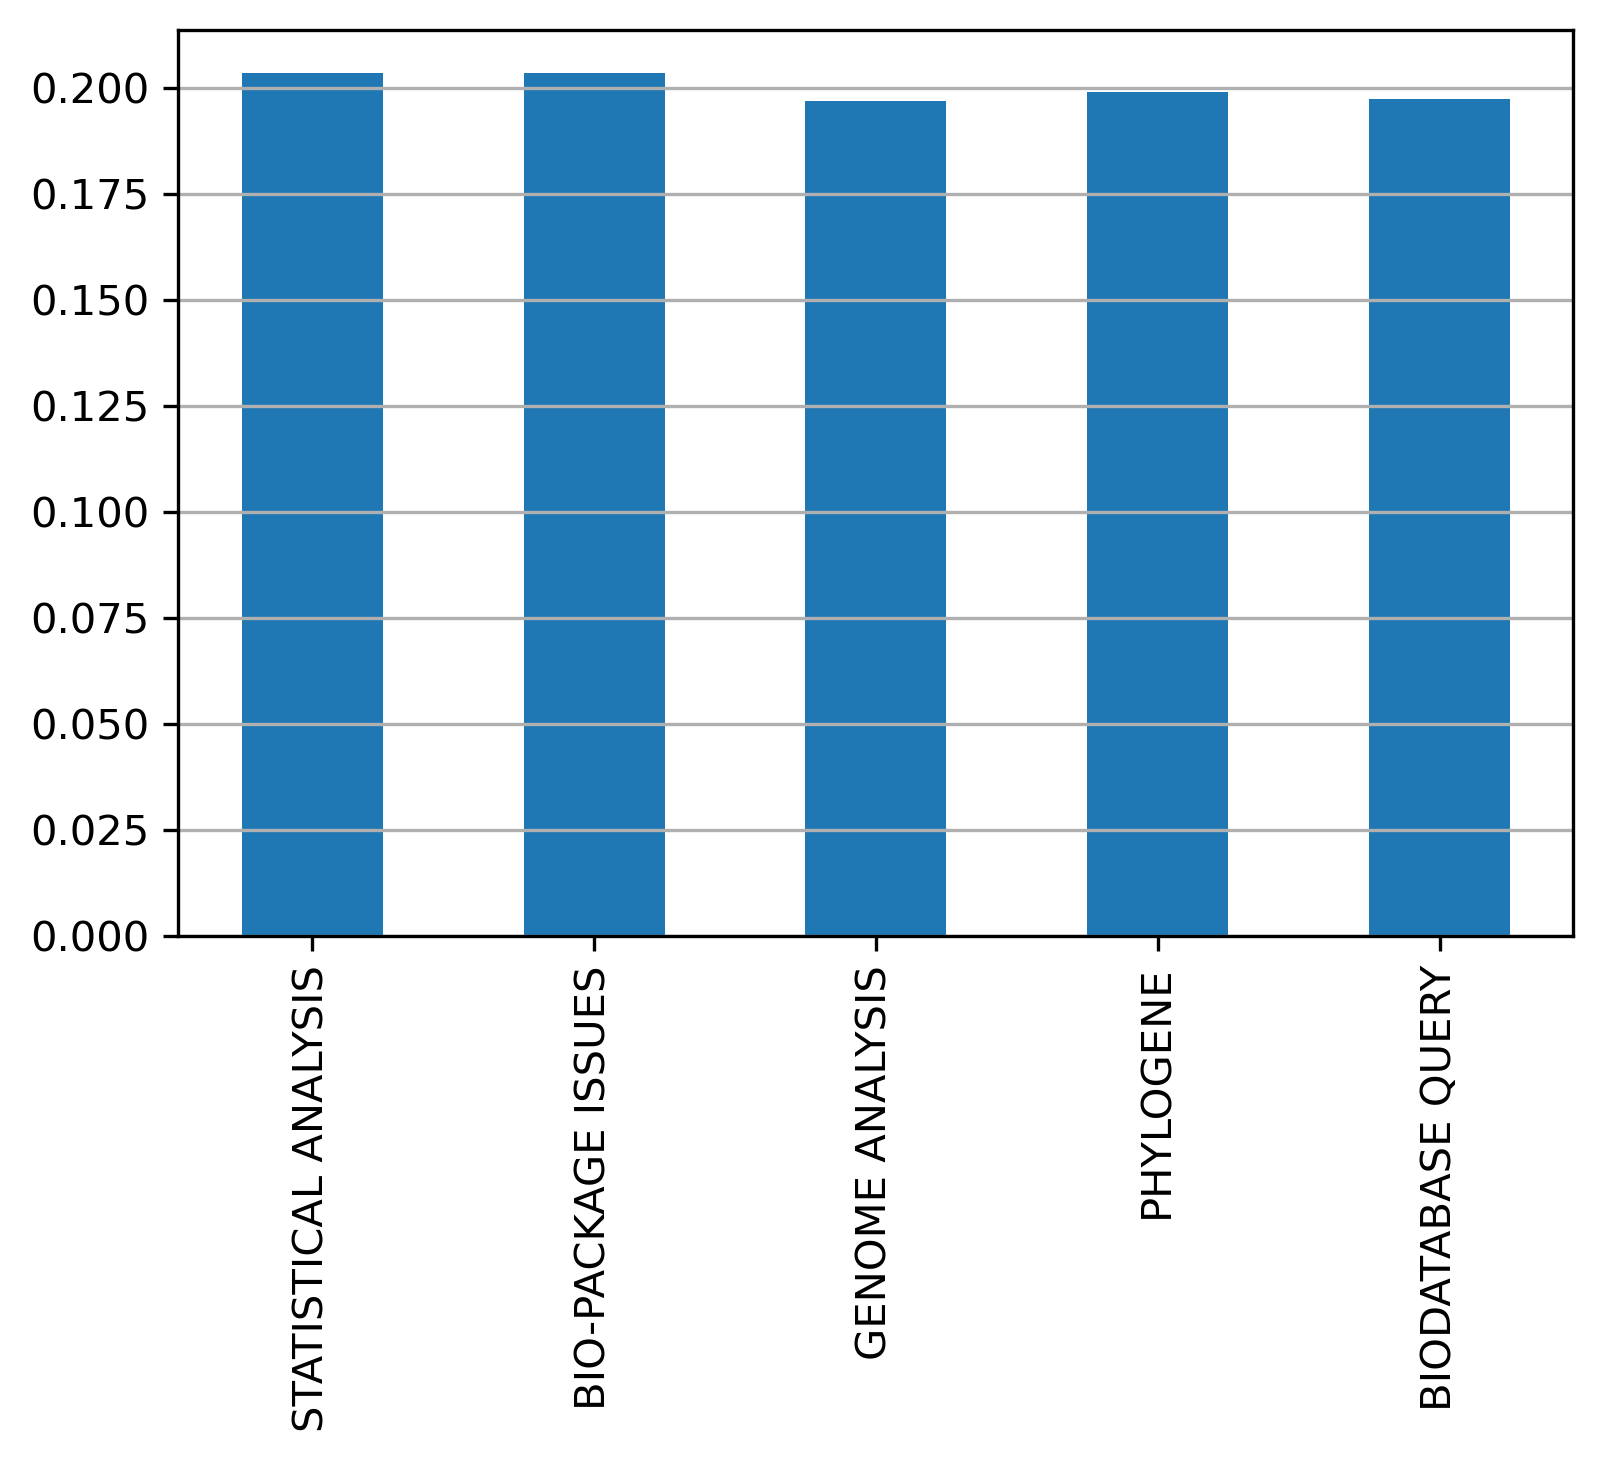

In [69]:
x = []
y = []
for dict_ in assignments:
    x.append(topic_category_0[dict_['Id']])
    y.append(dict_['Assignment'] / len(final_theta))

fig, ax = plt.subplots(dpi = 300)
ax.bar(x, y, width = .5)
ax.tick_params(axis = 'x', rotation = 90)
ax.yaxis.grid(True)
plt.savefig(os.path.join(cur_dir, 'Assignments.svg'), format = 'svg')

# Weight

In [70]:
weights = {}
unigrams = _pickle.load(
    open(
    os.path.join(input_dir, 'PostStemmed/Unigrams.pkl'), 'rb')
)
for i in range(len(theta)):
    for j in range(len(theta[i])): 
        if j not in weights:
            weights[j] = 0
        weights[j] += theta[i][j] * len(unigrams[i])

In [71]:
# weights = sorted(weights.items(), key= lambda x: x[1], reverse=True)
# weights

In [72]:
weights[0]

304211.94107168005

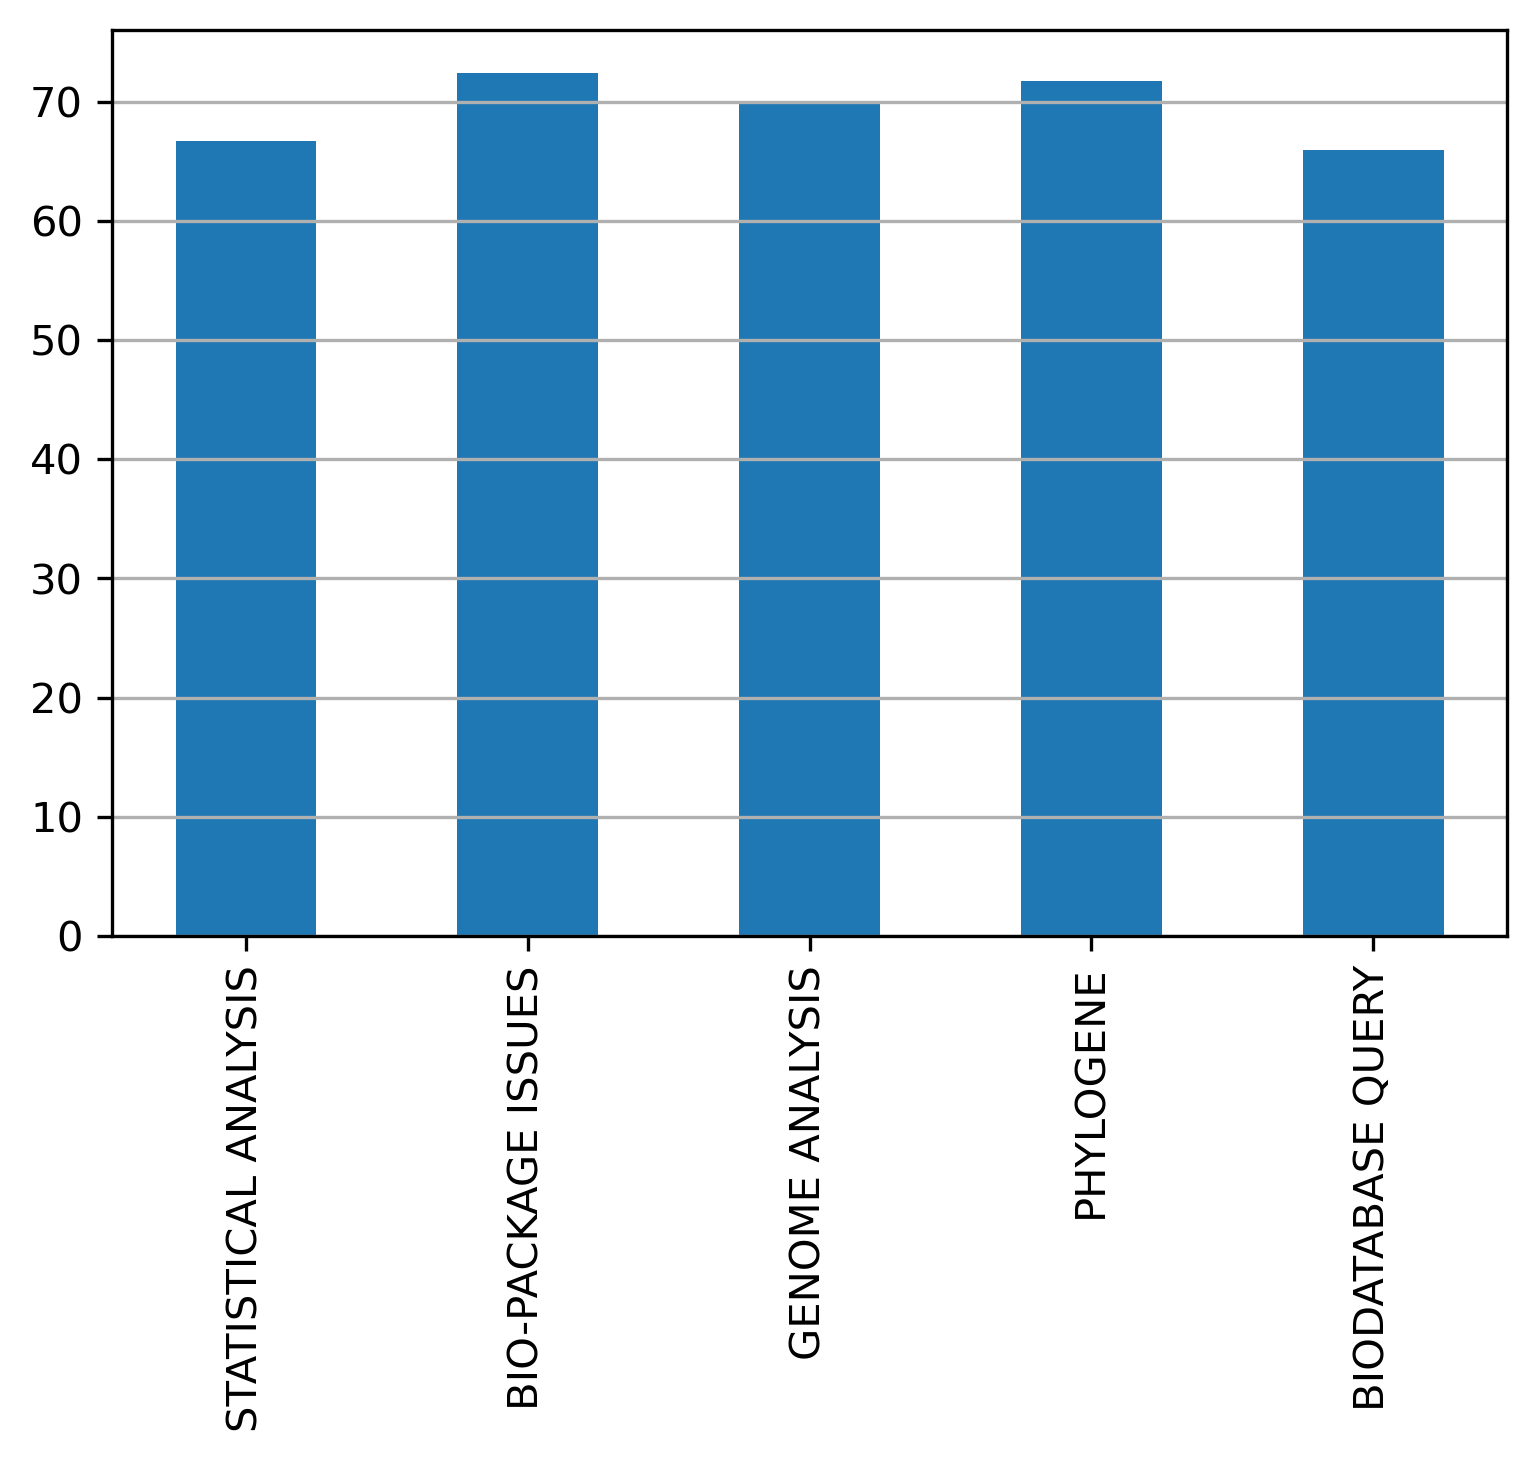

In [73]:
x = []
y = []
for idx in range(len(weights)):
    x.append(topic_category_0[idx])
    y.append(weights[idx] / len(final_theta))

fig, ax = plt.subplots(dpi = 300)
ax.bar(x, y, width = .5)
ax.tick_params(axis = 'x', rotation = 90)
ax.yaxis.grid(True)
plt.savefig(os.path.join(cur_dir, 'Weight.svg'), format = 'svg')

# Scattering

In [74]:
scattering = {}
for i in range(len(theta)):
    for j in range(len(theta[i])): 
        if j not in scattering:
            scattering[j] = 0
        scattering[j] += theta[i][j] * np.log(theta[i][j])

In [75]:
for key, value in scattering.items():
    scattering[key] = - value

In [76]:
# scattering = sorted(scattering.items(), key= lambda x: x[1], reverse=True)
# scattering

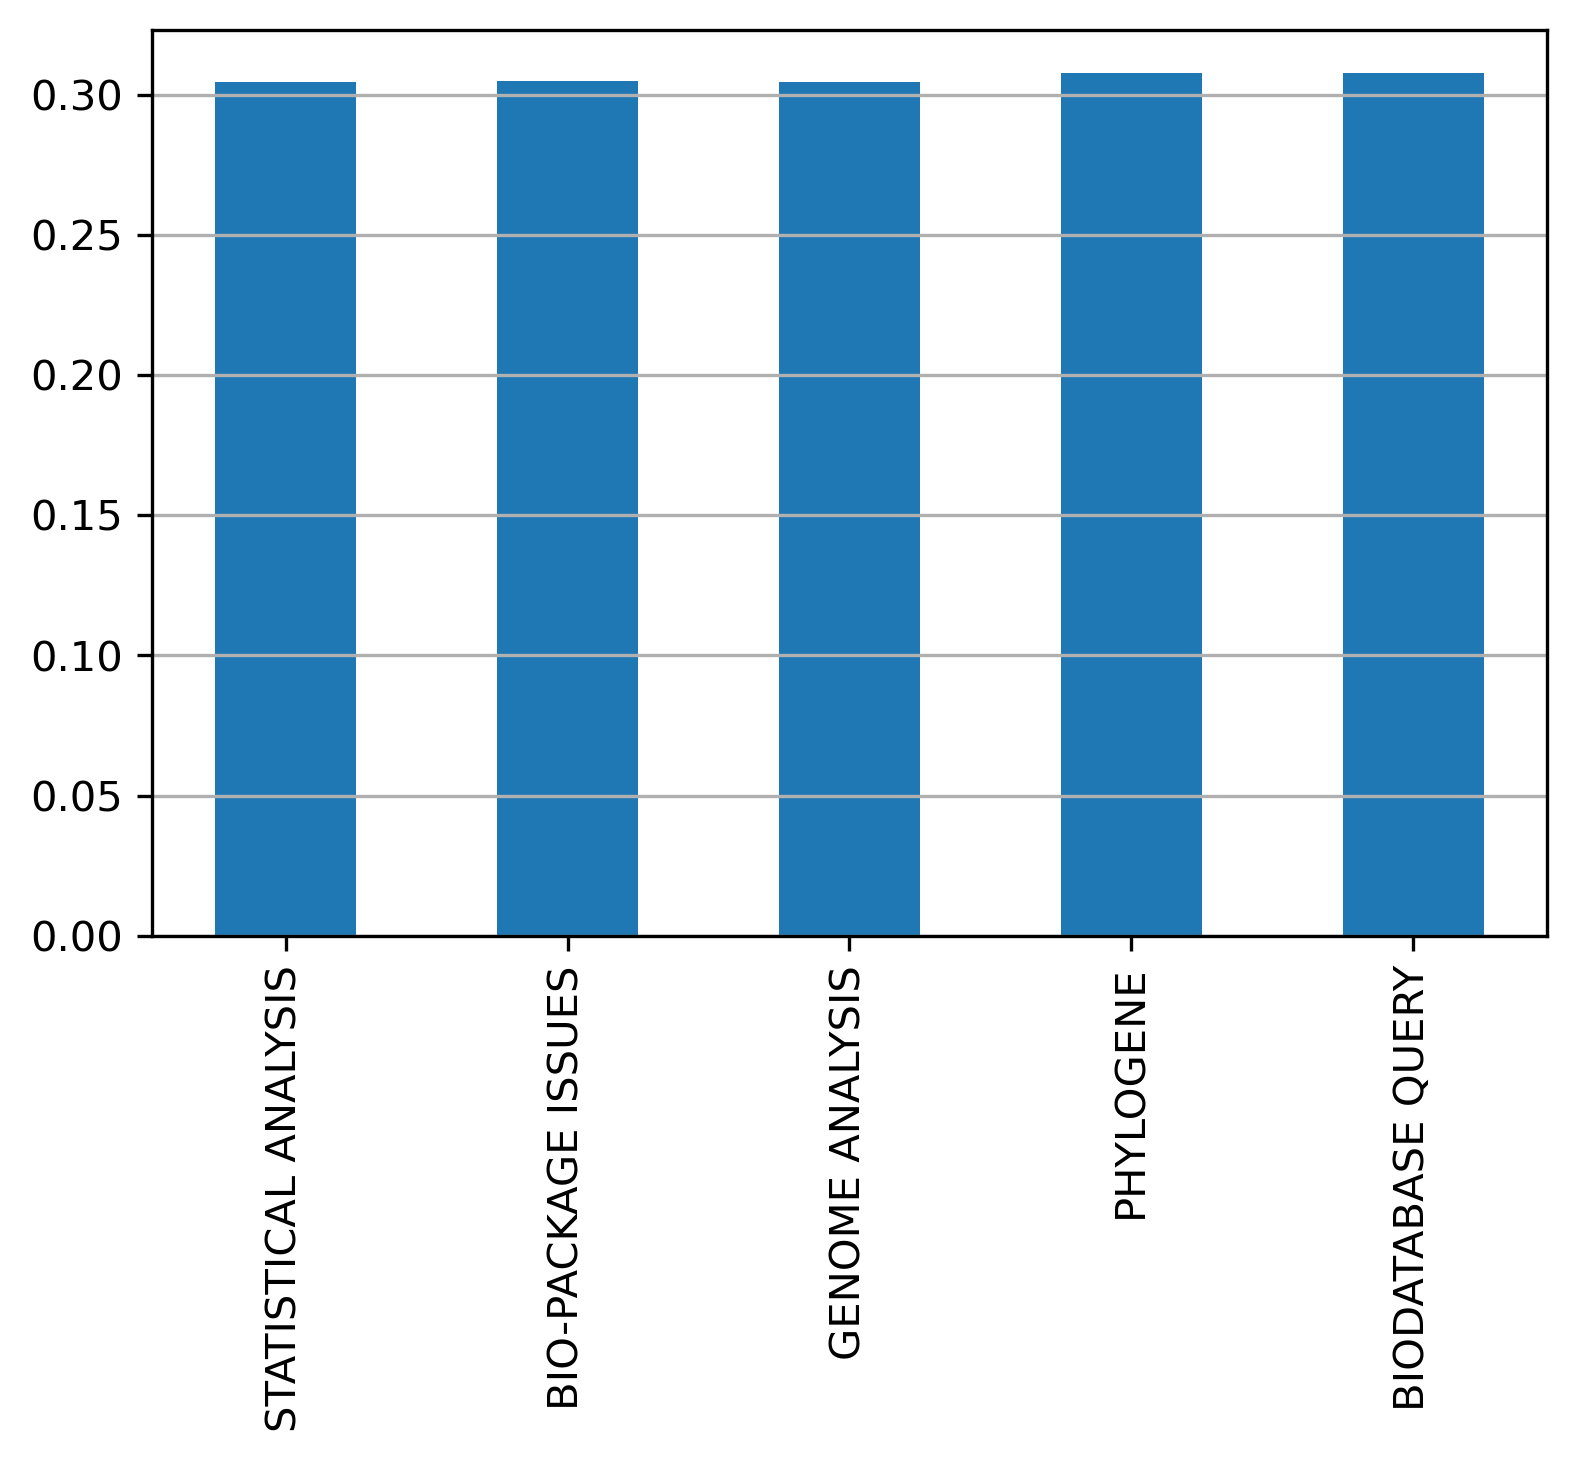

In [77]:
x = []
y = []
for idx in range(len(scattering)):
    x.append(topic_category_0[idx])
    y.append(scattering[idx] / len(final_theta))

fig, ax = plt.subplots(dpi = 300)
ax.bar(x, y, width = 0.5)
ax.tick_params(axis = 'x', rotation = 90)
ax.yaxis.grid(True)
plt.savefig(os.path.join(cur_dir, 'Scattering.svg'), format = 'svg')

In [78]:
l = []
for idx in range(len(assignments)):
    l.append({
        'Topic' : topic_category_0[assignments[idx]['Id']],
        'Assignment' : assignments[idx]['Assignment'] / len(final_theta),
        'Weight' : weights[idx]/ len(final_theta),
        'Scattering' : scattering[idx]/ len(final_theta),
    })

In [79]:
l = pd.DataFrame(l)
l.to_csv(os.path.join(cur_dir, 'Thomas.csv'), index = False)

# Correlation

In [80]:
popularity = pd.read_csv(
    os.path.join(cur_dir, 'popularity.csv'))

In [81]:
difficulity = pd.read_csv(
    os.path.join(cur_dir, 'difficulity.csv'))

In [82]:
l = []
features = np.append(popularity.columns, difficulity.columns)
for i in range(popularity.shape[1]):
    l.append(popularity.iloc[:, i].to_numpy())
    
for i in range(difficulity.shape[1]):
    l.append(difficulity.iloc[:, i].to_numpy())

In [83]:
result = []

for i in range(3):
    result.append([])
    for j in range(3, 6):
        print(i, j)
        result[i].append(stats.kendalltau(l[i], l[j]))

0 3
0 4
0 5
1 3
1 4
1 5
2 3
2 4
2 5


In [84]:
for i in range(3):
    for j in range(3, 6):
        print('%s vs %s' % (features[i], features[j]))
#         print()
        print('\tCorrelation\t P-Value')
        print('\t%.6f\t' % result[i][j-3].correlation,'%.6f\t' %  result[i][j-3].pvalue)
#         print('\n')

Avg. View vs % w/o ans
	Correlation	 P-Value
	0.200000	 0.816667	
Avg. View vs % w/o acc. ans
	Correlation	 P-Value
	0.000000	 1.000000	
Avg. View vs median hrs to acc. ans
	Correlation	 P-Value
	0.000000	 1.000000	
Avg. Score vs % w/o ans
	Correlation	 P-Value
	0.000000	 1.000000	
Avg. Score vs % w/o acc. ans
	Correlation	 P-Value
	0.200000	 0.816667	
Avg. Score vs median hrs to acc. ans
	Correlation	 P-Value
	-0.200000	 0.816667	
Avg. Favorite vs % w/o ans
	Correlation	 P-Value
	0.400000	 0.483333	
Avg. Favorite vs % w/o acc. ans
	Correlation	 P-Value
	0.600000	 0.233333	
Avg. Favorite vs median hrs to acc. ans
	Correlation	 P-Value
	0.200000	 0.816667	


In [85]:
popularity.columns

Index(['Avg. View', 'Avg. Score', 'Avg. Favorite'], dtype='object')

In [86]:
def list_match(list_num, list_str):
    for item in list_num:
        if str(item) in list_str:
            print(item)

# impact cat 0 plot

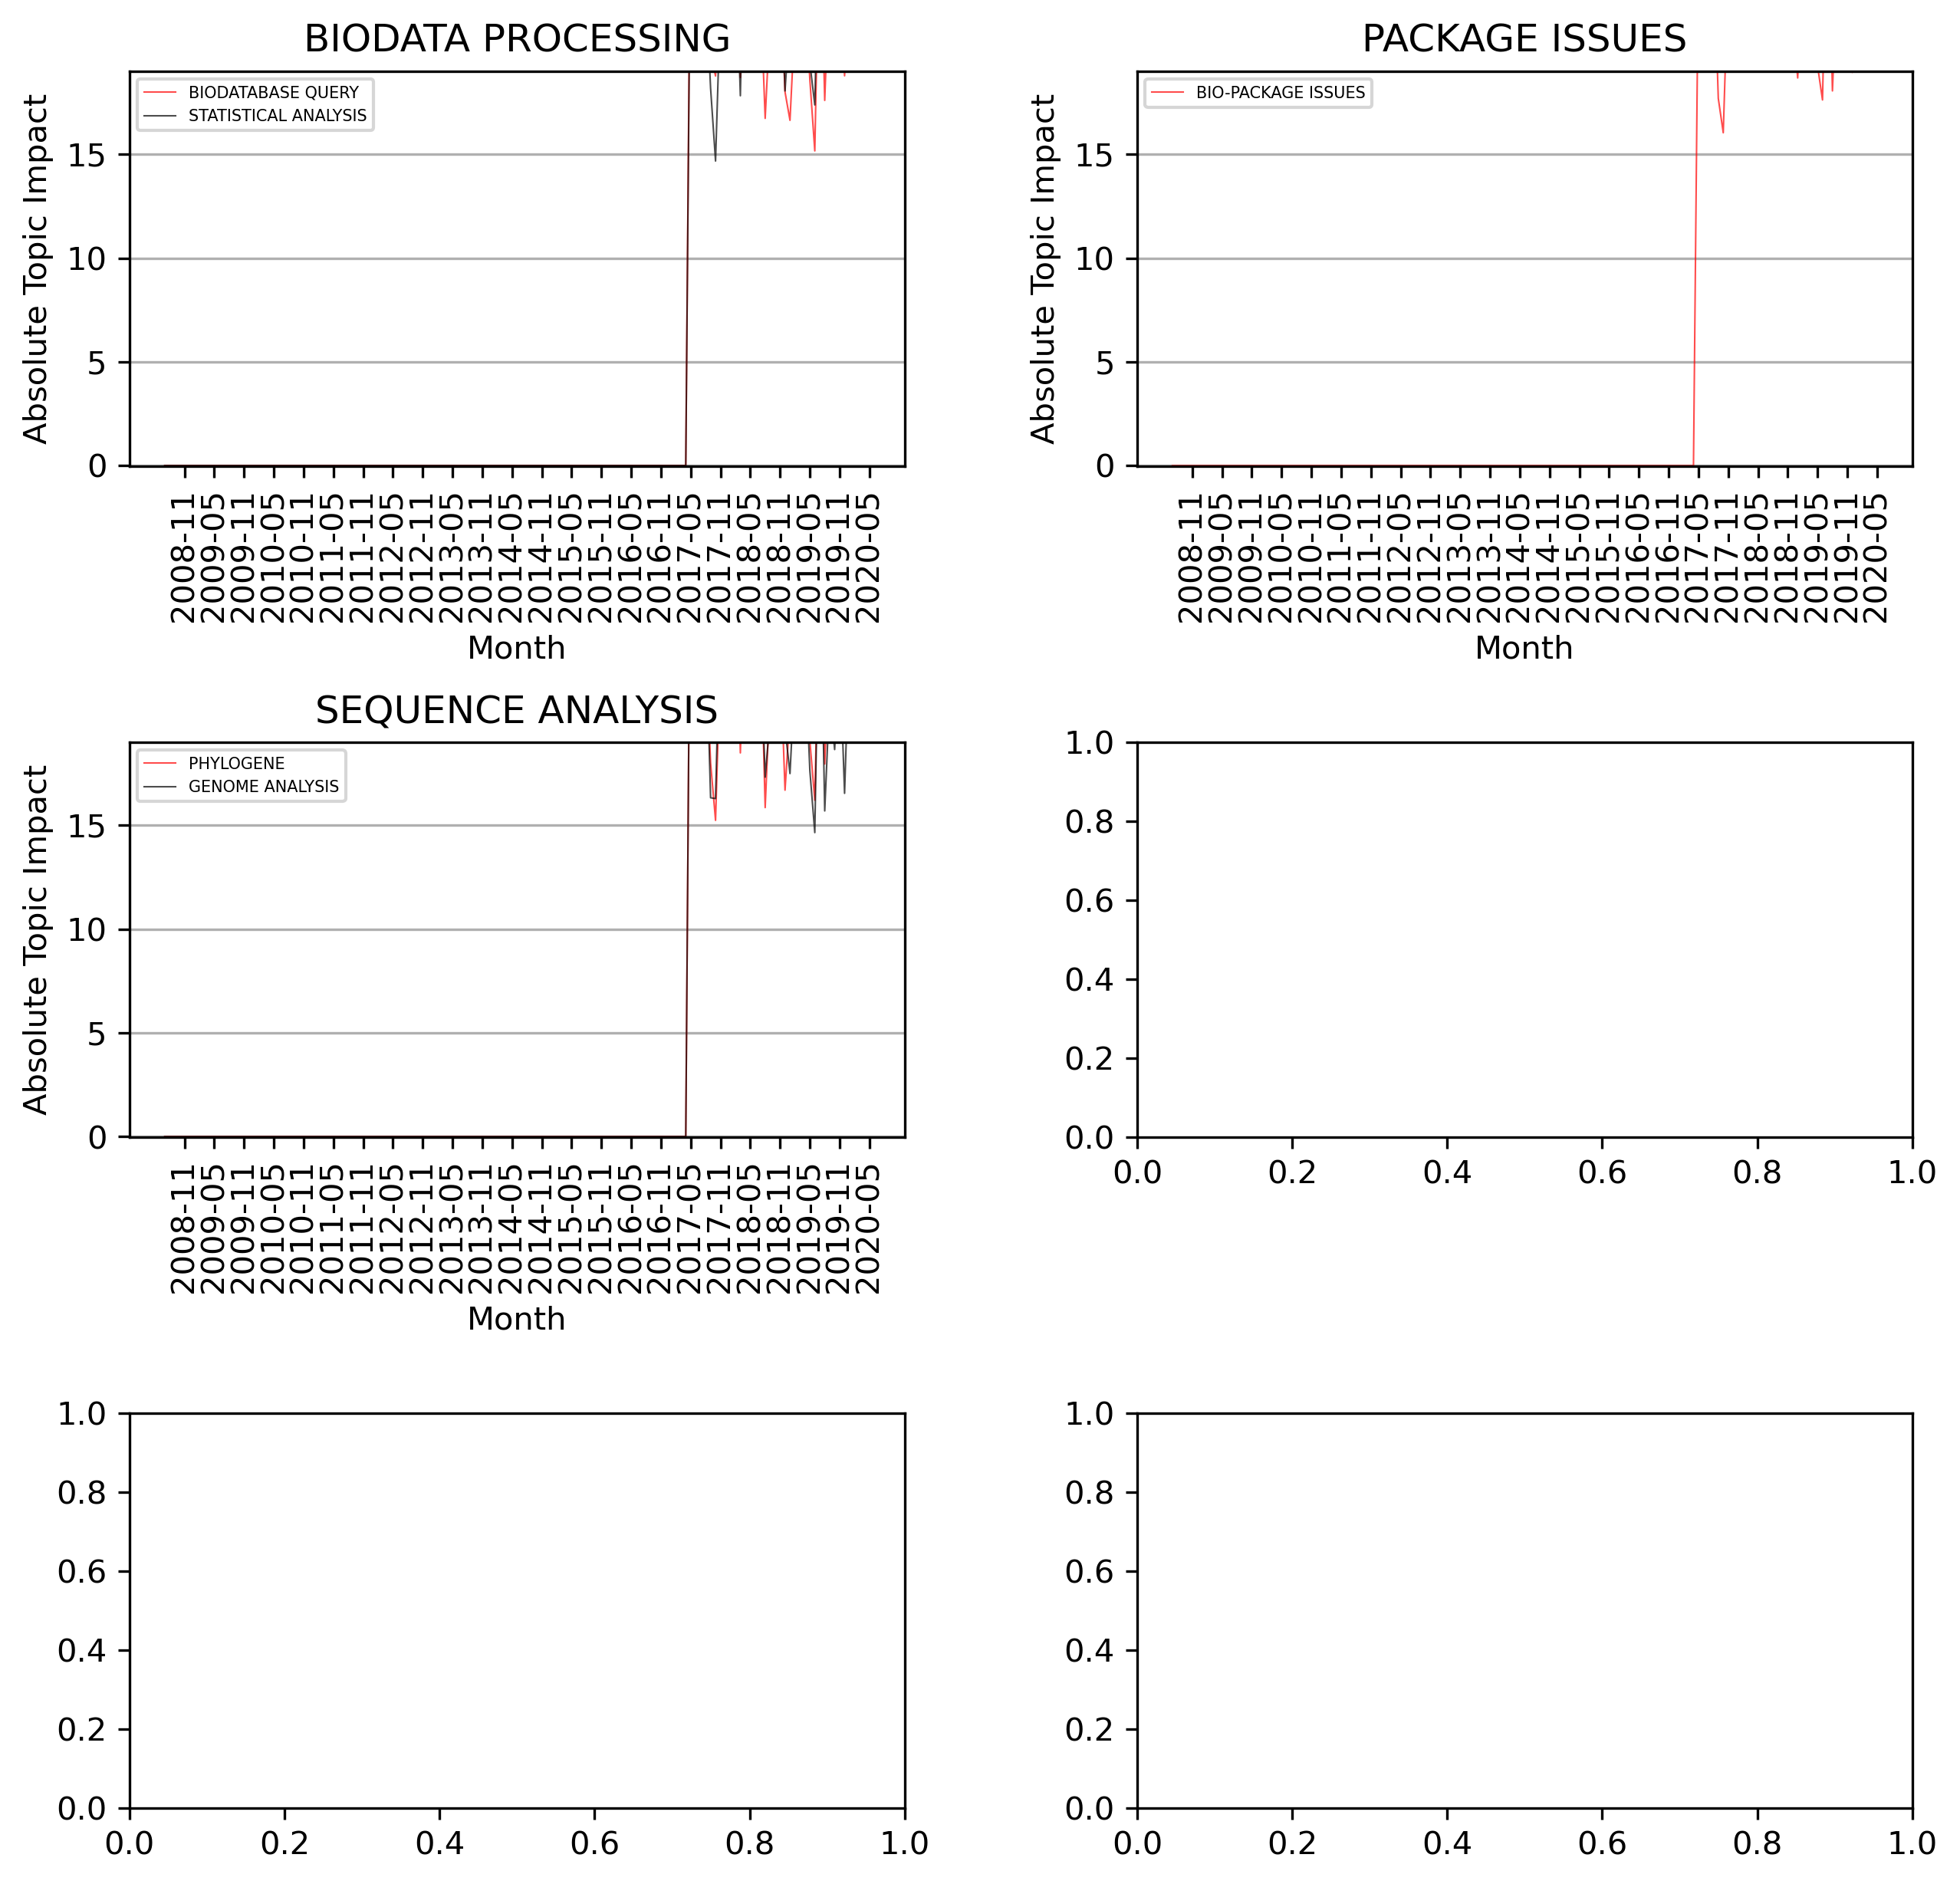

In [87]:
fig, ax = plt.subplots(nrows=3,
                       ncols=2,
                       dpi=300,
                       figsize=(10, 10),
                       gridspec_kw={
                           'hspace': 0.7,
                           'wspace' : 0.3})

coords = []
for key, vals in heirarchy.items():
    x = [item[0] for item in absolute_impact[topic_id_dict[vals[0]]]]
    subcats = []
    for val in vals:
        subcats.append({
            'y': [item[1] for item in absolute_impact[topic_id_dict[val]]],
            'topic': val,
        }
        )
    subcats.sort(
        key=lambda x: np.max(x['y']),
        reverse=True
    )

#     index = np.argsort(ys)
#     index = np.flip(index)
    coords.append({
        'Category': key,
        'x': x,
        'y': [item['y'] for item in subcats],
        'topic': [item['topic'] for item in subcats]
    })

alpha =      [0.7,  0.7, 0.7, 0.7, 0.7, 0.7]
linestyles = ['-', '-', '-', '-', '-', '-']
color = ['red', 'black', 'green', 'orange', 'purple']
# fig, ax = plt.subplots(dpi=300)
x = coords[0]['x']
for idx in range(len(coords)):
    for j in range(len(coords[idx]['y'])):
        ax[int(idx / 2)][idx % 2].plot(
            x,
            coords[idx]['y'][j],
            color=color[j],
            alpha=alpha[j],
            linestyle=linestyles[j],
            label=coords[idx]['topic'][j],
            lw = 0.5
        )
    ax[int(idx / 2)][idx % 2].set_xlabel('Month')
    ax[int(idx / 2)][idx % 2].set_ylabel('Absolute Topic Impact')
    ax[int(idx / 2)][idx %
                     2].set_title(coords[idx]['Category'])

    ax[int(idx / 2)][idx % 2].set_ylim([-0.0125, 19])

    ax[int(idx / 2)][idx % 2].grid(True)
    ax[int(idx / 2)][idx % 2].xaxis.grid(False)

    pos = np.arange(4, len(x), 6)
    ax[int(idx / 2)][idx % 2].axes.get_xaxis().set_ticks(pos)
    ax[int(idx / 2)][idx % 2].tick_params(axis='x', rotation=90)

    ax[int(idx / 2)][idx % 2].legend(fontsize=5)
#     ax[int(idx / 2)][idx % 2].legend()
plt.savefig(os.path.join(cur_dir, 'Absolute_Impact_Cat_0.svg'), format = 'svg')

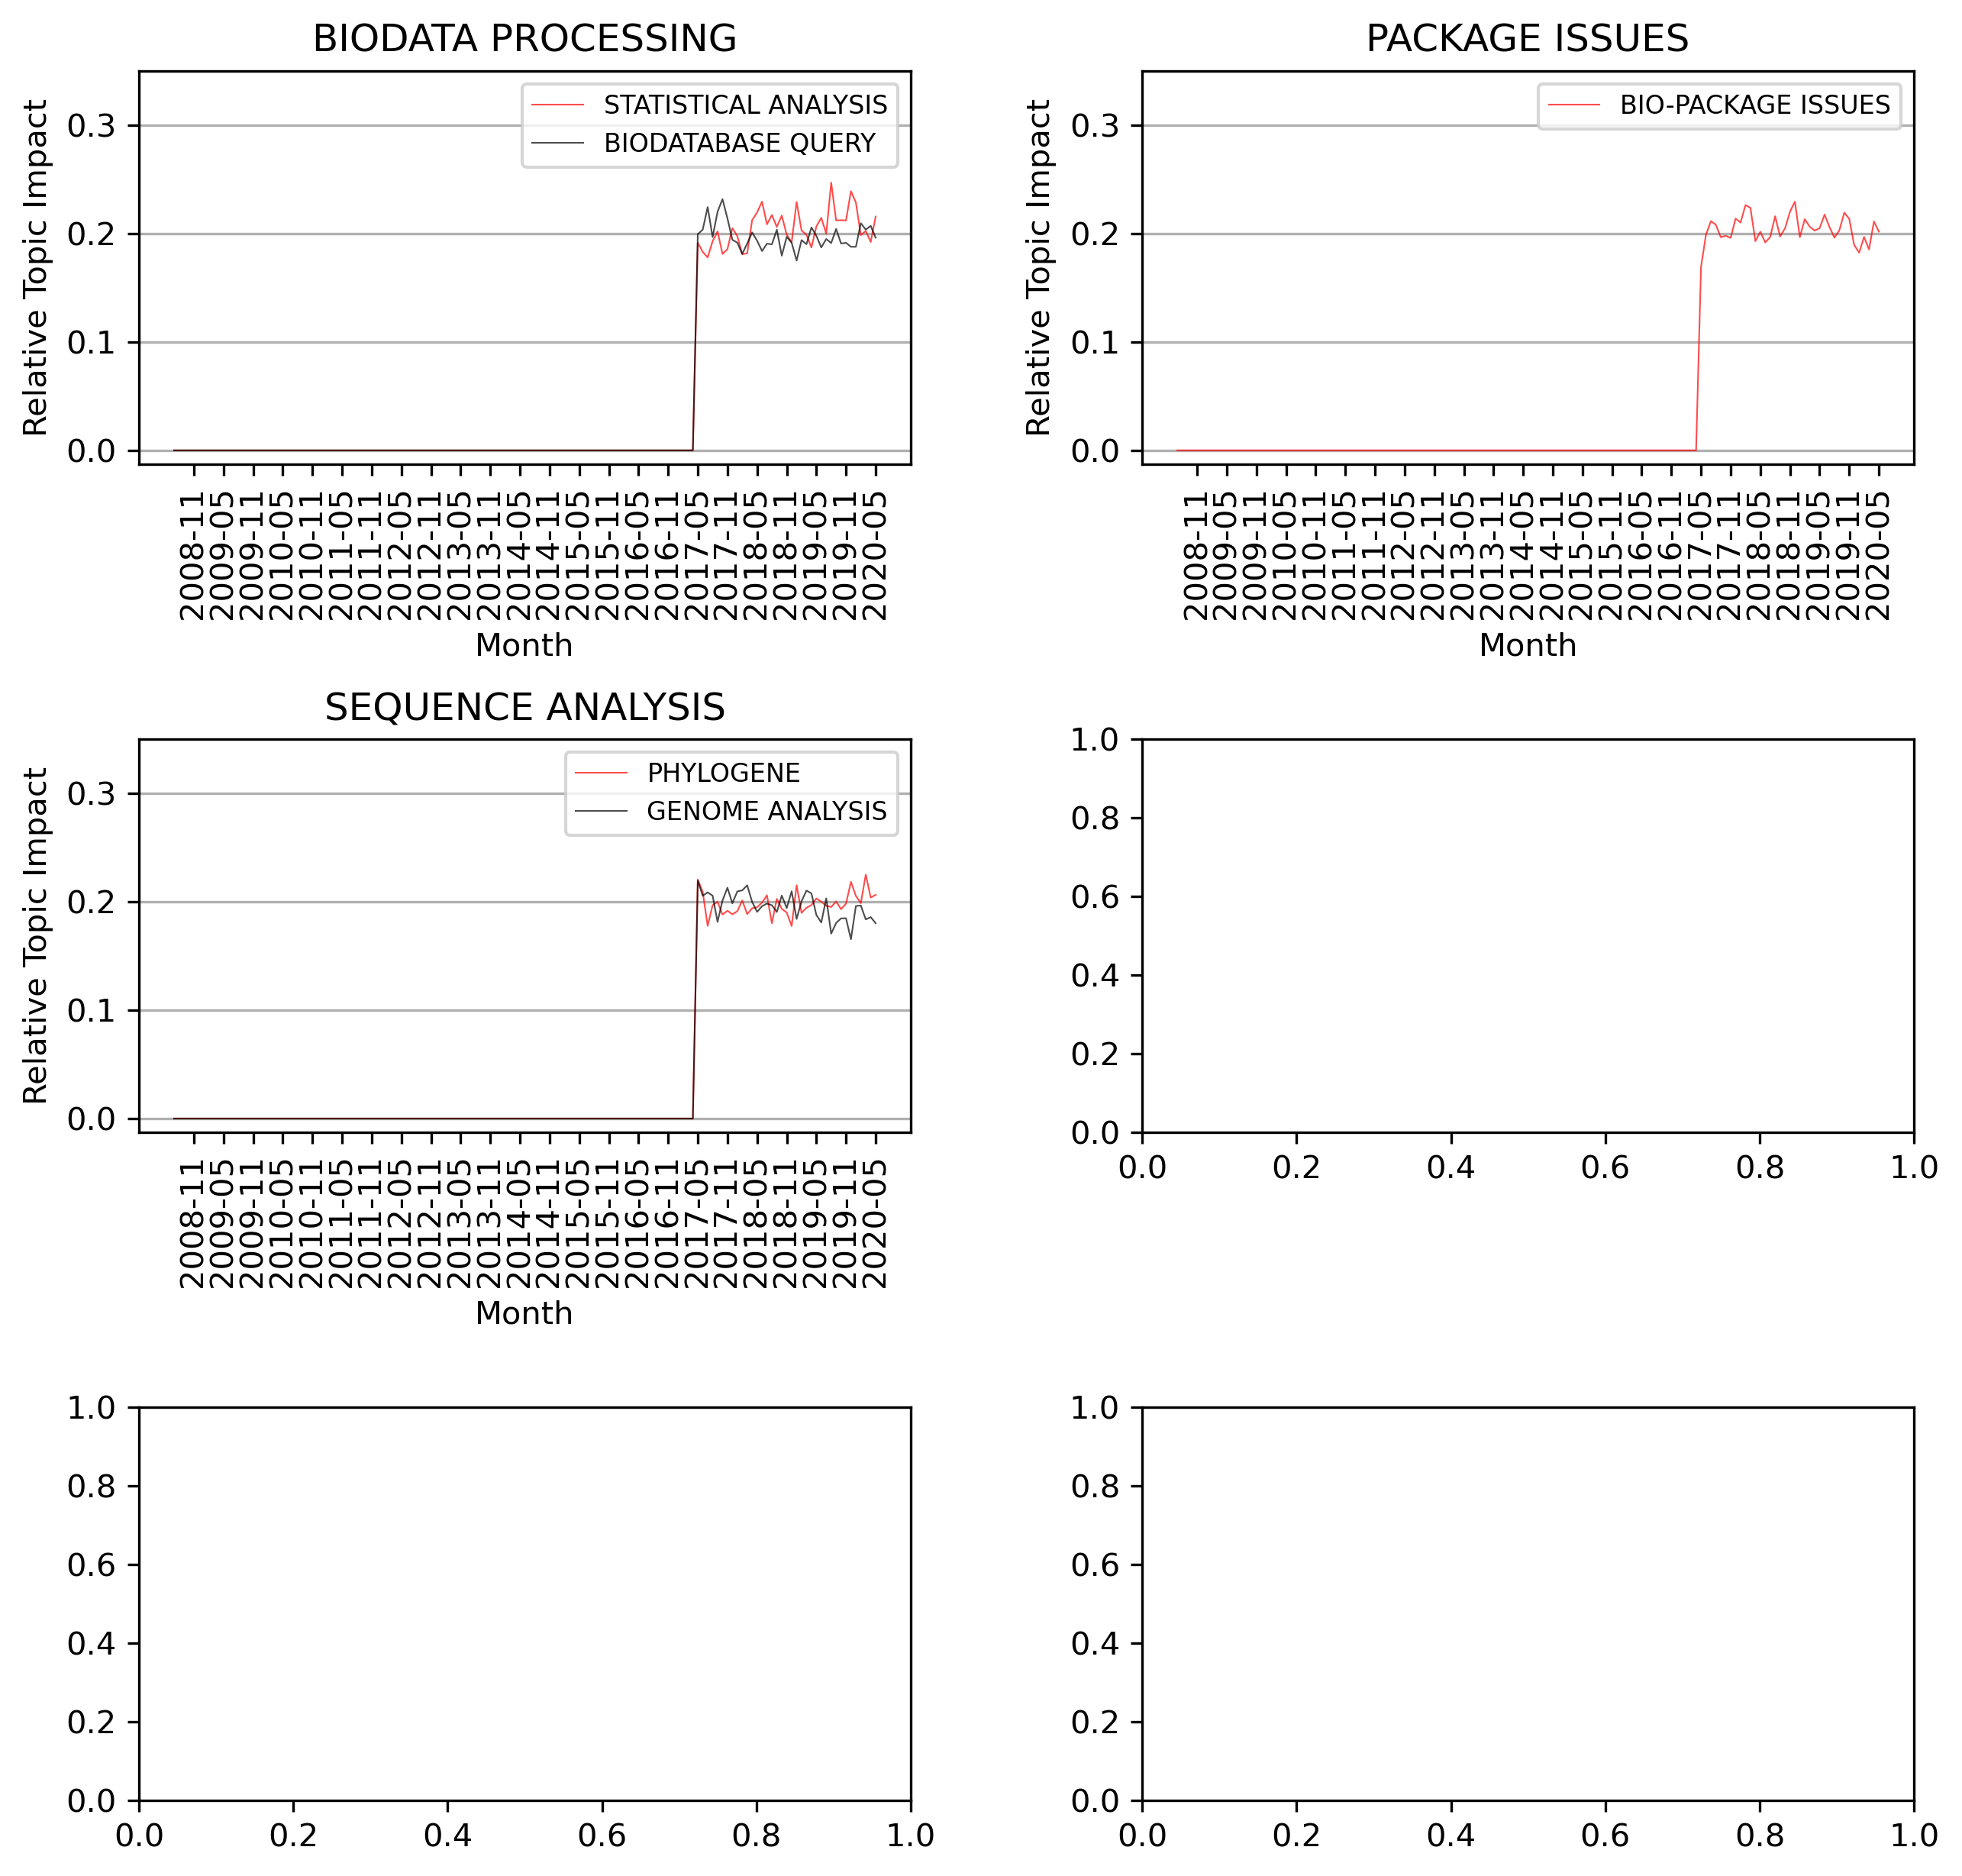

In [88]:
fig, ax = plt.subplots(nrows=3,
                       ncols=2,
                       dpi=300,
                       figsize=(10, 10),
                       gridspec_kw={
                           'hspace': 0.7,
                           'wspace': 0.3})
coords = []
for key, vals in heirarchy.items():
    x = [item[0] for item in final_impact[topic_id_dict[vals[0]]]]
    subcats = []
    for val in vals:
        subcats.append({
            'y': [item[1] for item in final_impact[topic_id_dict[val]]],
            'topic': val,
        }
        )
    subcats.sort(
        key=lambda x: np.max(x['y']),
        reverse=True
    )

#     index = np.argsort(ys)
#     index = np.flip(index)
    coords.append({
        'Category': key,
        'x': x,
        'y': [item['y'] for item in subcats],
        'topic': [item['topic'] for item in subcats]
    })

alpha = [0.7,  0.7, 0.7, 0.7, 0.7, 0.7]
linestyles = ['-', '-', '-', '-', '-', '-']
color = ['red', 'black', 'green', 'orange', 'purple']
# fig, ax = plt.subplots(dpi=300)
x = coords[0]['x']
for idx in range(len(coords)):
    for j in range(len(coords[idx]['y'])):
        ax[int(idx / 2)][idx % 2].plot(
            x,
            coords[idx]['y'][j],
            color=color[j],
            alpha=alpha[j],
            linestyle=linestyles[j],
            label=coords[idx]['topic'][j],
            lw=0.5
        )
    ax[int(idx / 2)][idx % 2].set_xlabel('Month')
    ax[int(idx / 2)][idx % 2].set_ylabel('Relative Topic Impact')
    ax[int(idx / 2)][idx %
                     2].set_title(coords[idx]['Category'])

    ax[int(idx / 2)][idx % 2].set_ylim([-0.0125, 0.35])

    ax[int(idx / 2)][idx % 2].grid(True)
    ax[int(idx / 2)][idx % 2].xaxis.grid(False)

    pos = np.arange(4, len(x), 6)
    ax[int(idx / 2)][idx % 2].axes.get_xaxis().set_ticks(pos)
    ax[int(idx / 2)][idx % 2].tick_params(axis='x', rotation=90)

    ax[int(idx / 2)][idx % 2].legend(fontsize=8)
#     ax[int(idx / 2)][idx % 2].legend()
plt.savefig(os.path.join(cur_dir, 'Relative_Impact_Cat_0.svg'), format = 'svg')